# Advent of code 2021

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2021/advent_of_code_2021.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2021/advent_of_code_2021.ipynb)
by [Hugues Hoppe](http://hhoppe.com/) with Python solutions to the
[2021 Advent of Code puzzles](https://adventofcode.com/2021),
completed in December 2021.

See [reddit](https://www.reddit.com/r/adventofcode/comments/rtx354/advent_of_code_2021_notebook_of_compact_and_fast/?utm_source=share&utm_medium=web2x&context=3).

We explore both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 25 puzzles is less than 1 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

Here are some visualization results (obtained by setting `SHOW_BIG_MEDIA = True`):

<p>
<a href="#day5">day5</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day05.png" width="200">&emsp;
<a href="#day9">day9</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day09.gif" width="200">&emsp;
<a href="#day11">day11</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day11.gif" width="140">
</p>
<p>
<a href="#day13">day13</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day13.gif" width="300">&emsp;
<a href="#day15">day15</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day15.gif" width="200">
</p>
<p>
<a href="#day17">day17</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day17.png" width="200">&emsp;
<a href="#day20">day20</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day20.gif" width="200">
</p>
<p>
<a href="#day21">day21</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day21.png" width="200">&emsp;
<a href="#day23">day23</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day23.gif" width="200">&emsp;
<a href="#day25">day25</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2021/results/day25.gif" width="200">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-ocr advent-of-code-hhoppe hhoppe-tools mediapy more-itertools numba parse

In [3]:
from __future__ import annotations

import ast
import collections
from collections.abc import Callable, Iterable, Iterator
import copy
import dataclasses
import functools
import heapq
import itertools
import math
import os
import sys
import textwrap
import types
import typing
from typing import Any, Generic, Tuple, TypeVar

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import advent_of_code_ocr  # https://github.com/bsoyka/advent-of-code-ocr/blob/main/advent_of_code_ocr/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib.pyplot as plt
import mediapy as media
import more_itertools
import numpy as np
import parse

_T = TypeVar('_T')
_T2 = TypeVar('_T2')  # pylint: disable=invalid-name

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2021
SHOW_BIG_MEDIA = False

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
TAR_URL = f'https://github.com/hhoppe/advent_of_code_{YEAR}/raw/main/data/{PROFILE}.tar.gz'
if 1:
  hh.run(
      f'if [ ! -d data/{PROFILE} ]; then (mkdir -p data && cd data &&'
      f' wget -q {TAR_URL} && tar xzf {PROFILE}.tar.gz); fi'
  )
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL is not found, we may try adventofcode.com using a session cookie:
if 0:
  # !rm -f ~/.config/aocd/token*; mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token
  # where "53616..." is the session cookie from "adventofcode.com" (valid 1 month).
  hh.run('pip install -q advent-of-code-data')  # https://github.com/wimglenn/advent-of-code-data
  import aocd  # pylint: disable=unused-import # noqa

In [9]:
try:
  import numba
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

In [10]:
SHOW_BIG_MEDIA = os.environ.get('SHOW_BIG_MEDIA', str(SHOW_BIG_MEDIA)).lower() in ['true', '1']
advent = advent_of_code_hhoppe.Advent(year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Increasing numbers in sequence

- Part 1: How many measurements are larger than the previous measurement?

- Part 2: Consider sums of a three-measurement sliding window. How many sums are larger than the previous sum?

---

I explored two approaches:

1.  A solution involving **Python generators**.  What is particularly neat is that a new list is never created, because all new elements are generated and processed on-the-fly.

2. A solution based on **1D `numpy` arrays**.  The library function `np.convolve()` makes it easy to evaluate a sliding-window sum.

In [13]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2021/day/1), `puzzle.input` has 2_000 lines:

198
208
209
212
213
217
218
223
 ...
10902
10903
10931
10930


The stored answers are: `{1: '1791', 2: '1822'}`

In [14]:
s1 = """\
199
200
208
210
200
207
240
269
260
263
"""

In [15]:
def day1a(s, *, part2=False):  # Solution based on generators.
  sequence: Iterable[int] = map(int, s.splitlines())
  if part2:
    sequence = (sum(window) for window in more_itertools.sliding_window(sequence, 3))
  return sum(a < b for a, b in more_itertools.sliding_window(sequence, 2))


check_eq(day1a(s1), 7)
puzzle.verify(1, day1a)  # ~1 ms.

day1a_part2 = functools.partial(day1a, part2=True)
check_eq(day1a_part2(s1), 5)
puzzle.verify(2, day1a_part2)  # ~2 ms.

(Part 1: 0.000 s)
(Part 2: 0.001 s)


In [16]:
def day1(s, *, part2=False):  # Solution using numpy; fastest.
  sequence = np.array(list(map(int, s.splitlines())))
  if part2:
    sequence = np.convolve(sequence, [1, 1, 1], mode='valid')
  return np.count_nonzero(np.diff(sequence) > 0)


check_eq(day1(s1), 7)
puzzle.verify(1, day1)  # ~1 ms.

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2(s1), 5)
puzzle.verify(2, day1_part2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day2"></a>
## Day 2: Commands to move in 2D

- Part 1: What do you get if you multiply your final horizontal position by your final depth?

- Part 2: What do you get if you multiply your final horizontal position by your final depth?

In [17]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2021/day/2), `puzzle.input` has 1_000 lines:

forward 3
down 4
forward 3
up 4
down 4
down 6
down 3
down 1
 ...
down 7
forward 5
forward 3
forward 7


The stored answers are: `{1: '2150351', 2: '1842742223'}`

In [18]:
s1 = """\
forward 5
down 5
forward 8
up 3
down 8
forward 2
"""

In [19]:
def day2_part1(s):
  y, x = 0, 0
  for line in s.splitlines():
    command, value = line.split(' ')
    value = int(value)
    if command == 'forward':
      x += value
    elif command == 'down':
      y += value
    elif command == 'up':
      y -= value
    else:
      assert False
  return x * y


check_eq(day2_part1(s1), 150)
puzzle.verify(1, day2_part1)  # ~1 ms.

(Part 1: 0.000 s)


In [20]:
def day2_part2(s):
  y, x, aim = 0, 0, 0
  for line in s.splitlines():
    command, value = line.split(' ')
    value = int(value)
    if command == 'forward':
      x += value
      y += aim * value
    elif command == 'down':
      aim += value
    elif command == 'up':
      aim -= value
    else:
      assert False
  return x * y


check_eq(day2_part2(s1), 900)
puzzle.verify(2, day2_part2)  # ~1 ms.

(Part 2: 0.000 s)


<a name="day3"></a>
## Day 3: Most common chars in strings

- Part 1: Determine the string made up of the the most (and then least) common characters in each position, interpret these two strings as binary numbers, and return their product.

- Part 2: Successively cull the list of strings matching the most common character in each successive position until a single string remain, repeat the process using the least common character, and return the product of those two binary numbers.

In [21]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2021/day/3), `puzzle.input` has 1_000 lines:

001000010101
010010111110
001010110111
001001011101
001001010011
001111100111
100000000101
010001011011
 ...
100110010011
100111111011
000010010011
100111101100


The stored answers are: `{1: '3633500', 2: '4550283'}`

In [22]:
s1 = """\
00100
11110
10110
10111
10101
01111
00111
11100
10000
11001
00010
01010
"""

In [23]:
def day3(s, *, part2=False):
  lines = s.splitlines()

  def most_and_least_common(lines):
    grid = np.array([list(line) for line in lines], int)
    t = grid.sum(axis=0)
    s1 = ''.join(str(int(b)) for b in t >= (len(lines) + 1) // 2)
    s2 = s1.translate(str.maketrans('01', '10'))
    return s1, s2

  if not part2:
    s1, s2 = most_and_least_common(lines)
    return int(s1, base=2) * int(s2, base=2)

  def cull_lines(examine_least: bool):
    lines2 = lines
    # Iterate over successive positions in the string.
    for i in itertools.count():
      s0 = most_and_least_common(lines2)[examine_least]
      lines2 = [line for line in lines2 if line[i] == s0[i]]
      if len(lines2) == 1:
        return int(lines2[0], base=2)

  return cull_lines(False) * cull_lines(True)


check_eq(day3(s1), 198)
puzzle.verify(1, day3)  # ~5 ms.

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2(s1), 230)
puzzle.verify(2, day3_part2)  # ~22 ms.

(Part 1: 0.001 s)
(Part 2: 0.004 s)


<a name="day4"></a>
## Day 4: Bingo boards

- Part 1: For the first winning board, what is the product of winning number and the sum of the unmarked numbers?

- Part 2: What is this same score for the last winning board?

---

For this puzzle, it is elegant to represent the array of bingo boards
as a single **3D array** (using `numpy`).

The resulting code
- is compact
- does not involve any explicit coordinates, and
- already generalizes to 2D boards of any size.

In [24]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2021/day/4), `puzzle.input` has 601 lines:

83,69,34,46,30,23,19,75,22,37,89,78,32,39,11,44,95,43,26,48,84,53,94,88,18,40,62 ... 16,58,85,87,12,29,25,14,96,56,60,81

68 73 98 51 49
82 56 87 64  8
46  7 21 38 30
66  5 86 97 74
60 63 76 55 39

 ...
53 98 28 52 19
66 51 46 77 15
34 36 47 80 14
 7 89 62  9 49


The stored answers are: `{1: '41668', 2: '10478'}`

In [25]:
s1 = """\
7,4,9,5,11,17,23,2,0,14,21,24,10,16,13,6,15,25,12,22,18,20,8,19,3,26,1

22 13 17 11  0
 8  2 23  4 24
21  9 14 16  7
 6 10  3 18  5
 1 12 20 15 19

 3 15  0  2 22
 9 18 13 17  5
19  8  7 25 23
20 11 10 24  4
14 21 16 12  6

14 21 17 24  4
10 16 15  9 19
18  8 23 26 20
22 11 13  6  5
 2  0 12  3  7
"""

In [26]:
def day4a(s, *, part2=False):  # Compact.
  sections = s.split('\n\n')
  boards = np.array(
      [[[int(n) for n in line.split()] for line in t.splitlines()] for t in sections[1:]]
  )
  matches = boards < 0
  scores = []
  previously_finished = False
  for number in map(int, sections[0].split(',')):
    matches[boards == number] = True
    finished = (matches.sum(1).max(1) == boards.shape[1]) | (
        matches.sum(2).max(1) == boards.shape[2]
    )
    for winner in np.argwhere(finished & ~previously_finished):
      scores.append(boards[winner][~matches[winner]].sum() * number)
    previously_finished = finished

  return scores[-int(part2)]


check_eq(day4a(s1), 4512)
puzzle.verify(1, day4a)  # ~10 ms.

day4a_part2 = functools.partial(day4a, part2=True)
check_eq(day4a_part2(s1), 1924)
puzzle.verify(2, day4a_part2)  # ~10 ms.

(Part 1: 0.005 s)
(Part 2: 0.005 s)


In [27]:
def day4(s, *, part2=False):  # More readable.
  sections = s.split('\n\n')
  numbers = list(map(int, sections[0].split(',')))
  boards = np.array(
      [[[int(n) for n in line.split()] for line in t.splitlines()] for t in sections[1:]]
  )
  matches = np.full(boards.shape, False)
  scores = []
  previously_finished = np.full(len(boards), False)
  for number in numbers:
    matches[boards == number] = True
    finished = (matches.sum(axis=1).max(axis=1) == boards.shape[1]) | (
        matches.sum(axis=2).max(axis=1) == boards.shape[2]
    )
    for winner in np.argwhere(finished & ~previously_finished):
      scores.append(boards[winner][~matches[winner]].sum() * number)
    previously_finished = finished

  return scores[-1 if part2 else 0]


check_eq(day4(s1), 4512)
puzzle.verify(1, day4)  # ~10 ms.

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s1), 1924)
puzzle.verify(2, day4_part2)  # ~10 ms.

(Part 1: 0.006 s)
(Part 2: 0.005 s)


<a name="day5"></a>
## Day 5: Coverage of line segments

- Part 1: Ignoring diagonal segments, what is the count of gridpoints covered by at least two segments?

- Part 2: Including diagonal segments, what is the count of gridpoints covered by at least two segments?

---

I started with the standard approach of rasterizing the lines using a **`for` loop**, into a **`dict`** data structure indexed by `(x, y)`.

For improved speed, I switched to a **2D array** data structure,
using `numpy` vectorized operations to increment all the pixels for a line segment in a single call.  For diagonal segments, this involves
 [advanced indexing](https://numpy.org/devdocs/user/basics.indexing.html#advanced-indexing).

It's interesting to see the 100x speed improvement, from 900 ms down to 9 ms.

In [28]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2021/day/5), `puzzle.input` has 500 lines:

959,103 -> 139,923
899,63 -> 899,53
591,871 -> 364,644
739,913 -> 310,484
460,309 -> 460,705
351,389 -> 351,837
420,55 -> 420,541
916,520 -> 382,520
 ...
139,153 -> 936,950
436,978 -> 244,978
921,633 -> 921,340
872,63 -> 233,63


The stored answers are: `{1: '7318', 2: '19939'}`

In [29]:
s1 = """\
0,9 -> 5,9
8,0 -> 0,8
9,4 -> 3,4
2,2 -> 2,1
7,0 -> 7,4
6,4 -> 2,0
0,9 -> 2,9
3,4 -> 1,4
0,0 -> 8,8
5,5 -> 8,2
"""

In [30]:
def day5a(s, *, part2=False):  # Compact but slow; supports any dimension.
  count: collections.Counter[tuple[int, int]] = collections.Counter()
  for line in s.splitlines():
    p, q = (np.array(list(map(int, t.split(',')))) for t in line.split(' -> '))
    if part2 or any(p == q):
      d = np.sign(q - p)
      while any(p != q + d):
        count[tuple(p)] += 1  # type: ignore[index]
        p += d
  return sum(v >= 2 for v in count.values())


check_eq(day5a(s1), 5)
puzzle.verify(1, day5a)  # ~480 ms.

day5a_part2 = functools.partial(day5a, part2=True)
check_eq(day5a_part2(s1), 12)
puzzle.verify(2, day5a_part2)  # ~800 ms.

(Part 1: 0.220 s)
(Part 2: 0.357 s)


In [31]:
def day5b(s, *, part2=False):  # Faster, still with dict.
  count: collections.defaultdict[tuple[int, int], int] = collections.defaultdict(int)
  for line in s.splitlines():
    pattern = r'^(\d+),(\d+) -> (\d+),(\d+)$'
    x1, y1, x2, y2 = map(int, hh.re_groups(pattern, line))
    dx, dy = x2 - x1, y2 - y1
    xinc, yinc = np.sign((dx, dy))
    if dx == 0:
      for _ in range(abs(dy) + 1):
        count[y1, x1] += 1
        y1 += yinc
    elif dy == 0:
      for _ in range(abs(dx) + 1):
        count[y1, x1] += 1
        x1 += xinc
    elif part2:
      for _ in range(abs(dx) + 1):
        count[y1, x1] += 1
        x1, y1 = x1 + xinc, y1 + yinc

  return sum(v >= 2 for v in count.values())


puzzle.verify(1, day5b)  # ~90 ms.
day5b_part2 = functools.partial(day5b, part2=True)
puzzle.verify(2, day5b_part2)  # ~180 ms.

(Part 1: 0.035 s)
(Part 2: 0.064 s)


In [32]:
def day5c(s, *, part2=False, size=1000):  # All numpy; clever diagonal slicing.
  count = np.zeros((size, size), int)

  def f(a, b, op=slice):
    return op(a, b + 1) if a < b else op(a, b - 1, -1)

  for line in s.splitlines():
    pattern = r'^(\d+),(\d+) -> (\d+),(\d+)$'
    x1, y1, x2, y2 = map(int, hh.re_groups(pattern, line))
    if y1 == y2:
      count[y1, f(x1, x2)] += 1
    elif x1 == x2:
      count[f(y1, y2), x1] += 1
    elif part2:
      t = count[min(y1, y2) : max(y1, y2) + 1, min(x1, x2) : max(x1, x2) + 1]
      if (y1 < y2) ^ (x1 < x2):
        t = t[::-1]
      t = np.lib.stride_tricks.as_strided(
          t, shape=t.shape[:1], strides=[t.strides[0] + t.strides[1]]
      )
      t += 1

  return np.count_nonzero(count >= 2)


check_eq(day5c(s1, size=10), 5)
puzzle.verify(1, day5c)  # ~6 ms.

day5c_part2 = functools.partial(day5c, part2=True)
check_eq(day5c_part2(s1), 12)
puzzle.verify(2, day5c_part2)  # ~9 ms.

(Part 1: 0.004 s)
(Part 2: 0.004 s)


In [33]:
def day5(s, *, part2=False, size=1000, visualize=False):  # Just as fast.
  count = np.zeros((size, size), int)

  def f(a, b, op=slice):
    return op(a, b + 1) if a < b else op(a, b - 1, -1)

  for line in s.splitlines():
    pattern = r'^(\d+),(\d+) -> (\d+),(\d+)$'
    x1, y1, x2, y2 = map(int, hh.re_groups(pattern, line))
    if y1 == y2:
      count[y1, f(x1, x2)] += 1
    elif x1 == x2:
      count[f(y1, y2), x1] += 1
    elif part2:
      count[f(y1, y2, op=np.arange), f(x1, x2, op=np.arange)] += 1

  if visualize:
    window: Any = Ellipsis  # Uncropped
    window = np.s_[100:400, 100:400]  # Cropped to upper left
    media.show_image(count.astype(float)[window], vmax=3)

  return np.count_nonzero(count >= 2)


check_eq(day5(s1, size=10), 5)
puzzle.verify(1, day5)  # ~6 ms.

day5_part2 = functools.partial(day5, part2=True)
check_eq(day5_part2(s1), 12)
puzzle.verify(2, day5_part2)  # ~9 ms.

(Part 1: 0.003 s)
(Part 2: 0.005 s)


""

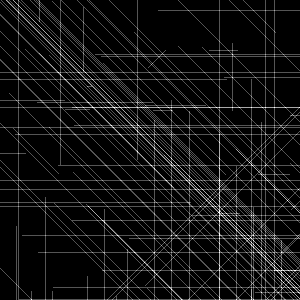

In [34]:
_ = day5_part2(puzzle.input, visualize=True)
media.set_max_output_height(3000)

<a name="day6"></a>
## Day 6: Population of lanternfish

- Part 1: How many lanternfish would there be after 80 days?

- Part 2: How many lanternfish would there be after 256 days?

---

My approach is to iteratively update a **`collections.Counter`** (hash table) data structure.

My colleagues showed that it is even faster to just update an **array** of 9 elements.

In [35]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2021/day/6), `puzzle.input` has a single line of 599 characters:

4,1,1,1,5,1,3,1,5,3,4,3,3,1,3,3,1,5,3,2,4,4,3,4,1,4,2,2,1,3,5,1,1,3,2,5,1,1,4,2, ... 5,5,2,4,2,2,5,2,4,1,3,2,1,1,4,4,1,5


The stored answers are: `{1: '352195', 2: '1600306001288'}`

In [36]:
s1 = '3,4,3,1,2'

In [37]:
def day6a(s, *, part2=False):  # Initial solution, using Counter.
  counter = collections.Counter(map(int, s.strip().split(',')))
  for _ in range(256 if part2 else 80):
    counter2: collections.Counter[int] = collections.Counter()
    for e, count in counter.items():
      if e == 0:
        counter2[8] += count
        counter2[6] += count
      else:
        counter2[e - 1] += count
    counter = counter2
  return sum(counter.values())  # (counter.total() in Python 3.10)


puzzle.verify(1, day6a)  # ~1 ms.
day6a_part2 = functools.partial(day6a, part2=True)
puzzle.verify(2, day6a_part2)  # ~3 ms.

(Part 1: 0.000 s)
(Part 2: 0.001 s)


In [38]:
def day6(s, *, part2=False):  # List-based approach used by colleagues.
  counts = [0] * 9
  for i in map(int, s.strip().split(',')):
    counts[i] += 1
  for _ in range(256 if part2 else 80):
    # counts = counts[1:7] + [counts[7] + counts[0]] + counts[8:] + [counts[0]]
    tmp = counts[0]
    counts = counts[1:] + [tmp]
    counts[6] += tmp
  return sum(counts)


puzzle.verify(1, day6)  # ~0 ms.
day6_part2 = functools.partial(day6, part2=True)
puzzle.verify(2, day6_part2)  # ~0 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [39]:
# Looking at progression for single input, to ideally derive closed-form
# expresssion.  However it looks highly irregular.
def day6_test(s):
  counter = collections.Counter(map(int, s.strip().split(',')))
  for i in range(80):
    counter2: collections.Counter[int] = collections.Counter()
    for e, count in counter.items():
      if e == 0:
        counter2[8] += count
        counter2[6] += count
      else:
        counter2[e - 1] += count
    counter = counter2
    print(i, sum(counter.values()))


if 0:
  day6_test('1')

<a name="day7"></a>
## Day 7: Minimize sum of differences

- Part 1: What is the minimal sum of absolute distances?

- Part 2: What is the minimal sum of quadratic-like distances?

---

The most obvious solution is a **brute-force search** for the optimal element.

However, there is a fast **closed-form** solution:

- The value that minimizes the "*sum of absolute distances*" is known to
lie at `np.median()`.
(This median may be the average of the two nearest values if the length of the list is even; fortunately, for our inputs, `np.median()` happens to always equal an integer.)

- The value that minimizes the "*sum of squared distances*" is known to be the `mean` of the list.
However, the puzzle does not use "squared distance" $d^2$ but a quadratic distance $d(d+1)/2$ which is very close.
It turns out that the answer can be found at either the `mean` value or one of the two adjacent integers.

In [40]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2021/day/7), `puzzle.input` has a single line of 3_903 characters:

1101,1,29,67,1102,0,1,65,1008,65,35,66,1005,66,28,1,67,65,20,4,0,1001,65,1,65,11 ... 89,189,54,230,205,8,123,247,566,947


The stored answers are: `{1: '354129', 2: '98905973'}`

In [41]:
s1 = '16,1,2,0,4,2,7,1,2,14'

In [42]:
def day7a(s, *, part2=False):  # Brute-force search.
  values = np.array(list(map(int, s.split(','))))

  def func(x):
    diff = abs(values - x)
    if part2:
      diff = (diff + 1) * diff // 2
    return diff.sum()

  return min(func(x) for x in range(max(values)))


puzzle.verify(1, day7a)  # ~14 ms.
day7a_part2 = functools.partial(day7a, part2=True)
puzzle.verify(2, day7a_part2)  # ~52 ms.

(Part 1: 0.008 s)
(Part 2: 0.013 s)


In [43]:
def day7(s, *, part2=False):  # Almost closed-form expression.
  values = np.array(list(map(int, s.split(','))))

  if not part2:
    return abs(values - int(np.median(values))).sum()

  def func(x):
    diff = abs(values - x)
    return ((diff + 1) * diff // 2).sum()

  return min(func(x) for x in np.array([-1, 0, 1]) + int(values.mean()))


check_eq(day7(s1), 37)
puzzle.verify(1, day7)  # ~0 ms.

day7_part2 = functools.partial(day7, part2=True)
check_eq(day7_part2(s1), 168)
puzzle.verify(2, day7_part2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day8"></a>
## Day 8: LED with unknown seg map

- Part 1: In the output values, how many times do digits 1, 4, 7, or 8 appear?

- Part 2: What do you get if you add up all of the output values?

---

I explored a total of 7 different approaches with progressively faster speeds, from 1450 ms to 5 ms.

The first 6 approaches search all permutations of assigning input LED segments to output LED segments,
using `itertools.permutations('abcdefg')`.

These 6 approaches differ in whether they loop first over segment permutations and then over lines of the puzzle input, or vice versa,
what representations they use,
and what precomputations they perform.

The last approach is specifically optimized for the 7-segment LED.
It is faster but perhaps less interesting.

In [44]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2021/day/8), `puzzle.input` has 200 lines:

cgaed gcdbfa gcfaed gfcde gadfceb cdbfeg acg eacf eabgd ca | agc efcgbd cag eacf
ga ega edgfa cafed gabd cefagdb begfad ebdgf fcbega cbgdfe | bgdef fdgeb dgabfe gea
ged eg acfgd fdceb cdbefa dgcfe cebfdg edcbga egbf ceadfbg | dfcge dacegbf gcdbaef fdceg
cbefg fedbcg bfdg abgedc fgced edcagf caefb gb fedcbga beg | bdfg cbeaf cfdebg gbe
gecdab gbafd geabdcf ecfa dbcfge cfb afgbc efgbac cf cgbae | fbc fbc cfebgad cf
cbdef febdga fba ba fadecb cgfea adbc cbafe fbedcag egcfbd | dfgbae fdcageb adcefbg efbdc
gecdba ecafbg ecabg bgacfd gecaf feba aedbfgc fca gdfec af | fac af cfa eafbgc
geab adgfc gacef acgefdb gecfba eg dbfgec beacf afedbc ecg | baeg fgadc fagbce edfgbca
 ...
df abfce degbc cfd acgfed gbdf bacfegd efdcb badceg egfcbd | cebgd bgdf bceaf df
bfdc eabdf ebcad fgead bcdeag fba bf bcedgfa cdebfa bcegaf | defba cfbd bdcf fabceg
dbaefcg ec aec dfgbea cafeg aedcbg gacedf egadf gfcba cfde | eac efcd ec egcfda
ecgfdab gcefb bcfa af cgfdbe aegbf ebadg eacgfd gbecaf afg | aedbg bafc acfb 

The stored answers are: `{1: '548', 2: '1074888'}`

In [45]:
s1 = """\
be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | fdgacbe cefdb cefbgd gcbe
edbfga begcd cbg gc gcadebf fbgde acbgfd abcde gfcbed gfec | fcgedb cgb dgebacf gc
fgaebd cg bdaec gdafb agbcfd gdcbef bgcad gfac gcb cdgabef | cg cg fdcagb cbg
fbegcd cbd adcefb dageb afcb bc aefdc ecdab fgdeca fcdbega | efabcd cedba gadfec cb
aecbfdg fbg gf bafeg dbefa fcge gcbea fcaegb dgceab fcbdga | gecf egdcabf bgf bfgea
fgeab ca afcebg bdacfeg cfaedg gcfdb baec bfadeg bafgc acf | gebdcfa ecba ca fadegcb
dbcfg fgd bdegcaf fgec aegbdf ecdfab fbedc dacgb gdcebf gf | cefg dcbef fcge gbcadfe
bdfegc cbegaf gecbf dfcage bdacg ed bedf ced adcbefg gebcd | ed bcgafe cdgba cbgef
egadfb cdbfeg cegd fecab cgb gbdefca cg fgcdab egfdb bfceg | gbdfcae bgc cg cgb
gcafb gcf dcaebfg ecagb gf abcdeg gaef cafbge fdbac fegbdc | fgae cfgab fg bagce
"""

In [46]:
# Brute-force iteration over all permutations is not excessive:
if 0:
  print(len(list(itertools.permutations('abcdefg'))))  # 5040
  print(math.perm(len('abcdefg')))  # 5040

In [47]:
def day8a_part1(s):
  total = 0
  for line in s.splitlines():
    _, outputs = map(str.split, line.split(' | '))
    total += sum(len(output) in [2, 3, 4, 7] for output in outputs)
  return total


check_eq(day8a_part1(s1), 26)


def day8_part1(s):
  return sum(
      len(output) in [2, 3, 4, 7]
      for line in s.splitlines()
      for output in line.split(' | ')[1].split()
  )


check_eq(day8_part1(s1), 26)
puzzle.verify(1, day8_part1)  # ~0 ms.

(Part 1: 0.000 s)


In [48]:
def day8_lookup():
  return {
      'abcefg': '0',
      'cf': '1',
      'acdeg': '2',
      'acdfg': '3',
      'bcdf': '4',
      'abdfg': '5',
      'abdefg': '6',
      'acf': '7',
      'abcdefg': '8',
      'abcdfg': '9',
  }

In [49]:
def day8a_part2(s):  # Brute-force; most compact.
  lookup = day8_lookup()
  total = 0

  for line in s.splitlines():
    inputs, outputs = map(str.split, line.split(' | '))
    for permutation in itertools.permutations('abcdefg'):
      translation = str.maketrans('abcdefg', ''.join(permutation))

      def get_digit(segs):
        return lookup.get(''.join(sorted(segs.translate(translation))), None)

      if all(get_digit(input) for input in inputs):
        total += int(''.join(get_digit(output) for output in outputs))
        break
    else:
      raise ValueError(f'Line "{line}" has no consistent mapping.')

  return total


check_eq(day8a_part2(s1), 61229)
puzzle.verify(2, day8a_part2)  # ~1450 ms.

(Part 2: 0.609 s)


In [50]:
def day8b_part2(s):  # Faster; cache a translation table for each permutation.
  lookup = {frozenset(k): str(v) for k, v in day8_lookup().items()}
  total = 0

  @functools.lru_cache(maxsize=None)  # (@functools.cache in Python 3.9)
  def digit_mapper(permutation):
    translation = str.maketrans('abcdefg', ''.join(permutation))
    return lambda segs: lookup.get(frozenset(segs.translate(translation)), None)

  for line in s.splitlines():
    inputs, outputs = map(str.split, line.split(' | '))
    inputs.sort(key=len)  # Optional, for speedup.
    for permutation in itertools.permutations('abcdefg'):
      get_digit = digit_mapper(permutation)
      if all(get_digit(input) for input in inputs):
        total += int(''.join(get_digit(output) for output in outputs))
        break
    else:
      raise ValueError(f'Line "{line}" has no consistent mapping.')

  return total


check_eq(day8b_part2(s1), 61229)
puzzle.verify(2, day8b_part2)  # ~810 ms.

(Part 2: 0.372 s)


In [51]:
def day8c_part2(s):  # Faster; loop over permutations first, then lines.
  lookup = day8_lookup()
  lines = s.splitlines()
  ins0, outs0 = zip(*(map(str.split, line.split(' | ')) for line in lines))
  ins = [[frozenset(input) for input in inputs] for inputs in ins0]
  outs = list(outs0)
  total = 0

  for permutation in itertools.permutations('abcdefg'):
    translation = str.maketrans(''.join(permutation), 'abcdefg')
    decode = {frozenset(k.translate(translation)): v for k, v in lookup.items()}
    for i in reversed(range(len(ins))):
      if all(input in decode for input in ins[i]):
        total += int(''.join(str(decode[frozenset(output)]) for output in outs[i]))
        _ = ins.pop(i), outs.pop(i)

  assert not ins
  return total


check_eq(day8c_part2(s1), 61229)
puzzle.verify(2, day8c_part2)  # ~360 ms.

(Part 2: 0.163 s)


In [52]:
def day8d_part2(s):  # Faster; precompute seg sets for each permutation.
  lookup = day8_lookup()
  valids = {
      ''.join(permutation): set(
          frozenset(k.translate(str.maketrans('abcdefg', ''.join(permutation)))) for k in lookup
      )
      for permutation in itertools.permutations('abcdefg')
  }
  total = 0

  for line in s.splitlines():
    inputs0, outputs = map(str.split, line.split(' | '))
    inputs = frozenset(frozenset(input) for input in inputs0)
    for permutation, valid in valids.items():
      if inputs == valid:
        translation = str.maketrans('abcdefg', permutation)
        decode = {frozenset(k.translate(translation)): str(v) for k, v in lookup.items()}
        total += int(''.join(decode[frozenset(output)] for output in outputs))
        break
    else:
      raise ValueError(f'Line "{line}" has no consistent mapping.')

  return total


check_eq(day8d_part2(s1), 61229)
puzzle.verify(2, day8d_part2)  # ~240 ms.

(Part 2: 0.155 s)


In [53]:
def day8e_part2(s):  # Faster; loop over permutations first, and use sets of lines.
  lookup = day8_lookup()
  lines = {
      (frozenset(frozenset(i) for i in inputs), tuple(frozenset(o) for o in outputs))
      for line in s.splitlines()
      for inputs, outputs in [map(str.split, line.split(' | '))]
  }
  total = 0

  for permutation in itertools.permutations('abcdefg'):
    translation = str.maketrans(''.join(permutation), 'abcdefg')
    valid = frozenset(frozenset(k.translate(translation)) for k in lookup)
    decode = {frozenset(k.translate(translation)): v for k, v in lookup.items()}
    processed_lines = set()
    for line in lines:
      inputs, outputs = line
      if inputs == valid:
        total += int(''.join(str(decode[output]) for output in outputs))
        processed_lines.add(line)
    lines -= processed_lines

  assert not lines
  return total


check_eq(day8e_part2(s1), 61229)
puzzle.verify(2, day8e_part2)  # ~170 ms.

(Part 2: 0.083 s)


In [54]:
def day8_part2(s):  # Fastest; custom solution for the 7-segment LED.
  total = 0
  segs_from_digit: dict[int, frozenset[str]] = {}  # digit 0..9 -> frozenset of segments.
  rules: list[tuple[int, int, Callable[[frozenset[str]], bool]]] = [
      # (digit, len(segs), predicate(segs)).
      (1, 2, lambda e: True),
      (7, 3, lambda e: True),
      (4, 4, lambda e: True),
      (8, 7, lambda e: True),
      (3, 5, lambda e: e > segs_from_digit[1]),
      (6, 6, lambda e: not e > segs_from_digit[1]),
      (9, 6, lambda e: e > segs_from_digit[3]),
      (0, 6, lambda e: True),
      (2, 5, lambda e: not e < segs_from_digit[9]),
      (5, 5, lambda e: True),
  ]

  for line in s.splitlines():
    inputs0, outputs = map(str.split, line.split(' | '))
    inputs = set(frozenset(input) for input in inputs0)
    segs_from_digit.clear()
    for digit, length, predicate in rules:
      (segs,) = (e for e in inputs if len(e) == length and predicate(e))
      segs_from_digit[digit] = segs
      inputs.remove(segs)
    digit_from_segs = {segs: digit for digit, segs in segs_from_digit.items()}
    total += int(''.join(str(digit_from_segs[frozenset(output)]) for output in outputs))

  return total


check_eq(day8_part2(s1), 61229)
puzzle.verify(2, day8_part2)  # ~5 ms.

(Part 2: 0.003 s)


<a name="day9"></a>
## Day 9: Heightmap basins

- Part 1: What is the sum of the risk levels of all low points on your heightmap?

- Part 2: What do you get if you multiply together the sizes of the three largest basins?

---

I pursued two approaches, which may both be unconventional and interesting:

1.  Using the **`Union-Find` algorithm** to define the basins as the connected components of "drainage" relations between adjacent grid nodes.
Unfortunately this is slow because the basic merging operation
    ```python
    union_find.unify(yx, tuple(yx + downward[yx]))
    ```
is not vectorized across nodes.

2.  Computing for each node the lowest node to which it drains, as sequence of **vectorized `numpy` updates**:
    ```python
    for _ in range(8):
      yx += np.moveaxis(downward[tuple(yx)], -1, 0)
    ```
and then using the powerful `np.unique()` function to identify the basins
as the sets of nodes with common drainage.

In [55]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2021/day/9), `puzzle.input` has 100 lines:

5456789349886456890123985435578996543213456789656899996467789234989765442345789778999989652349879899
4349891298765348789339875323456789665434568996545698874356679959879898321457893569998879931998765668
1298910989873234595498764312345678976746899989656987563234567899767987442578954678987968899897654457
2987939875432123489999953201234599698657979979997965432023479998959876553689965789876856789789543345
9896899984321012668899865313546789569798965469879876553135568987643988767997896898765945697698722256
8765789965442143456789996579658895434999876398767987864589679876542099898966789999833123598589810123
9954629876553234667899987988767932129899989219755398878678989987943989959355678998921057987678924345
6543212989654345788999898999998941098789998998543229989789797999899876543134989997632345698789545456
 ...
2324579569889834578965789998976899876679876544567892346899986545992198765767893345997569987654568999
10124596987793235699546789679979877645899974323789654679999879568939876545567894578964

The stored answers are: `{1: '506', 2: '931200'}`

In [56]:
s1 = """\
2199943210
3987894921
9856789892
8767896789
9899965678
"""

In [57]:
def day9a(s, *, part2=False):  # Solution using Union-Find.  Relatively slow.
  grid = np.array([list(line) for line in s.splitlines()], int)
  dyxs = np.array([(0, -1), (0, 1), (-1, 0), (1, 0)])
  t = np.pad(grid, 1, constant_values=10)
  neighbors = np.array([np.roll(t, -dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs])
  low_point = (grid[None] < neighbors).all(axis=0)

  if not part2:
    return (grid[low_point] + 1).sum()

  downward = dyxs[neighbors.argmin(axis=0)]
  downward[grid == 9] = 0

  union_find = hh.UnionFind[Tuple[int, int]]()
  for y, x in np.ndindex(grid.shape):
    dy, dx = downward[y, x]
    union_find.union((y, x), (y + dy, x + dx))

  rep = np.array(
      [[union_find.find((y, x)) for x in range(grid.shape[1])] for y in range(grid.shape[0])]
  )

  _, count = np.unique(rep.reshape(-1, 2), axis=0, return_counts=True)
  return np.sort(count)[-3:].prod()


check_eq(day9a(s1), 15)
puzzle.verify(1, day9a)  # ~5 ms.

day9a_part2 = functools.partial(day9a, part2=True)
check_eq(day9a_part2(s1), 1134)
puzzle.verify(2, day9a_part2)  # ~110 ms.

(Part 1: 0.001 s)
(Part 2: 0.031 s)


In [58]:
def day9b(s, *, part2=False, visualize=False):  # Faster using numpy.
  grid = np.array([list(line) for line in s.splitlines()], int)
  dyxs = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])
  t = np.pad(grid, 1, constant_values=10)
  neighbors = np.array([np.roll(t, -dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs])
  low_point = (grid < neighbors).all(axis=0)

  if not part2:
    return (grid[low_point] + 1).sum()

  downward = dyxs[neighbors.argmin(axis=0)]
  downward[grid == 9] = downward[low_point] = 0

  yx = np.array(np.indices(grid.shape))
  for _ in range(8):
    yx += np.moveaxis(downward[tuple(yx)], -1, 0)

  _, count = np.unique(yx.reshape(2, -1), axis=1, return_counts=True)

  if visualize:
    _, inverse = np.unique(yx.reshape(2, -1), axis=1, return_inverse=True)
    cmap = np.random.default_rng(0).choice(range(30, 150), (len(count), 3)).astype(np.uint8)
    cmap[count == 1] = 0
    cmap[count >= heapq.nlargest(3, count)[-1]] += 100  # 2 are tied for third!
    basin = cmap[inverse.reshape(grid.shape)]
    basin[low_point] = 255
    images = {'Heightmap': grid.astype(float), 'Basins': basin}
    media.show_images(images, height=grid.shape[0] * 3)

  return math.prod(heapq.nlargest(3, count))


check_eq(day9b(s1), 15)
puzzle.verify(1, day9b)  # ~4 ms.

day9b_part2 = functools.partial(day9b, part2=True)
check_eq(day9b_part2(s1), 1134)
puzzle.verify(2, day9b_part2)  # ~15 ms.

(Part 1: 0.001 s)
(Part 2: 0.006 s)


In [59]:
def day9(s, *, part2=False, visualize=False):  # Faster, using flat indexing.
  grid = np.array([list(line) for line in s.splitlines()], int)
  dyxs = np.concatenate([[v, -v] for v in np.eye(grid.ndim, dtype=int)])
  t = np.pad(grid, 1, constant_values=10)
  neighbors = np.array([np.roll(t, -dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs])
  low_point = (grid < neighbors).all(axis=0)

  if not part2:
    return (grid[low_point] + 1).sum()

  downward = dyxs[neighbors.argmin(axis=0)]
  downward[grid == 9] = downward[low_point] = 0
  downward = downward.dot([grid.shape[1], 1]).ravel()

  indices = np.arange(grid.size)
  for _ in range(8):
    indices += downward[indices]
  _, count = np.unique(indices, return_counts=True)

  if visualize:
    _, inverse = np.unique(indices, return_inverse=True)
    basins = {}
    for highlight in range(2):
      cmap = np.random.default_rng(0).choice(range(30, 150), (len(count), 3)).astype(np.uint8)
      cmap[count == 1] = 0
      if highlight:
        cmap[count >= heapq.nlargest(3, count)[-1]] += 100
      basin = cmap[inverse.reshape(grid.shape)]
      basin[low_point] = 255
      basins[highlight] = basin.repeat(3, axis=0).repeat(3, axis=1)
    height_map = grid.astype(float).repeat(3, axis=0).repeat(3, axis=1)
    media.show_image(height_map, title='Height map')
    title = 'Basins (two may be tied for 3rd place!)'
    media.show_video(basins.values(), title=title, codec='gif', fps=1)

  return math.prod(heapq.nlargest(3, count))


# To generalize to arbitrary dimensions:
# downward = downward.dot(np.cumprod([1, *grid.shape[-1:0:-1]])[::-1]).ravel()

# To omit the `for` loop:
# indices = functools.reduce(lambda indices, _: indices + downward[indices],
#                            range(8), np.arange(grid.size))

check_eq(day9(s1), 15)
puzzle.verify(1, day9)  # ~4 ms.

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2(s1), 1134)
puzzle.verify(2, day9_part2)  # ~7 ms.

(Part 1: 0.001 s)
(Part 2: 0.002 s)


Height map

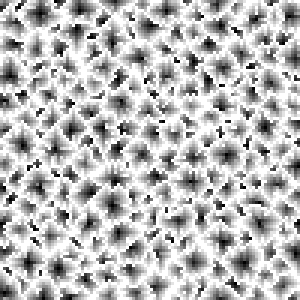

Basins (two may be tied for 3rd place!)

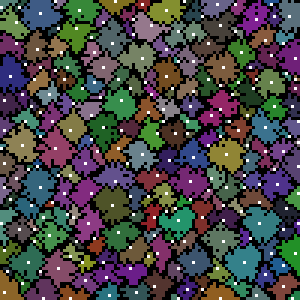

In [60]:
_ = day9_part2(puzzle.input, visualize=True)

<a name="day10"></a>
## Day 10: Parsing parentheses

- Part 1: What is the total syntax error score for those errors?

- Part 2: For all incomplete inputs, compute an auto-complete score.  What is the middle score?

---

This is a straightforward solution with a **`stack`**.

In [61]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2021/day/10), `puzzle.input` has 90 lines:

(((<(([{{((<[[<><>]<()[]>]{[{}()]<(){}>}>[<([]{})>])(<<(<><>>[<><>]>(<{}()><(){}>)>[(([])<[]()>)])){<((<{}()
{(({({<[[[{[{({}{})[[]{}]}[{(){}}((){})]][{((){}){[]{}}}<(()())<<><>>>]}]]]{([<{<<()()>([][])>({[]()}[{}<
[[{<(([<<{(<[[()()]]{[[]()]<{}>}><{{{}()}<<>[]>><(())[()[]]>>)([{[[][]][()()]}{{()()}}](<{{}()}>))}[([{<<
{<[{<{[({[[[[{<>{}}<{}()>]<{<><>}{[][]}>](<<<>[]>[()()]>[{[]{}>[<>()]])]{{{[()()][<><>]}<[{}()][{}{}]
(<[{[{[((<{[[<()()><{}{}>][(<>{}){{}{}}]]{<[<><>]>{{{}[]}(<>[])}}}(<[[[]{}](<>{})]{[[][]][[][]]}>)>)){<{
<<<(<(<[[[<[{{[]<>}([]())}([[]])]([[[]<>][()()]]{<()()>([]{})])>]{[[<{[]{}}([]{})>{(<>[]){{}{}}}]]{({{<>[]
[{<(({(<{<{<<{<><>}>({<><>}<<><>>)}{[{[]<>}[[][]]][<()<>>]}}<[[[()()]{<><>}]((<>)[{}()])]{<{()<>}
<[([{{{({<({(<(){}><[]()>)((()())[[]()})})[<{<<>>((){})}<[<><>]{(){}}>>{{(<>[])({}[])}(<()<>>)}]>})}({{({
 ...
([{[{<<<[{{({[{}()]}<<<>[]>{<>[]}>)((([]<>))([<>{}]))}{{[([]{})<(){}>}((()[])<[]()>)}({[(){}
[({[<[[[(((<<[[]]<[]<>>>>{{([]<>){()[]}}})(({(<><>)({}())})<({{

The stored answers are: `{1: '323613', 2: '3103006161'}`

In [62]:
s1 = """\
[({(<(())[]>[[{[]{<()<>>
[(()[<>])]({[<{<<[]>>(
{([(<{}[<>[]}>{[]{[(<()>
(((({<>}<{<{<>}{[]{[]{}
[[<[([]))<([[{}[[()]]]
[{[{({}]{}}([{[{{{}}([]
{<[[]]>}<{[{[{[]{()[[[]
[<(<(<(<{}))><([]([]()
<{([([[(<>()){}]>(<<{{
<{([{{}}[<[[[<>{}]]]>[]]
"""

In [63]:
def day10_part1(s):
  open_from_close = {')': '(', ']': '[', '}': '{', '>': '<'}
  total = 0
  for line in s.splitlines():
    stack = []
    for ch in line:
      if ch in '([{<':
        stack.append(ch)
      elif stack.pop() != open_from_close[ch]:
        total += {')': 3, ']': 57, '}': 1197, '>': 25137, '': 0}[ch]

  return total


check_eq(day10_part1(s1), 26397)
puzzle.verify(1, day10_part1)  # ~2 ms.

(Part 1: 0.000 s)


In [64]:
def day10_part2(s):
  open_from_close = {')': '(', ']': '[', '}': '{', '>': '<'}
  scores = []
  for line in s.splitlines():
    stack = []
    for ch in line:
      if ch in '([{<':
        stack.append(ch)
      elif stack.pop() != open_from_close[ch]:
        break
    else:
      score = 0
      while stack:
        score = score * 5 + {'(': 1, '[': 2, '{': 3, '<': 4}[stack.pop()]
      scores.append(score)
      continue

  return int(np.median(scores))


check_eq(day10_part2(s1), 288957)
puzzle.verify(2, day10_part2)  # ~3 ms.

(Part 2: 0.000 s)


<a name="day11"></a>
## Day 11: Grid with cascading flashes

- Part 1: How many total flashes are there after 100 steps?

- Part 2: What is the first step during which all octopuses flash?

---

The basic approach is to traverse the grid at each iteration, adding flashing elements to a **`stack`** and performing a depth-first expansion of the flashing grid nodes.

To speed up the computation, I move from a 2D grid to a flat 1D array.
The solution is fast enough that `numba`-compilation is unnecessary.

Curiously, given a 1D boolean array (e.g., `flashed`), I find that the fastest way to extract a list of the indices of its `True` elements to be:

```python
    # stack = list(np.nonzero(flashed)[0])  # (Slower.)
    # stack = list(np.argwhere(flashed)[:, 0])  # (Slower.)
    stack = [index for index, value in enumerate(flashed) if value]
```

In [65]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2021/day/11), `puzzle.input` has 10 lines:

6318185732
1122687135
5173237676
8754362612
5718474666
8443654137
1247634346
1446514585
6717288267
1727871228


The stored answers are: `{1: '1634', 2: '210'}`

In [66]:
s1 = """\
5483143223
2745854711
5264556173
6141336146
6357385478
4167524645
2176841721
6882881134
4846848554
5283751526
"""

In [67]:
def day11a(s, *, part2=False):  # Compact.
  grid = np.array([list(line) for line in s.splitlines()], int)
  total = 0

  for step in itertools.count(1):
    grid += 1
    stack = list(np.argwhere(grid == 10))
    while stack:
      yx = stack.pop()
      for dyx in set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}:
        yx2 = tuple(np.array(yx) + dyx)
        if all(0 <= yx2[i] < grid.shape[i] for i in range(2)) and grid[yx2] < 10:
          grid[yx2] += 1
          if grid[yx2] == 10:
            stack.append(yx2)

    if not part2:
      total += (grid == 10).sum()
      if step == 100:
        return total
    elif np.all(grid == 10):
      return step
    grid[grid == 10] = 0


check_eq(day11a(s1), 1656)
puzzle.verify(1, day11a)  # ~110 ms.

day11a_part2 = functools.partial(day11a, part2=True)
check_eq(day11a_part2(s1), 195)
puzzle.verify(2, day11a_part2)  # ~225 ms.

(Part 1: 0.046 s)
(Part 2: 0.087 s)


In [68]:
def day11b(s, *, part2=False):  # Faster, using ndenumerate and bool array.
  grid = np.array([list(line) for line in s.splitlines()], int)
  dyxs = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
  height, width = grid.shape
  total = 0

  for step in itertools.count(1):
    grid += 1
    flashed = grid > 9
    stack = [yx for yx, value in np.ndenumerate(flashed) if value]
    while stack:
      yx = stack.pop()
      for dy, dx in dyxs:
        yx2 = yx[0] + dy, yx[1] + dx
        if 0 <= yx2[0] < height and 0 <= yx2[1] < width and not flashed[yx2]:
          grid[yx2] += 1
          if grid[yx2] > 9:
            stack.append(yx2)
            flashed[yx2] = True

    grid[flashed] = 0
    if not part2:
      total += np.count_nonzero(flashed)
      if step == 100:
        return total
    elif flashed.all():
      return step


check_eq(day11b(s1), 1656)
puzzle.verify(1, day11b)  # ~16 ms.

day11b_part2 = functools.partial(day11b, part2=True)
check_eq(day11b_part2(s1), 195)
puzzle.verify(2, day11b_part2)  # ~30 ms.

(Part 1: 0.006 s)
(Part 2: 0.011 s)


In [69]:
def day11(s, *, part2=False, visualize=False):  # Fastest, using flat array.
  grid0 = np.array([list(line) for line in s.splitlines()], int)
  height, width = grid0.shape
  grid = grid0.ravel()
  dyxs = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
  total = 0
  images = []

  @functools.lru_cache(maxsize=None)
  def neighbors(index):
    y, x = divmod(index, width)
    result = []
    for dy, dx in dyxs:
      y2, x2 = y + dy, x + dx
      if 0 <= y2 < height and 0 <= x2 < width:
        result.append(y2 * width + x2)
    return result

  for step in itertools.count(1):
    grid += 1
    flashed = grid > 9
    # stack = list(np.nonzero(flashed)[0])  # (Slower.)
    # stack = list(np.argwhere(flashed)[:, 0])  # (Slower.)
    stack = [index for index, value in enumerate(flashed) if value]
    while stack:
      index = stack.pop()
      for index2 in neighbors(index):
        if not flashed[index2]:
          grid[index2] += 1
          if grid[index2] > 9:
            stack.append(index2)
            flashed[index2] = True

    grid[flashed] = 0

    if visualize:
      image = (grid.reshape(grid0.shape) * 25).astype(np.uint8)
      images.append(image.repeat(10, axis=0).repeat(10, axis=1))

    if not part2:
      total += np.count_nonzero(flashed)
      if step == 100:
        return total
    elif flashed.all():
      if visualize:
        images = [images[0]] * 15 + images + [images[-1]] * 15
        media.show_video(images, codec='gif', fps=15, border=True)
      return step


check_eq(day11(s1), 1656)
puzzle.verify(1, day11)  # ~8 ms.

day11_part2 = functools.partial(day11, part2=True)
check_eq(day11_part2(s1), 195)
puzzle.verify(2, day11_part2)  # ~15 ms.

(Part 1: 0.003 s)
(Part 2: 0.006 s)


""

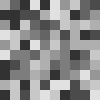

In [70]:
_ = day11_part2(puzzle.input, visualize=True)

<a name="day12"></a>
## Day 12: Count distinct paths

- Part 1: How many paths through this cave system are there that visit small caves at most once?

- Part 2: If a single small cave can be visited at most twice, how many paths through this cave system are there?

---

The approach is a simple **exhaustive recursive search** where the current state contains
`[current_node, nodes_already_visited, has_a_node_been_visited_twice]`.

The search is accelerated 20x times by **caching** the intermediate results using `@functools.lru_cache(maxsize=None)`.  This requires representing `nodes_already_visited` by a `frozenset` (which is hashable) instead of a `set` (which is not hashable).

In [71]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2021/day/12), `puzzle.input` has 25 lines:

BC-gt
gt-zf
end-KH
end-BC
so-NL
so-ly
start-BC
NL-zf
 ...
bt-so
ui-KH
gt-start
KH-so


The stored answers are: `{1: '4775', 2: '152480'}`

In [72]:
s1 = """\
start-A
start-b
A-c
A-b
b-d
A-end
b-end
"""

s2 = """\
fs-end
he-DX
fs-he
start-DX
pj-DX
end-zg
zg-sl
zg-pj
pj-he
RW-he
fs-DX
pj-RW
zg-RW
start-pj
he-WI
zg-he
pj-fs
start-RW
"""

In [73]:
def day12a(s, *, part2=False):  # Clean solution.
  graph = collections.defaultdict(list)
  for line in s.splitlines():
    a, b = line.split('-')
    graph[a].append(b)
    graph[b].append(a)

  def recurse(node, visited, seen_twice):
    count = 0
    for node2 in graph[node]:
      if node2 == 'start':
        pass
      elif node2 == 'end':
        count += 1
      elif not node2.islower():
        count += recurse(node2, visited, seen_twice)
      elif node2 not in visited:
        count += recurse(node2, visited | {node2}, seen_twice)
      elif not seen_twice:
        count += recurse(node2, visited, True)
    return count

  return recurse('start', set(), not part2)


check_eq(day12a(s1), 10)
check_eq(day12a(s2), 226)
puzzle.verify(1, day12a)  # ~14 ms.

day12a_part2 = functools.partial(day12a, part2=True)
check_eq(day12a_part2(s1), 36)
check_eq(day12a_part2(s2), 3509)
puzzle.verify(2, day12a_part2)  # ~440 ms.

(Part 1: 0.005 s)
(Part 2: 0.136 s)


In [74]:
def day12(s, *, part2=False):  # Much faster using lru_cache and frozenset.
  graph = collections.defaultdict(list)
  for line in s.splitlines():
    a, b = line.split('-')
    graph[a].append(b)
    graph[b].append(a)

  @functools.lru_cache(maxsize=None)
  def recurse(node, visited, seen_twice):
    count = 0
    for node2 in graph[node]:
      if node2 == 'start':
        pass
      elif node2 == 'end':
        count += 1
      elif not node2.islower():
        count += recurse(node2, visited, seen_twice)
      elif node2 not in visited:
        count += recurse(node2, visited.union([node2]), seen_twice)
      elif not seen_twice:
        count += recurse(node2, visited, True)
    return count

  return recurse('start', frozenset(), not part2)


check_eq(day12(s1), 10)
check_eq(day12(s2), 226)
puzzle.verify(1, day12)  # ~1 ms.

day12_part2 = functools.partial(day12, part2=True)
check_eq(day12_part2(s1), 36)
check_eq(day12_part2(s2), 3509)
puzzle.verify(2, day12_part2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day13"></a>
## Day 13: Repeated 2D foldings

- Part 1: How many dots are visible after completing just the first fold instruction on your transparent paper?

- Part 2: After applying all folds, what 8 characters do the resulting dots form?

---

I explored two quite different approaches:

1. Storing the dots in a **`set`** and performing folding using set comprehension.

2. Storing the dots as `True` values in a **2D grid** and performing folding using `numpy` updates.

Both approach are fast.  In either case, the solution string is extracted from a grid-raster representation using the `convert_6()` function in the `advent_of_code_ocr` package.

In [75]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2021/day/13), `puzzle.input` has 860 lines:

609,754
1101,140
1129,317
622,327
967,218
661,789
661,127
1183,596
 ...
fold along x=40
fold along y=27
fold along y=13
fold along y=6


The stored answers are: `{1: '710', 2: 'EPLGRULR'}`

In [76]:
s1 = """\
6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5
"""

In [77]:
def day13a(s, *, part2=False):  # Most compact; set-based.
  chunk1, chunk2 = s.split('\n\n')
  dots = {tuple(map(int, line.split(','))) for line in chunk1.splitlines()}

  for line in chunk2.splitlines():
    axis, value = {'x': 0, 'y': 1}[line[11:12]], int(line[13:])

    def fold(xy):
      return tuple(c if i != axis or c < value else 2 * value - c for i, c in enumerate(xy))

    dots = {fold(xy) for xy in dots}
    if not part2:
      return len(dots)

  s2 = '\n'.join(''.join('.#'[(x, y) in dots] for x in range(39)) for y in range(6))
  return advent_of_code_ocr.convert_6(s2)


check_eq(day13a(s1), 17)
puzzle.verify(1, day13a)  # ~2 ms.

day13a_part2 = functools.partial(day13a, part2=True)
puzzle.verify(2, day13a_part2)  # ~6 ms.  e.g. 'EPLGRULR'.

(Part 1: 0.001 s)
(Part 2: 0.003 s)


(Part 1: 0.001 s)
(Part 2: 0.002 s)


""

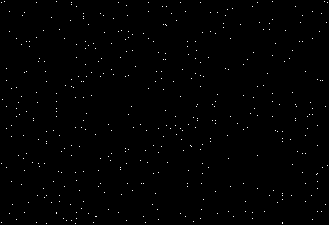

In [78]:
def day13b(s, *, part2=False, visualize=False):  # More readable; a bit faster.
  chunk1, chunk2 = s.split('\n\n')
  dots = {tuple(map(int, line.split(',')))[::-1] for line in chunk1.splitlines()}
  if visualize:
    all_dots = {(0, *dot) for dot in dots}

  for t, line in enumerate(chunk2.splitlines()):
    axis, value = {'y': 0, 'x': 1}[line[11:12]], int(line[13:])

    def reflect(yx):
      yx = list(yx)
      yx[axis] = yx[axis] if yx[axis] < value else 2 * value - yx[axis]
      return tuple(yx)

    dots = {reflect(yx) for yx in dots}
    if not part2:
      return len(dots)
    if visualize:
      all_dots |= {(t + 1, *dot) for dot in dots}

  if visualize:
    all_dots = {tyx for tyx in all_dots if tyx[0] >= 4}  # Skip initial frames.
    video: Any = hh.grid_from_indices(all_dots, pad=(0, 1, 1), dtype=bool)
    video = [video[0]] * 2 + list(video) + [video[-1]] * 3
    media.show_video(video, codec='gif', fps=2)

  grid = np.full((6, 39), '.')
  # grid[tuple(np.array(list(dots)).T)] = '#'
  grid[tuple(zip(*dots))] = '#'
  return advent_of_code_ocr.convert_6('\n'.join(''.join(row) for row in grid))


check_eq(day13b(s1), 17)
puzzle.verify(1, day13b)  # ~2 ms.

day13b_part2 = functools.partial(day13b, part2=True)
puzzle.verify(2, day13b_part2)  # ~4 ms.  e.g. 'EPLGRULR'.

_ = day13b_part2(puzzle.input, visualize=True)

In [79]:
def day13(s, *, part2=False, visualize=False):  # Numpy approach; as fast.
  chunk1, chunk2 = s.split('\n\n')
  yx = np.array([list(map(int, line.split(',')))[::-1] for line in chunk1.splitlines()])
  grid = np.zeros(yx.max(axis=0) + 1, np.uint8)
  grid[tuple(yx.T)] = 1

  for line in chunk2.splitlines():
    axis, value = {'y': 0, 'x': 1}[line[11:12]], int(line[13:])
    grid = grid.T if axis else grid
    grid, side2 = grid[:value], grid[value + 1 :]
    grid[-len(side2) :] |= side2[::-1]
    grid = grid.T if axis else grid
    if not part2:
      return np.count_nonzero(grid)

  if visualize:
    media.show_image(~np.pad(grid, 1), height=48, border=True)
  grid = np.array(['.', '#'])[grid]
  return advent_of_code_ocr.convert_6('\n'.join(''.join(row) for row in grid))


check_eq(day13(s1), 17)
puzzle.verify(1, day13)  # ~4 ms.

day13_part2 = functools.partial(day13, part2=True)
puzzle.verify(2, day13_part2)  # ~4 ms.  e.g. 'EPLGRULR'.

(Part 1: 0.002 s)
(Part 2: 0.002 s)


In [80]:
_ = day13_part2(puzzle.input, visualize=True)

""


<a name="day14"></a>
## Day 14: Repeated middle expansions

- Part 1: After 10 expansions, what is the quantity of the most common element minus the quantity of the least common element?

- Part 2: After 40 expansions?

---

I created two code versions, both using `collections.Counter`:

1.  A compact function involving a clever but slow `sum(iterable_of_counters, start=Counter())`.

2.  A faster function that avoids `sum()`.

In [81]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2021/day/14), `puzzle.input` has 102 lines:

CKKOHNSBPCPCHVNKHFFK

KO -> C
SO -> S
BF -> V
VN -> B
OV -> K
VH -> O
 ...
FP -> B
HC -> O
PN -> F
OH -> H


The stored answers are: `{1: '3831', 2: '5725739914282'}`

In [82]:
s1 = """\
NNCB

CH -> B
HH -> N
CB -> H
NH -> C
HB -> C
HC -> B
HN -> C
NN -> C
BH -> H
NC -> B
NB -> B
BN -> B
BB -> N
BC -> B
CC -> N
CN -> C
"""

In [83]:
def day14a(s, *, part2=False):  # Compact.
  Counter = collections.Counter
  lines = s.splitlines()
  start = lines[0]
  pairs = Counter(start[i : i + 2] for i in range(len(start) - 1))
  rules = dict(rule.split(' -> ') for rule in lines[2:])

  for _ in range(40 if part2 else 10):
    pairs = sum(
        (
            Counter({pair[0] + rules[pair]: count, rules[pair] + pair[1]: count})
            for pair, count in pairs.items()
        ),
        Counter(),
    )

  letters2 = sum(
      (Counter({letter: count}) for pair, count in pairs.items() for letter in pair),
      Counter([start[0], start[-1]]),
  )
  return np.ptp(list(letters2.values())) // 2


check_eq(day14a(s1), 1588)
puzzle.verify(1, day14a)  # ~18 ms.

day14a_part2 = functools.partial(day14a, part2=True)
check_eq(day14a_part2(s1), 2188189693529)
puzzle.verify(2, day14a_part2)  # ~85 ms.

(Part 1: 0.007 s)
(Part 2: 0.030 s)


In [84]:
def day14(s, *, part2=False):  # Faster (avoiding inefficient sum()).
  lines = s.splitlines()
  start = lines[0]
  pairs = collections.Counter(start[i : i + 2] for i in range(len(start) - 1))
  rules = dict(line.split(' -> ') for line in lines[2:])

  for _ in range(40 if part2 else 10):
    new_pairs: collections.Counter[str] = collections.Counter()
    for pair, count in pairs.items():
      new_pairs[pair[0] + rules[pair]] += count
      new_pairs[rules[pair] + pair[1]] += count
    pairs = new_pairs

  letters_in_pairs: collections.Counter[str] = collections.Counter()
  for pair, count in pairs.items():
    for letter in pair:
      letters_in_pairs[letter] += count

  letters_in_pairs[start[0]] += 1
  letters_in_pairs[start[-1]] += 1
  return (max(letters_in_pairs.values()) - min(letters_in_pairs.values())) // 2


check_eq(day14(s1), 1588)
puzzle.verify(1, day14)  # ~1 ms.

day14_part2 = functools.partial(day14, part2=True)
check_eq(day14_part2(s1), 2188189693529)
puzzle.verify(2, day14_part2)  # ~4 ms.

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day15"></a>
## Day 15: Shortest path on 2D grid

- Part 1: What is the lowest total risk of any path from the top left to the bottom right?

- Part 2: Using a 5x5 larger map with modified risks, what is the lowest total risk of any path from the top left to the bottom right?

---

I implemented:

1. A compact solution using the **Dijkstra** shortest-path algorithm.

2. A solution that adds **padding** around the grid to eliminate boundary-condition testing and compiles with `numba`.  This is my reference solution.  It also provides a visualization of the solution path.

3. An **A\* search** where the heuristic "remaining cost" is taken to the Manhattan distance from the current node to the destination node, multiplied by a `heuristic_weight`, which defaults to 2.
A\* is unhelpful here because the edge weights vary quite a bit, so it's difficult to get a useful heuristic which is also a valid lower bound on the remaining distance to the destination.
Also, there is little opportunity for improvement because the advancing front must traverse nearly the entire domain in any case.

4. A succession of **diagonal sweeps** (upper-left to lower-right, and lower-right to upper-left) that greedily update the distance grid, similar to a [Manhattan distance transform](https://en.wikipedia.org/wiki/Distance_transform).
While the distance estimates are very good after just a few sweeps, outperforming Solution 2 for my puzzle input, it could require many iterations to converge to the correct solution in the worst case.

5. Constraining the solution to a **diagonal band** of the search domain.  While this is practical, again it cannot guarantee a correct solution.  (I deleted this version.)

In [85]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2021/day/15), `puzzle.input` has 100 lines:

1219917144152175521192937532735222272149142113771132143147736143821412611744118289583116354731774896
2557512188918722129241527232426994127475524882192911212273111191198918793769715954435631918975113353
5148523873321627398918131496732819295119712179711821713519886567141523157142619551992311453629315192
9632263822975132424163835224215815892118427192363791212959143352271227157116392913928119722459511125
3185531228179249199132957128512117111252215481499141912134153119363486721329112488129931544281746943
6444131257861912212213566341547625318612947741947592216383971229498251819853114728336521972351727213
6119491432245199553227565792296746663122251697311779965288819515139517181957182294511562659256672111
4171583111313321126172811385811255321273232454216251182121721131484211131831222492993728891981971114
 ...
7271212528143433228925278813516213957172122199181859163721121116782941621321111232342127151299298258
11931712221817315775123111516221153259812493255244113295271491232941871315193311152931

The stored answers are: `{1: '361', 2: '2838'}`

In [86]:
s1 = """\
1163751742
1381373672
2136511328
3694931569
7463417111
1319128137
1359912421
3125421639
1293138521
2311944581
"""

In [87]:
def day15a(s, *, part2=False):  # Compact.
  grid = np.array([list(line) for line in s.splitlines()], int)
  if part2:
    a = [np.concatenate([(grid + (y + x - 1)) % 9 + 1 for x in range(5)], axis=1) for y in range(5)]
    grid = np.concatenate(a, axis=0)

  distances = np.full(grid.shape, 10**6)
  distances[0, 0] = 0
  pq = [(0, (0, 0))]
  while pq:
    d, yx = heapq.heappop(pq)
    if yx == (grid.shape[0] - 1, grid.shape[1] - 1):
      return d
    for dyx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
      yx2 = yx[0] + dyx[0], yx[1] + dyx[1]
      if 0 <= yx2[0] < grid.shape[0] and 0 <= yx2[1] < grid.shape[1]:
        candidate_d = d + grid[yx2]
        if candidate_d < distances[yx2]:
          distances[yx2] = candidate_d
          heapq.heappush(pq, (candidate_d, yx2))


check_eq(day15a(s1), 40)
puzzle.verify(1, day15a)  # ~60 ms.
day15a_part2 = functools.partial(day15a, part2=True)
check_eq(day15a_part2(s1), 315)
puzzle.verify(2, day15a_part2)  # ~1700 ms.

(Part 1: 0.021 s)
(Part 2: 0.534 s)


In [88]:
def day15b(s, *, part2=False):  # Try A* search.
  grid = np.array([list(line) for line in s.splitlines()], int)
  if part2:
    a = [np.concatenate([(grid + (y + x - 1)) % 9 + 1 for x in range(5)], axis=1) for y in range(5)]
    grid = np.concatenate(a, axis=0)

  grid = np.pad(grid, 1, constant_values=10**8)  # To avoid boundary checks.
  c0 = grid.shape[0] - 2 + grid.shape[1] - 2

  def hfunc(yx):
    heuristic_weight = 2
    return (c0 - yx[0] - yx[1]) * heuristic_weight

  start = 1, 1
  destination = grid.shape[0] - 2, grid.shape[1] - 2
  check_eq(hfunc(destination), 0)
  distances = np.full(grid.shape, 10**6)
  distances[start] = 0
  pq = [(hfunc(start), start)]
  best_solution = 10**6
  while pq:
    f, yx = heapq.heappop(pq)
    d = distances[yx]
    if yx == destination:
      # return d
      best_solution = min(best_solution, d)
      # print(f'{best_solution=}')
    if 1 and d > best_solution + 40:
      break
    y, x = yx
    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
      yx2 = y + dy, x + dx
      # https://en.wikipedia.org/wiki/A*_search_algorithm
      g = d + grid[yx2]
      if g < distances[yx2]:
        distances[yx2] = g
        f = g + hfunc(yx2)
        heapq.heappush(pq, (f, yx2))
  return best_solution


check_eq(day15b(s1), 40)
# puzzle.verify(1, day15b)  # ~140 ms.
day15b_part2 = functools.partial(day15b, part2=True)
check_eq(day15b_part2(s1), 315)
# puzzle.verify(2, day15b_part2)  # ~1850 ms.

In [89]:
# Fastest: several opposing sweeps, but can fail.
@numba.njit
def day15c_func(grid):
  stride = grid.shape[1]
  flat = grid.ravel()
  start = stride + 1
  destination = flat.size - stride - 2
  distances = np.full(flat.size, 10**6)
  distances[start] = 0
  count = 0

  while True:
    last_distance = distances[destination]
    for index in range(start, destination + 1):
      d = flat[index] + min(distances[index - 1], distances[index - stride])
      distances[index] = min(distances[index], d)

    # Not a guarantee though.
    if distances[destination] == last_distance:
      count += 1
      if count == 3:  # Hacky.
        return distances[destination]

    for index in range(destination, start - 1, -1):
      d = flat[index] + min(distances[index + 1], distances[index + stride])
      distances[index] = min(distances[index], d)


def day15c(s, *, part2=False):
  grid = np.array([list(line) for line in s.splitlines()], int)
  if part2:
    a = [np.concatenate([(grid + (y + x - 1)) % 9 + 1 for x in range(5)], axis=1) for y in range(5)]
    grid = np.concatenate(a, axis=0)
  grid = np.pad(grid, 1, constant_values=10**8)  # To avoid boundary checks.
  return day15c_func(grid)


check_eq(day15c(s1), 40)
# puzzle.verify(1, day15c)  # ~11 ms.  (Commented because it could fail.)
day15c_part2 = functools.partial(day15c, part2=True)
check_eq(day15c_part2(s1), 315)
# puzzle.verify(2, day15c_part2)  # ~27 ms.  (Commented because it could fail.)

In [90]:
# Padded, numba, visualization.
@numba.njit
def day15_func(grid, visualize):
  start = 1, 1
  destination = grid.shape[0] - 2, grid.shape[1] - 2
  distances = np.full(grid.shape, 10**6)
  distances[start] = 0
  prev = np.empty((*grid.shape, 2), np.int32)
  pq = [(0, start)]
  while pq:
    d, yx = heapq.heappop(pq)
    # if d > distances[yx]: continue  # Skip finalized.  No change in speed.
    if yx == destination:
      path_image = None
      if visualize:
        path_image = grid < 0
        while yx != start:
          path_image[yx] = True
          yx = prev[yx][0], prev[yx][1]
      return d, path_image
    y, x = yx
    for dy, dx in ((-1, 0), (1, 0), (0, -1), (0, 1)):
      yx2 = y + dy, x + dx
      candidate_d = d + grid[yx2]
      if candidate_d < distances[yx2]:
        distances[yx2] = candidate_d
        heapq.heappush(pq, (candidate_d, yx2))
        if visualize:
          prev[yx2] = yx


def day15(s, *, part2=False, visualize=False):
  grid = np.array([list(line) for line in s.splitlines()], int)
  if part2:
    a = [np.concatenate([(grid + (y + x - 1)) % 9 + 1 for x in range(5)], axis=1) for y in range(5)]
    grid = np.concatenate(a, axis=0)
  grid = np.pad(grid, 1, constant_values=10**8)  # To avoid boundary checks.
  d, path_image = day15_func(grid, visualize)
  if visualize:
    # media.show_image(~path_image, border=True)
    frame0 = media.to_rgb(grid[1:-1, 1:-1] * 1.0, cmap='bwr')
    frame1 = np.where(path_image[1:-1, 1:-1, None], 0, frame0)
    media.show_video([frame0, frame1], codec='gif', fps=1)
  return d


check_eq(day15(s1), 40)
puzzle.verify(1, day15)  # ~14 ms.
day15_part2 = functools.partial(day15, part2=True)
check_eq(day15_part2(s1), 315)
puzzle.verify(2, day15_part2)  # ~90 ms.

(Part 1: 0.001 s)
(Part 2: 0.030 s)


""

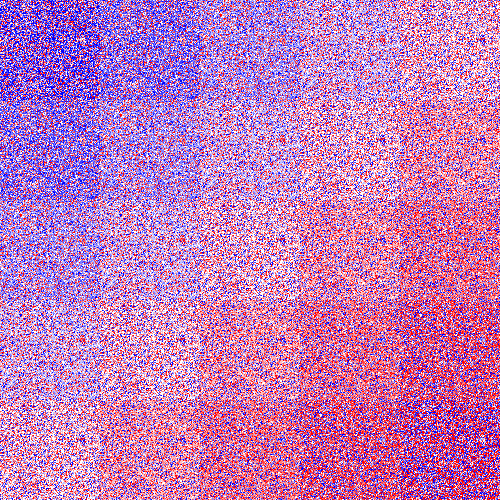

In [91]:
_ = day15_part2(puzzle.input, visualize=True)

<a name="day16"></a>
## Day 16: Decode nested bit packets

- Part 1: What is the sum of the version numbers in all packets?

- Part 2: What do you get if you evaluate the expression represented by your hexadecimal-encoded BITS transmission?

---

This puzzle is straightforward.
I thought there might be a chance that the `BITS` encoding might get reused for a different purpose in a subsequent puzzle, so I created a second implementation that parses the input into a tree structure before evaluating it.

In [92]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2021/day/16), `puzzle.input` has a single line of 1_366 characters:

0054FEC8C54DC02295D5AE9B243D2F4FEA154493A43E0E60084E61CE802419A95E38958DE4F100B9 ... CF15CA0E4D044F9E4B6258A5065400D9B68


The stored answers are: `{1: '934', 2: '912901337844'}`

In [93]:
def day16a(s, *, part2=False):  # Directly evaluate.
  s = ''.join(f'{int(nibble, 16):04b}' for nibble in s.strip())
  operation_for_id: dict[int, Callable[..., int]] = {
      0: lambda *operands: sum(operands),
      1: lambda *operands: math.prod(operands),
      2: lambda *operands: min(operands),
      3: lambda *operands: max(operands),
      5: lambda operand1, operand2: int(operand1 > operand2),
      6: lambda operand1, operand2: int(operand1 < operand2),
      7: lambda operand1, operand2: int(operand1 == operand2),
  }
  sum_versions = 0

  def read_bits(n):
    nonlocal s
    value = int(s[:n], 2)
    s = s[n:]
    return value

  def parse_s():
    nonlocal sum_versions
    version = read_bits(3)
    sum_versions += version
    packet_id = read_bits(3)
    if packet_id == 4:
      number = 0
      more = True
      while more:
        more = read_bits(1)
        number = number * 16 + read_bits(4)
      return number
    operands = []
    length_type = read_bits(1)
    if length_type == 0:
      num_bits = read_bits(15)
      len0 = len(s)
      while len0 - len(s) != num_bits:
        operands.append(parse_s())
    else:
      num_packets = read_bits(11)
      for _ in range(num_packets):
        operands.append(parse_s())
    return operation_for_id[packet_id](*operands)

  result = parse_s()
  return result if part2 else sum_versions


check_eq(day16a('8A004A801A8002F478'), 16)
check_eq(day16a('620080001611562C8802118E34'), 12)
check_eq(day16a('C0015000016115A2E0802F182340'), 23)
check_eq(day16a('A0016C880162017C3686B18A3D4780'), 31)
puzzle.verify(1, day16a)  # ~2 ms.

day16a_part2 = functools.partial(day16a, part2=True)
check_eq(day16a_part2('C200B40A82'), 3)
check_eq(day16a_part2('04005AC33890'), 54)
check_eq(day16a_part2('880086C3E88112'), 7)
check_eq(day16a_part2('CE00C43D881120'), 9)
check_eq(day16a_part2('D8005AC2A8F0'), 1)
check_eq(day16a_part2('F600BC2D8F'), 0)
check_eq(day16a_part2('9C005AC2F8F0'), 0)
check_eq(day16a_part2('9C0141080250320F1802104A08'), 1)
puzzle.verify(2, day16a_part2)  # ~2 ms.

(Part 1: 0.001 s)
(Part 2: 0.001 s)


In [94]:
def day16(s, *, part2=False, visualize=0):  # Construct tree first.
  s = ''.join(f'{int(nibble, 16):04b}' for nibble in s.strip())
  operation_for_id: dict[int, Callable[..., int]] = {
      0: lambda *operands: sum(operands),
      1: lambda *operands: math.prod(operands),
      2: lambda *operands: min(operands),
      3: lambda *operands: max(operands),
      5: lambda operand1, operand2: int(operand1 > operand2),
      6: lambda operand1, operand2: int(operand1 < operand2),
      7: lambda operand1, operand2: int(operand1 == operand2),
  }
  name_for_id = {0: 'sum', 1: 'prod', 2: 'min', 3: 'max', 5: 'gt', 6: 'lt', 7: 'eq'}

  def parse_s():
    def read_bits(n):
      nonlocal s
      value = int(s[:n], 2)
      s = s[n:]
      return value

    version = read_bits(3)
    packet_id = read_bits(3)
    if packet_id == 4:
      number = 0
      more = True
      while more:
        more = read_bits(1)
        number = number * 16 + read_bits(4)
      return version, packet_id, number
    length_type = read_bits(1)
    operands = []
    if length_type == 0:
      max_length = read_bits(15)
      len0 = len(s)
      while len0 - len(s) != max_length:
        operands.append(parse_s())
    else:
      max_packets = read_bits(11)
      for _ in range(max_packets):
        operands.append(parse_s())
    return version, packet_id, operands

  tree = parse_s()
  assert all(ch == '0' for ch in s)

  def sum_versions(node):
    return node[0] + (sum(sum_versions(e) for e in node[2]) if node[1] != 4 else 0)

  def evaluate(node, depth=0):
    packet_id = node[1]
    if packet_id == 4:
      return node[2]
    operands = list(map(lambda x: evaluate(x, depth + 1), node[2]))
    result = operation_for_id[packet_id](*operands)
    if depth < visualize:
      print(f'>{"  " * depth}{result} = {name_for_id[packet_id]}{operands}')
    return result

  return evaluate(tree) if part2 else sum_versions(tree)


check_eq(day16('8A004A801A8002F478'), 16)
check_eq(day16('620080001611562C8802118E34'), 12)
check_eq(day16('C0015000016115A2E0802F182340'), 23)
check_eq(day16('A0016C880162017C3686B18A3D4780'), 31)
puzzle.verify(1, day16)  # ~2 ms.

day16_part2 = functools.partial(day16, part2=True)
check_eq(day16_part2('C200B40A82'), 3)
check_eq(day16_part2('04005AC33890'), 54)
check_eq(day16_part2('880086C3E88112'), 7)
check_eq(day16_part2('CE00C43D881120'), 9)
check_eq(day16_part2('D8005AC2A8F0'), 1)
check_eq(day16_part2('F600BC2D8F'), 0)
check_eq(day16_part2('9C005AC2F8F0'), 0)
check_eq(day16_part2('9C0141080250320F1802104A08'), 1)
puzzle.verify(2, day16_part2)  # ~2 ms.
if 0:
  _ = day16_part2(puzzle.input, visualize=2)

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day17"></a>
## Day 17: Canon trajectories

- Part 1: What is the highest y position it reaches on this trajectory?

- Part 2: How many distinct initial velocity values cause the probe to be within the target area after any step?

---

Given an initial velocity, it is straightforward to compute the projectile trajectory and determine if it intersects the target region.

What is more challenging is determining a reasonable **search space for the initial velocities**, denoted here as `(dx0, dy0)`.
To simplify the discussion, we'll assume that the puzzle input has a target region with `x1 > 0`, i.e. it is fully to the right.

Here are some observations:

- The `x` distance traversed with an initial velocity component `dx0 >= 0` is `dx0 + (dx0 - 1) + ... + 1` which equals `(dx0 + 1) * (dx0) // 2`.
Therefore, the initial velocity must satisfy `dx0 >= math.isqrt(x1)`.
For example, for `dx0 = 3`, we get `3 + 2 + 1 = 6` and `int(sqrt(6)) = 2 < 3`.  Similarly, `dx0 = 4` gives `4 + 3 + 2 + 1 = 10` and `int(sqrt(10)) = 3 < 4`.

- Obviously, we must have `dx0 <= x2`, else we immediately overshoot the target horizontally.

- The projectile follows a parabolic trajectory (quadratic in `y`).  When it is launched with positive `dy0`, it will come back down and hit `y=0` with a `dy` value that is *exactly* `-dy0`.
Therefore, it can then be guaranteed that if `dy0 > max(abs(y1), abs(y2))`, no solution can exist --- because its next step down after it crosses `y=0` would be `y = -dy0 - 1` which is below `y1`.

- Finally, we must have `dy0 >= y1`, else we immediately overshoot the target vertically.

- To summarize, the **velocity search space is bounded by** `math.isqrt(x1) <= dx0 <= x2` and `max(abs(y1), abs(y2)) <= dy0 <= y1`.

In [95]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2021/day/17), `puzzle.input` has a single line of 35 characters:

target area: x=209..238, y=-86..-59


The stored answers are: `{1: '3655', 2: '1447'}`

In [96]:
s1 = 'target area: x=20..30, y=-10..-5'
s2 = 'target area: x=-30..-20, y=-10..-5'  # Try negative x values.

In [97]:
def day17a(s, *, part2=False):  # Slow.
  pattern = r'^target area: x=([\d-]+)\.\.([\d-]+), y=([\d-]+)\.\.([\d-]+)$'
  x1, x2, y1, y2 = map(int, hh.re_groups(pattern, s.strip()))
  assert x1 > 0
  highest = -1000
  count = 0
  for dx0 in range(math.isqrt(x1), x2 + 1):
    for dy0 in range(y1, max(abs(y1), abs(y2)) + 1):
      dx, dy = dx0, dy0
      x = y = 0
      max_y = 0
      while x <= x2 and (x >= x1 or dx > 0) and (y >= y1 or dy > 0):
        x, y = x + dx, y + dy
        max_y = max(max_y, y)
        dx, dy = dx - np.sign(dx), dy - 1
        if y1 <= y <= y2 and x1 <= x <= x2:
          count += 1
          highest = max(highest, max_y)
          break

  return count if part2 else highest


check_eq(day17a(s1), 45)
puzzle.verify(1, day17a)  # ~320 ms.

day17a_part2 = functools.partial(day17a, part2=True)
check_eq(day17a_part2(s1), 112)
puzzle.verify(2, day17a_part2)  # ~320 ms.

(Part 1: 0.145 s)
(Part 2: 0.144 s)


In [98]:
# Fast with numba.
@numba.jit
def day17_simulations(x1, x2, y1, y2):
  highest = -1000
  winners = []
  # (math.isqrt() not yet supported by numba.)
  for dx0 in range(int(x1**0.5) if x1 > 0 else x1, (-int((-x2) ** 0.5) if x2 < 0 else x2) + 1):
    for dy0 in range(y1, max(abs(y1), abs(y2)) + 1):
      dx, dy = dx0, dy0
      x = y = 0
      max_y = 0
      while (x <= x2 or dx < 0) and (x >= x1 or dx > 0) and (y >= y1 or dy > 0):
        x, y = x + dx, y + dy
        max_y = max(max_y, y)
        dx, dy = dx - np.sign(dx), dy - 1
        if y1 <= y <= y2 and x1 <= x <= x2:
          winners.append((dy0, dx0))
          highest = max(highest, max_y)
          break
  return winners, highest


def day17(s, *, part2=False, visualize=False):
  x1, x2, y1, y2 = parse.parse('target area: x={:d}..{:d}, y={:d}..{:d}', s.strip()).fixed
  winners, highest = day17_simulations(x1, x2, y1, y2)
  if visualize:
    yx_map = {
        (0, 0): (0, 200, 0),
        **{yx: (255, 100, 100) for yx in winners},
        **{(y, x): (100, 100, 255) for y in range(y1, y2 + 1) for x in range(x1, x2 + 1)},
    }
    image = hh.grid_from_indices(yx_map, background=(250,) * 3, pad=1, dtype=np.uint8)[::-1]
    media.show_image(image, border=True, height=min(image.shape[0] * 2, 500))
  return len(winners) if part2 else highest


check_eq(day17(s1), 45)
check_eq(day17(s2), 45)
puzzle.verify(1, day17)  # ~6 ms.

day17_part2 = functools.partial(day17, part2=True)
check_eq(day17_part2(s1), 112)
check_eq(day17_part2(s2), 112)
puzzle.verify(2, day17_part2)  # ~6 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


""

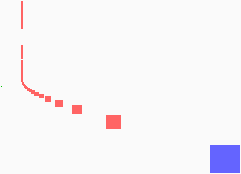

In [99]:
_ = day17_part2(puzzle.input, visualize=True)

The green dot at the left edge is the source (at the origin).  The blue rectangle is the target.  The union of red and blue pixels are the valid initial velocities.

<a name="day18"></a>
## Day 18: Nested integer pairs

- Part 1: What is the magnitude of the final sum?

- Part 2: What is the largest magnitude of any sum of two different snailfish numbers from the homework assignment?

---

This is a rather straightforward problem but with painstaking implementation effort.
My first approach uses a **nested set of lists**.
This means that the input is trivial to read (using the unsafe `eval()` function) and trivial to print for debugging.

After the initial implementation, I realized that all necessary `explode` operations can be safely applied in the same nested-list traversal, and this provides some speedup (from 4100 ms to 2600 ms)

An even greater speedup (down to 230 ms) is enabled by creating an algorithm compatible with `numba`-compilation.
For this, I changed the representation from nested lists to a simple **array of tokens**, and I eliminated recursive function calling by instead using a stack.
This is cumbersome, and my thought now is that if one is really interested in maximizing efficiency for this puzzle, it would be best to just use `C++`.

In [100]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2021/day/18), `puzzle.input` has 100 lines:

[[[[7,2],[0,2]],9],[[[7,8],6],[0,[2,3]]]]
[[[0,9],3],1]
[[[[0,5],6],[[0,6],[7,8]]],[[[2,2],[1,5]],[9,5]]]
[[2,1],[[3,1],[[3,2],9]]]
[[[[9,3],[7,5]],[5,9]],[[0,[0,4]],2]]
[[[9,9],4],[8,[[4,9],7]]]
[[[1,9],[[8,3],[6,1]]],[5,1]]
[[[[8,6],[1,3]],[3,[1,1]]],[[[6,4],[0,4]],[[0,0],3]]]
 ...
[[[[9,0],[5,8]],3],2]
[7,[[[1,0],[9,7]],[[8,3],0]]]
[[[0,1],[4,[4,5]]],[9,[[3,6],[6,8]]]]
[8,[[7,[4,7]],[[0,5],3]]]


The stored answers are: `{1: '4433', 2: '4559'}`

In [101]:
s1 = """\
[[[[4,3],4],4],[7,[[8,4],9]]]
[1,1]
"""

s2 = """\
[1,1]
[2,2]
[3,3]
[4,4]
[5,5]
"""

s3 = """\
[1,1]
[2,2]
[3,3]
[4,4]
[5,5]
[6,6]
"""

s4 = """\
[[[0,[4,5]],[0,0]],[[[4,5],[2,6]],[9,5]]]
[7,[[[3,7],[4,3]],[[6,3],[8,8]]]]
[[2,[[0,8],[3,4]]],[[[6,7],1],[7,[1,6]]]]
[[[[2,4],7],[6,[0,5]]],[[[6,8],[2,8]],[[2,1],[4,5]]]]
[7,[5,[[3,8],[1,4]]]]
[[2,[2,2]],[8,[8,1]]]
[2,9]
[1,[[[9,3],9],[[9,0],[0,7]]]]
[[[5,[7,4]],7],1]
[[[[4,2],2],6],[8,7]]
"""

s5 = """\
[[[0,[5,8]],[[1,7],[9,6]]],[[4,[1,2]],[[1,4],2]]]
[[[5,[2,8]],4],[5,[[9,9],0]]]
[6,[[[6,2],[5,6]],[[7,6],[4,7]]]]
[[[6,[0,7]],[0,9]],[4,[9,[9,0]]]]
[[[7,[6,4]],[3,[1,3]]],[[[5,5],1],9]]
[[6,[[7,3],[3,2]]],[[[3,8],[5,7]],4]]
[[[[5,4],[7,7]],8],[[8,3],8]]
[[9,3],[[9,9],[6,[4,9]]]]
[[2,[[7,7],7]],[[5,8],[[9,3],[0,2]]]]
[[[[5,2],5],[8,[3,7]]],[[5,[7,5]],[4,4]]]
"""

In [102]:
def day18a(s, *, part2=False, return_snail=False):  # Using List-based tree.
  def parse_snail(line):
    # (Next solution instead uses ast.literal_eval.)

    def recurse(s):
      if s[0] == '[':
        snail0, s = recurse(s[1:])
        assert s[0] == ','
        snail1, s = recurse(s[1:])
        assert s[0] == ']'
        return [snail0, snail1], s[1:]
      i = next((i for i, ch in enumerate(s) if ch in ',]'), len(s))
      return int(s[:i]), s[i:]

    snail, s = recurse(line)
    assert not s
    return snail

  def explode_one(snail) -> bool:
    def add_to_middle(snail, side, value):
      side1 = 1 - side
      while not isinstance(snail[side], int):
        snail = snail[side]
        side = side1
      snail[side] += value

    def recurse(snail, depth=0):
      for i, child in enumerate(snail):
        if not isinstance(child, int):
          if depth == 3:
            snail[i] = 0
            add_to_middle(snail, 1 - i, child[1 - i])
            child[1 - i] = None
            return True, child
          done, left_right = recurse(child, depth + 1)
          if done:
            if left_right[1 - i] is not None:
              add_to_middle(snail, 1 - i, left_right[1 - i])
              left_right[1 - i] = None
            return done, left_right
      return False, [None, None]

    return recurse(snail)[0]

  def split_one(snail) -> bool:
    for i, child in enumerate(snail):
      if isinstance(child, int):
        if child >= 10:
          snail[i] = [child // 2, (child + 1) // 2]
          return True
      elif split_one(snail[i]):
        return True
    return False

  def reduce_snail(snail):
    while explode_one(snail) or split_one(snail):
      pass
    return snail

  def magnitude(snail):
    return snail if isinstance(snail, int) else 3 * magnitude(snail[0]) + 2 * magnitude(snail[1])

  lines = s.splitlines()
  snails = [parse_snail(line) for line in lines]

  if not part2:
    snail = snails[0]
    for i in range(1, len(snails)):
      snail = reduce_snail([snail, snails[i]])
    return str(snail).replace(' ', '') if return_snail else magnitude(snail)

  return max(
      magnitude(reduce_snail(copy.deepcopy([snail0, snail1])))
      for snail0, snail1 in itertools.permutations(snails, 2)
  )


day18_parse_reduce_a = functools.partial(day18a, return_snail=True)
check_eq(day18_parse_reduce_a(s1), '[[[[0,7],4],[[7,8],[6,0]]],[8,1]]')
check_eq(day18_parse_reduce_a(s2), '[[[[3,0],[5,3]],[4,4]],[5,5]]')
check_eq(day18_parse_reduce_a(s3), '[[[[5,0],[7,4]],[5,5]],[6,6]]')
check_eq(day18_parse_reduce_a(s4), '[[[[8,7],[7,7]],[[8,6],[7,7]]],[[[0,7],[6,6]],[8,7]]]')
check_eq(day18_parse_reduce_a(s5), '[[[[6,6],[7,6]],[[7,7],[7,0]]],[[[7,7],[7,7]],[[7,8],[9,9]]]]')

check_eq(day18a(s5), 4140)
puzzle.verify(1, day18a)  # ~250 ms.

day18a_part2 = functools.partial(day18a, part2=True)
check_eq(day18a_part2(s5), 3993)
# puzzle.verify(2, day18a_part2)  # ~4100 ms.

(Part 1: 0.070 s)


In [103]:
def day18b(s, *, part2=False, return_snail=False):  # Explode all in the same pass.
  def parse_snail(line):
    return ast.literal_eval(line)

  def explode_all(snail):
    def add_to_middle(snail, side, value):
      side1 = 1 - side
      while not isinstance(snail[side], int):
        snail = snail[side]
        side = side1
      snail[side] += value

    def recurse(snail, depth=0):
      left = right = None
      if not isinstance(snail[0], int):
        if depth == 3:
          left = snail[0][0]
          add_to_middle(snail, 1, snail[0][1])
          snail[0] = 0
        else:
          left, right2 = recurse(snail[0], depth + 1)
          if right2 is not None:
            add_to_middle(snail, 1, right2)
      if not isinstance(snail[1], int):
        if depth == 3:
          right = snail[1][1]
          add_to_middle(snail, 0, snail[1][0])
          snail[1] = 0
        else:
          left2, right = recurse(snail[1], depth + 1)
          if left2 is not None:
            add_to_middle(snail, 0, left2)
      return left, right

    recurse(snail)

  def split_one(snail) -> bool:
    for i, child in enumerate(snail):
      if isinstance(child, int):
        if child >= 10:
          snail[i] = [child // 2, (child + 1) // 2]
          return True
      elif split_one(snail[i]):
        return True
    return False

  def reduce_snail(snail):
    while True:
      explode_all(snail)
      if not split_one(snail):
        break
    return snail

  def magnitude(snail):
    return snail if isinstance(snail, int) else 3 * magnitude(snail[0]) + 2 * magnitude(snail[1])

  lines = s.splitlines()
  snails = [parse_snail(line) for line in lines]

  if not part2:
    snail = snails[0]
    for i in range(1, len(snails)):
      snail = reduce_snail([snail, snails[i]])
    return str(snail).replace(' ', '') if return_snail else magnitude(snail)

  return max(
      magnitude(reduce_snail(copy.deepcopy([snail0, snail1])))
      for snail0, snail1 in itertools.permutations(snails, 2)
  )


day18_parse_reduce_b = functools.partial(day18b, return_snail=True)
check_eq(day18_parse_reduce_b(s1), '[[[[0,7],4],[[7,8],[6,0]]],[8,1]]')
check_eq(day18_parse_reduce_b(s2), '[[[[3,0],[5,3]],[4,4]],[5,5]]')
check_eq(day18_parse_reduce_b(s3), '[[[[5,0],[7,4]],[5,5]],[6,6]]')
check_eq(day18_parse_reduce_b(s4), '[[[[8,7],[7,7]],[[8,6],[7,7]]],[[[0,7],[6,6]],[8,7]]]')
check_eq(day18_parse_reduce_b(s5), '[[[[6,6],[7,6]],[[7,7],[7,0]]],[[[7,7],[7,7]],[[7,8],[9,9]]]]')

check_eq(day18b(s5), 4140)
puzzle.verify(1, day18b)  # ~140 ms.

day18b_part2 = functools.partial(day18b, part2=True)
check_eq(day18b_part2(s5), 3993)
if not using_numba:
  puzzle.verify(2, day18b_part2)  # ~2600 ms.

(Part 1: 0.043 s)


In [104]:
# Approach based on 1D arrays, without recursion, to support fast numba.
@numba.njit
def day18_reduce_snail(snail: np.ndarray) -> np.ndarray:
  def explode_all(snail):
    depth = 0
    i = 0
    while i < len(snail):
      v = snail[i]
      if v == -1:
        if depth < 4:
          depth += 1
        else:
          left, right, close = snail[i + 1 : i + 4]
          assert left >= 0 and right >= 0 and close == -2
          snail = np.delete(snail, slice(i + 1, i + 4))
          snail[i] = 0
          for j in range(i - 1, -1, -1):
            if snail[j] >= 0:
              snail[j] += left
              break
          for j in range(i + 1, len(snail)):
            if snail[j] >= 0:
              snail[j] += right
              break
      elif v == -2:
        depth -= 1
      i += 1
    assert depth == 0
    return snail

  def split_one(snail):
    for i, value in enumerate(snail):
      if value >= 10:
        snail = np.concatenate(
            (snail[:i], np.array([-1, value // 2, (value + 1) // 2, -2]), snail[i + 1 :])
        )
        return True, snail
    return False, snail

  while True:
    snail = explode_all(snail)
    done, snail = split_one(snail)
    if not done:
      return snail


@numba.njit
def day18_magnitude(snail: np.ndarray) -> int:
  stack = []
  for value in snail:
    if value >= 0:
      stack.append(value)
    elif value == -2:
      right, left = stack.pop(), stack.pop()
      stack.append(3 * left + 2 * right)
  assert len(stack) == 1
  return stack[0]


@numba.njit
def day18_add_snails(snail1, snail2):
  return np.concatenate((np.array([-1]), snail1, snail2, np.array([-2])))


def day18(s, *, part2=False, return_snail=False):
  def parse_snail(line):
    return np.array(
        [-1 if ch == '[' else -2 if ch == ']' else int(ch) for ch in line.replace(',', '')]
    )

  def format_snail(snail):
    result = []
    stack = [0]
    for value in snail:
      if value >= -1 and stack[-1] > 0:
        result.append(',')
      if value >= 0:
        result.append(str(value))
      elif value == -1:
        result.append('[')
        stack.append(0)
      elif value == -2:
        result.append(']')
        check_eq(stack[-1], 2)
        stack.pop()
      else:
        assert False
      if value == -2 or value >= 0:
        stack[-1] += 1
    return ''.join(result)

  lines = s.splitlines()
  snails = [parse_snail(line) for line in lines]

  if not part2:
    snail = functools.reduce(lambda s1, s2: day18_reduce_snail(day18_add_snails(s1, s2)), snails)
    return format_snail(snail) if return_snail else day18_magnitude(snail)

  return max(
      day18_magnitude(day18_reduce_snail(day18_add_snails(snail0, snail1)))
      for snail0, snail1 in itertools.permutations(snails, 2)
  )


day18_parse_reduce = functools.partial(day18, return_snail=True)
check_eq(day18_parse_reduce(s1), '[[[[0,7],4],[[7,8],[6,0]]],[8,1]]')
check_eq(day18_parse_reduce(s2), '[[[[3,0],[5,3]],[4,4]],[5,5]]')
check_eq(day18_parse_reduce(s3), '[[[[5,0],[7,4]],[5,5]],[6,6]]')
check_eq(day18_parse_reduce(s4), '[[[[8,7],[7,7]],[[8,6],[7,7]]],[[[0,7],[6,6]],[8,7]]]')
check_eq(day18_parse_reduce(s5), '[[[[6,6],[7,6]],[[7,7],[7,0]]],[[[7,7],[7,7]],[[7,8],[9,9]]]]')

check_eq(day18(s5), 4140)
puzzle.verify(1, day18)  # ~35 ms with numba; ~600 ms without numba.

day18_part2 = functools.partial(day18, part2=True)
check_eq(day18_part2(s5), 3993)
if using_numba:
  puzzle.verify(2, day18_part2)  # ~230 ms with numba; ~9.5 s without numba.

(Part 1: 0.005 s)
(Part 2: 0.084 s)


<a name="day19"></a>
## Day 19: Unoriented lapped 3D scans

- Part 1: Assemble the full map of beacons. How many beacons are there?

- Part 2: What is the largest Manhattan distance between any two scanners?

---

This puzzle is challenging.
My initial impression was that a brute-force search to align the scans would be too costly.

Therefore, I pursued a **signatures-based approach**.  Within each scan, we seek a set of "signatures" that (1) are invariant to translations and rotations and (2) can be quickly matched across scans.
Specifically, my chosen signatures are the vector differences between all pairs of points within each scan.  To make these vector differences rotation-invariant, we take the absolute difference values in each dimension, and then sort the resulting three numbers.

Then, we compute the number of matching signatures between all pairs of scans (essentially forming a graph with weighted edges), and apply a [Union-Find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) approach to
successively merge scans together in order of decreasing edge weights.

To merge two scans (presumably with a sufficient number of matching point-pair signatures), we let each matching point-pair vote for a correspondence of its associated vertices (in either direction).
All vertices with a sufficient number of correspondence votes are declared as matches.
We compute the rotation that satisfies all matches.
We transform all of the points from one scan into the coordinate system of the remaining scan (the one declared to be the "representative" by the Union-Find algorithm).

[Sascha Häberling](https://github.com/shaeberling) demonstrated that a **brute-force** approach is feasible.  I decided to explore this in Python, adding two acceleration techniques: transforming 3D points into 1D indices, and using `np.isin()` to vectorize the point searches.  Even with these accelerations, the brute-force code takes 3500 ms in Python, compared to 120 ms for the signatures-based approach.

In [105]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2021/day/19), `puzzle.input` has 920 lines:

--- scanner 0 ---
-817,-765,856
443,-709,-511
-658,753,-745
378,506,-625
557,-593,616
-622,-827,819
-611,-838,856
 ...
493,604,-898
-432,436,684
-18,89,12
-580,632,-900


The stored answers are: `{1: '405', 2: '12306'}`

In [106]:
s1 = """\
--- scanner 0 ---
404,-588,-901
528,-643,409
-838,591,734
390,-675,-793
-537,-823,-458
-485,-357,347
-345,-311,381
-661,-816,-575
-876,649,763
-618,-824,-621
553,345,-567
474,580,667
-447,-329,318
-584,868,-557
544,-627,-890
564,392,-477
455,729,728
-892,524,684
-689,845,-530
423,-701,434
7,-33,-71
630,319,-379
443,580,662
-789,900,-551
459,-707,401

--- scanner 1 ---
686,422,578
605,423,415
515,917,-361
-336,658,858
95,138,22
-476,619,847
-340,-569,-846
567,-361,727
-460,603,-452
669,-402,600
729,430,532
-500,-761,534
-322,571,750
-466,-666,-811
-429,-592,574
-355,545,-477
703,-491,-529
-328,-685,520
413,935,-424
-391,539,-444
586,-435,557
-364,-763,-893
807,-499,-711
755,-354,-619
553,889,-390

--- scanner 2 ---
649,640,665
682,-795,504
-784,533,-524
-644,584,-595
-588,-843,648
-30,6,44
-674,560,763
500,723,-460
609,671,-379
-555,-800,653
-675,-892,-343
697,-426,-610
578,704,681
493,664,-388
-671,-858,530
-667,343,800
571,-461,-707
-138,-166,112
-889,563,-600
646,-828,498
640,759,510
-630,509,768
-681,-892,-333
673,-379,-804
-742,-814,-386
577,-820,562

--- scanner 3 ---
-589,542,597
605,-692,669
-500,565,-823
-660,373,557
-458,-679,-417
-488,449,543
-626,468,-788
338,-750,-386
528,-832,-391
562,-778,733
-938,-730,414
543,643,-506
-524,371,-870
407,773,750
-104,29,83
378,-903,-323
-778,-728,485
426,699,580
-438,-605,-362
-469,-447,-387
509,732,623
647,635,-688
-868,-804,481
614,-800,639
595,780,-596

--- scanner 4 ---
727,592,562
-293,-554,779
441,611,-461
-714,465,-776
-743,427,-804
-660,-479,-426
832,-632,460
927,-485,-438
408,393,-506
466,436,-512
110,16,151
-258,-428,682
-393,719,612
-211,-452,876
808,-476,-593
-575,615,604
-485,667,467
-680,325,-822
-627,-443,-432
872,-547,-609
833,512,582
807,604,487
839,-516,451
891,-625,532
-652,-548,-490
30,-46,-14
"""

In [107]:
def day19a(s, *, part2=False):  # Brute-force approach.
  # https://github.com/shaeberling/euler/blob/master/kotlin/src/com/s13g/aoc/aoc2021/Day19.kt
  scanners = [
      {tuple(map(int, line.split(','))) for line in s2.splitlines()[1:]} for s2 in s.split('\n\n')
  ]
  ROTATIONS = tuple(
      np.array(rows)
      for diag in itertools.product([-1, 1], repeat=3)
      for rows in itertools.permutations(np.diag(diag))
      if np.linalg.det(rows) > 0
  )
  rotated_scans = [
      [{tuple(rotation @ point) for point in scanner} for rotation in ROTATIONS]
      for scanner in scanners
  ]
  aligned_points = scanners[0]
  aligned_scanners = {0}
  scanner_positions = []

  while len(aligned_scanners) < len(scanners):
    for aligned_point in tuple(aligned_points):
      for scanner_index in range(len(scanners)):
        if scanner_index not in aligned_scanners:
          for rotated_scan in rotated_scans[scanner_index]:
            for point0 in rotated_scan:
              offset = np.array(aligned_point) - point0
              o = tuple(offset)
              count_matches = sum(  # (Optimized "point + offset".)
                  (p[0] + o[0], p[1] + o[1], p[2] + o[2]) in aligned_points for p in rotated_scan
              )
              if count_matches >= 11:
                aligned_points.update(tuple(point + offset) for point in rotated_scan)
                aligned_scanners.add(scanner_index)
                scanner_positions.append(offset)
                break

  if not part2:
    return len(aligned_points)

  return max(
      abs(point1 - point2).sum() for point1, point2 in itertools.combinations(scanner_positions, 2)
  )


check_eq(day19a(s1), 79)
# puzzle.verify(1, day19a)  # ~35 s.

day19a_part2 = functools.partial(day19a, part2=True)
check_eq(day19a_part2(s1), 3621)
# puzzle.verify(2, day19a_part2)  # ~35 s.

In [108]:
def day19_encode_3d(point):
  """Packs three 21-bit signed integers into a 64-bit int."""
  point = np.asarray(point)
  return point[..., 0] * 2**42 + point[..., 1] * 2**21 + point[..., 2]


def day19_decode_3d(value):
  """Extracts three 21-bit signed integers from a 64-bit int."""
  value2 = np.atleast_1d(value)
  x = (value2 + 2**41) // 2**42
  value2 -= x * 2**42
  y = (value2 + 2**20) // 2**21
  z = value2 - y * 2**21
  return np.concatenate((x, y, z), axis=-1)

In [109]:
def day19b(s, *, part2=False):  # Brute-force; encode 3D point/vector as integer.
  scanners = [
      np.array([list(map(int, line.split(','))) for line in s2.splitlines()[1:]])
      for s2 in s.split('\n\n')
  ]
  ROTATIONS = tuple(
      np.array(rows)
      for diag in itertools.product([-1, 1], repeat=3)
      for rows in itertools.permutations(np.diag(diag))
      if np.linalg.det(rows) > 0
  )
  rotated_scans = [
      [set(day19_encode_3d(np.tensordot(rotation, scanner, (1, 1)).T)) for rotation in ROTATIONS]
      for scanner in scanners
  ]
  aligned_points = rotated_scans[0][0]
  aligned_scanners = {0}
  scanner_positions = []

  while len(aligned_scanners) < len(scanners):
    for aligned_point in tuple(aligned_points):
      for scanner_index in range(len(scanners)):
        if scanner_index not in aligned_scanners:
          for rotated_scan in rotated_scans[scanner_index]:
            for point0 in rotated_scan:
              offset = aligned_point - point0  # (3-vector encoded in an int64)
              count_matches = sum(point + offset in aligned_points for point in rotated_scan)
              if count_matches >= 11:
                aligned_points.update(point + offset for point in rotated_scan)
                aligned_scanners.add(scanner_index)
                scanner_positions.append(offset)
                break

  if not part2:
    return len(aligned_points)

  return max(
      np.abs(day19_decode_3d(point1 - point2)).sum()
      for point1, point2 in itertools.combinations(scanner_positions, 2)
  )


check_eq(day19b(s1), 79)
# puzzle.verify(1, day19b)  # ~11.5 s

day19b_part2 = functools.partial(day19b, part2=True)
check_eq(day19b_part2(s1), 3621)
# puzzle.verify(2, day19b_part2)  # ~11.6 s

In [110]:
def day19c(s, *, part2=False):  # Brute-force np.isin() with encoded points.
  scanners = [
      np.array([list(map(int, line.split(','))) for line in s2.splitlines()[1:]])
      for s2 in s.split('\n\n')
  ]
  ROTATIONS = tuple(
      np.array(rows)
      for diag in itertools.product([-1, 1], repeat=3)
      for rows in itertools.permutations(np.diag(diag))
      if np.linalg.det(rows) > 0
  )
  rotated_scans = [
      np.sort(
          [day19_encode_3d(np.tensordot(rotation, scanner, (1, 1)).T) for rotation in ROTATIONS],
          axis=-1,
      )
      for scanner in scanners
  ]
  aligned_points = rotated_scans[0][0]
  aligned_scanners = {0}
  scanner_positions = []

  while len(aligned_scanners) < len(scanners):
    for aligned_point in tuple(aligned_points):
      for scanner_index in range(len(scanners)):
        if scanner_index in aligned_scanners:
          continue
        t = rotated_scans[scanner_index].T  # [point_index][rot_index]
        offset_scans = t + (aligned_point - t[:, None])
        count_matches = np.isin(offset_scans, aligned_points, assume_unique=True).sum(axis=1)
        if count_matches.max() >= 11:
          point_index, rotation_index = np.unravel_index(
              count_matches.argmax(), count_matches.shape
          )
          offset_points = offset_scans[point_index, :, rotation_index]
          offset = aligned_point - t[point_index][rotation_index]
          aligned_points = np.union1d(aligned_points, offset_points)
          aligned_scanners.add(scanner_index)
          scanner_positions.append(offset)

  if not part2:
    return len(aligned_points)

  return max(
      np.abs(day19_decode_3d(point1 - point2)).sum()
      for point1, point2 in itertools.combinations(scanner_positions, 2)
  )


check_eq(day19c(s1), 79)
# puzzle.verify(1, day19c)  # ~3.5 s.

day19c_part2 = functools.partial(day19c, part2=True)
check_eq(day19c_part2(s1), 3621)
# puzzle.verify(2, day19c_part2)  # ~3.5 s.

In [111]:
def day19(s, *, part2=False):  # Fast.
  scanners = []  # 33 scanners, each seeing 25-27 points.
  for i, s2 in enumerate(s.split('\n\n')):
    lines = s2.splitlines()
    array = np.array([list(map(int, line.split(','))) for line in lines[1:]])
    scanners.append(array)

  scanner_transforms = [{i: np.eye(4, dtype=int)} for i in range(len(scanners))]
  scanner_rep = list(range(len(scanners)))
  TRANSFORMS = tuple(
      np.array(rows)
      for diag in itertools.product([-1, 1], repeat=3)
      for rows in itertools.permutations(np.diag(diag))
      if np.linalg.det(rows) > 0  # 24 rotations instead of 48 rotoreflections.
  )

  def compute_signatures():
    all_signatures = []
    for scanner in scanners:
      n = len(scanner)  # See https://stackoverflow.com/a/16008578.
      comb = more_itertools.flatten(itertools.combinations(range(n), 2))
      indices = np.fromiter(comb, int, n * (n - 1))
      points = scanner[indices].reshape(-1, 2, 3)
      diff = np.sort(abs(points[:, 1] - points[:, 0]), axis=-1)
      encoded = day19_encode_3d(diff)
      signatures = {value: tuple(i) for value, i in zip(encoded, indices.reshape(-1, 2))}
      all_signatures.append(signatures)
    return all_signatures

  all_signatures = compute_signatures()
  all_signature_sets = [set(signature) for signature in all_signatures]
  intersection_counts = [
      (len(all_signature_sets[i] & all_signature_sets[j]), i, j)
      for i, j in itertools.combinations(range(len(scanners)), 2)
  ]

  for _, i, j in sorted(intersection_counts, reverse=True):
    ir, jr = scanner_rep[i], scanner_rep[j]
    if ir == jr:
      continue  # Already joined.
    intersection = all_signature_sets[i] & all_signature_sets[j]

    match_count: collections.defaultdict[int, collections.defaultdict[int, int]] = (
        collections.defaultdict(lambda: collections.defaultdict(int))
    )
    for encoding, indices_i in all_signatures[i].items():
      if encoding in intersection:
        indices_j = all_signatures[j][encoding]
        for index_i in indices_i:
          for index_j in indices_j:
            match_count[index_i][index_j] += 1

    index_mapping = {}
    for index_i in range(len(scanners[i])):
      max_count, index_j = max(
          ((count, index) for index, count in match_count[index_i].items()), default=(0, 0)
      )
      if max_count >= 11:  # Heuristically selected.
        index_mapping[index_i] = index_j

    def get_transform4():
      index_pairs = list(index_mapping.items())
      index_i0, index_j0 = index_pairs[0]
      for transform in TRANSFORMS:
        offset = scanners[i][index_i0] - (transform @ scanners[j][index_j0])
        for index_i, index_j in index_pairs[1:]:
          transformed = (transform @ scanners[j][index_j]) + offset
          if np.any(transformed != scanners[i][index_i]):
            break
        else:
          return np.vstack((np.hstack((transform, offset[:, None])), [[0, 0, 0, 1]]))

    transform4 = get_transform4()  # To i from j.  (We want ir from jr.)
    transform4 = (
        scanner_transforms[ir][i]
        @ transform4
        @ np.linalg.inv(scanner_transforms[jr][j].astype(np.float32)).astype(int)
    )

    points_ir = {tuple(point) for point in scanners[ir]}
    new_points = []
    for point in scanners[jr]:
      transformed = (transform4 @ [*point, 1])[:3]
      if tuple(transformed) not in points_ir:
        new_points.append(transformed)
    scanners[ir] = np.concatenate((scanners[ir], np.array(new_points)), axis=0)

    for j2, transform2 in scanner_transforms[jr].items():
      scanner_transforms[ir][j2] = transform4 @ transform2
      scanner_rep[j2] = ir
    scanner_rep[jr] = ir
    last_merged = ir

  if not part2:
    return len(scanners[last_merged])

  final_transforms = scanner_transforms[last_merged].values()
  return max(
      abs(t1[:3, 3] - t2[:3, 3]).sum() for t1, t2 in itertools.combinations(final_transforms, 2)
  )


check_eq(day19(s1), 79)
puzzle.verify(1, day19)  # ~120 ms.

day19_part2 = functools.partial(day19, part2=True)
check_eq(day19_part2(s1), 3621)
puzzle.verify(2, day19_part2)  # ~120 ms.

(Part 1: 0.032 s)
(Part 2: 0.032 s)


<a name="day20"></a>
## Day 20: Flipping cellular automaton

- Part 1: How many pixels are lit in the resulting image?

- Part 2: Apply the image enhancement algorithm 50 times. How many pixels are lit in the resulting image?

---

This puzzle is related to a cellular automaton simulation in 2D, like [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life), with two peculiarities:

1. The rule for updating each cell is not based on a simple count of its active neighbors, but rather a table lookup involving the state of the full $3\times 3$ neighborhood (i.e., a table of $2^9=512$ boolean entries).

2. If the first entry of this binary lookup table is `True` (and also the last entry of the table is `False`), most cells in the *infinite* plane iteratively flip between True and False.  Consequently, the number of active cells is unbounded after any odd number of "cycles".

My approach uses a `numpy` 2D array.  I first implement a naive version using two nested `for` loops.  Later, I create a faster, vectorized version, which uses `np.roll()` to gather cell neighbors.

To allow the creation of new cells beyond the current domain boundary, the domain is padded with an extra row/column of cells in all directions before each cycle update.
And, to properly gather neighborhoods at the edges of the domain, the padding is increased to two cells.
Also, the outermost layer of (invalidly computed) cells is removed after the update.
So, in all, the domain grows by just one cell per cycle in each direction, which is optimal.

To deal with the "infinite flipping" issue (i.e., when the first entry of the lookup table is `True`), the newly introduced padded cells are set to the state of the infinite plane, i.e. `cycle_index % 2`.

The vectorized `numpy` inner loop is remarkably compact:

```python
for cycle in range(50 if part2 else 2):
  outside_value = 0 if not lookup[0] else cycle % 2
  grid = np.pad(grid, 2, constant_values=outside_value)
  dyxs = itertools.product([-1, 0, 1], repeat=2)
  neighb = [np.roll(grid, dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs]
  grid = lookup[np.tensordot(neighb, 2**np.arange(9), (0, 0))]
```

In [112]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2021/day/20), `puzzle.input` has 102 lines:

##.......#.####..#..#...##.##...#.####.#.##.######...###...#..#####...###...##.# ... #......##.#...#.#.##..##.##..###...

##.##.#.#####..###.######.#.######..##...#.#.##....#..#...#...##.##.#######...###...#..#.##..#.##.##
.###..####..#..#....##..#.#.#.####.##.#.#####.####.#.....#.##.#####.#.....#...##.#.###.......#.#####
..###.#..##.....#.###.#.##..##...##.##..##.###.##.#..#..#....###.##..#...#.#.##...###..##.......####
.##...#.###...##..#.##..##....#.#.#####.#.#.###..##...#.##.#.....#..#.........#.#.##.#...##.#....###
##..##..#..#.####.#...##....#.......#...#.#.#..##..#.###..#.#.####.#..##..###...####..###...#.....#.
...#..#....##.#..#.#..#...###..#...#.##.##...#...####.#.#.#.###.##.###.####..##.##....#..#.###....##
 ...
.###.#.#####.#....#..######.####.###..##..###...##...####..#.....##.##.#.....#..###.####.....#.##.##
.#....##.#..##.....###....##.#.#####...#..#..###..#......#.#....#...#.#.#....###...#..####..#.#...#.
#....#..##..##..#.###..#..#.#.....#.#.##.#####..#.#.##...##..##..

The stored answers are: `{1: '5339', 2: '18395'}`

In [113]:
s1 = """\
..#.#..#####.#.#.#.###.##.....###.##.#..###.####..#####..#....#..#..##..###..######.###...####..#..#####..##..#.#####...##.#.#..#.##..#.#......#.###.######.###.####...#.##.##..#..#..#####.....#.#....###..#.##......#.....#..#..#..##..#...##.######.####.####.#.#...#.......#..#.#.#...####.##.#......#..#...##.#.##..#...##.#.##..###.#......#.#.......#.#.#.####.###.##...#.....####.#..#..#.##.#....##..#.####....##...##..#...#......#.#.......#.......##..####..#...#.#.#...##..#.#..###..#####........#..####......#..#

#..#.
#....
##..#
..#..
..###
"""

In [114]:
def day20a(s, *, part2=False):  # Slow.
  lines = s.splitlines()
  table = np.array(list(lines[0])) == '#'
  grid = np.array([[c == '#' for c in line] for line in lines[2:]])
  num_cycles = 50 if part2 else 2

  for cycle_index in range(num_cycles):
    cval = 0 if not table[0] else cycle_index % 2
    grid = np.pad(grid, 2, constant_values=cval)
    new_grid = np.full_like(grid, False)
    for y in range(1, grid.shape[0] - 1):
      for x in range(1, grid.shape[1] - 1):
        neighb = [grid[y + dy, x + dx] for dy in (-1, 0, 1) for dx in (-1, 0, 1)]
        index = int(''.join(str(int(value)) for value in neighb), 2)
        new_grid[y, x] = table[index]
    grid = new_grid[1:-1, 1:-1]

  if 0:
    with np.printoptions(linewidth=1000, threshold=sys.maxsize):
      print(grid.astype(int))

  return np.count_nonzero(grid)


check_eq(day20a(s1), 35)
puzzle.verify(1, day20a)  # ~165 ms.

day20a_part2 = functools.partial(day20a, part2=True)
check_eq(day20a_part2(s1), 3351)
# puzzle.verify(2, day20a_part2)  # Slow; ~10 s.

(Part 1: 0.061 s)


In [115]:
def day20b(s, *, part2=False):  # Most compact and fast.
  lines = s.splitlines()
  lookup = np.array(list(lines[0])) == '#'
  grid = np.array([list(line) for line in lines[2:]]) == '#'

  for cycle in range(50 if part2 else 2):
    outside_value = 0 if not lookup[0] else cycle % 2
    grid = np.pad(grid, 2, constant_values=outside_value)
    dyxs = itertools.product([-1, 0, 1], repeat=2)
    neighbors = [np.roll(grid, dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs]
    grid = lookup[np.tensordot(neighbors, 2 ** np.arange(9), (0, 0))]

  return grid.sum()


check_eq(day20b(s1), 35)
puzzle.verify(1, day20b)  # ~3 ms.

day20b_part2 = functools.partial(day20b, part2=True)
check_eq(day20b_part2(s1), 3351)
puzzle.verify(2, day20b_part2)  # ~66 ms.

(Part 1: 0.002 s)
(Part 2: 0.019 s)


In [116]:
def day20(s, *, part2=False, visualize=False):  # Same with visualization.
  lines = s.splitlines()
  lookup = np.array(list(lines[0])) == '#'
  grid = np.array([list(line) for line in lines[2:]]) == '#'
  num_cycles = 50 if part2 else 2
  # If all-empty neighborhoods flip to True in odd generation, check that
  # all-full neighborhoods flip back to False in even generations.
  assert not lookup[0] or not lookup[-1]
  images = []

  for cycle in range(num_cycles):
    outside_value = 0 if not lookup[0] else cycle % 2
    grid = np.pad(grid, 2, constant_values=outside_value)
    dyxs = itertools.product([-1, 0, 1], repeat=2)
    neighbors = [np.roll(grid, dyx, (0, 1))[1:-1, 1:-1] for dyx in dyxs]
    grid = lookup[np.moveaxis(np.array(neighbors), 0, -1).dot(2 ** np.arange(9))]
    if visualize and cycle % 2 == 0:
      images.append(np.pad(grid, num_cycles - cycle, constant_values=not outside_value))

  if visualize:
    images = [images[0]] * 5 + images + [images[-1]] * 5
    media.show_video(images, codec='gif', fps=5)
  return np.count_nonzero(grid)


check_eq(day20(s1), 35)
puzzle.verify(1, day20)  # ~3 ms.

day20_part2 = functools.partial(day20, part2=True)
check_eq(day20_part2(s1), 3351)
puzzle.verify(2, day20_part2)  # ~66 ms.

(Part 1: 0.002 s)
(Part 2: 0.019 s)


""

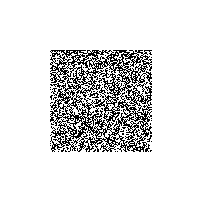

In [117]:
_ = day20_part2(puzzle.input, visualize=True)

This visualization shows only the even-numbered frames (using `[::2]`) because the resulting video is much more pleasant to watch.

<a name="day21"></a>
## Day 21: Quantum die game

- Part 1: With the deterministic 100-sided die, when either player reaches a score of 1000, what do you get if you multiply the score of the losing player by the number of times the die was rolled during the game?

- Part 2: With a quantum 3-sided dice and a win score of 21, find the player that wins in more universes; in how many universes does that player win?

---

Part 1 is straightforward.

For Part 2, I explored two different approaches:

1. Exhaustive **depth-first search**, accelerated by caching of computed values using `functools.lru_cache()`.

2. **Dynamic programming** over a 4D grid, where the axes are [`pos0`, `pos1`, `score0`, `score1`].

In either case, there are two players (`player0` and `player1`) and the search assumes that `player0` plays next.
The recursive call in approach 1 (or the 4D lookups in approach 2) then reverse the roles of `player0` and `player1` for the next turn by swapping `pos0` and `pos1` and swapping `score0` and `score1`.

For approach 2, one tricky part is ordering the dynamic-programming sweep through the 4D grid to ensure that all lookups are made to 4D cells that have already been computed.  This is addressed by sweeping the grid along a diagonal, in decreasing order of *total score* (`score0 + score1`).

I am able to achieve some vectorization using `numpy`.  However, the irregular array accesses based on `new_score0` look like an obstacle to efficiency.

In all cases, one small optimization is to precompute a `die_sum_distribution`
containing the counts of the sums of 3 die (rather than having 3 nested for loops that sum individual dice.).

In the end, the fastest solution is to apply `numba` to a non-vectorized version of approach 2 --- yielding an answer in just 20 ms.

In [13]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2021/day/21), `puzzle.input` has 2 lines:

Player 1 starting position: 1
Player 2 starting position: 3


The stored answers are: `{1: '897798', 2: '48868319769358'}`

In [14]:
s1 = """\
Player 1 starting position: 4
Player 2 starting position: 8
"""

In [15]:
def day21_part1(s):
  lines = s.splitlines()
  pos = [int(lines[0][27:]), int(lines[1][27:])]
  dice = itertools.cycle(range(1, 101))
  score = [0, 0]
  num_rolls = 0

  while True:
    for player in range(2):
      total = sum([next(dice), next(dice), next(dice)])
      num_rolls += 3
      pos[player] = (pos[player] - 1 + total) % 10 + 1
      score[player] += pos[player]
      if score[player] >= 1000:
        return num_rolls * score[1 - player]


check_eq(day21_part1(s1), 739785)
puzzle.verify(1, day21_part1)  # ~0 ms.

(Part 1: 0.000 s)


In [16]:
def day21a_part2(s):  # Simple 3 "for" loops and caching.
  lines = s.splitlines()
  pos = [int(lines[0][27:]), int(lines[1][27:])]

  @functools.lru_cache(maxsize=None)
  def compute(pos0, pos1, score0, score1):
    wins0 = wins1 = 0
    for roll0a in range(1, 4):
      for roll0b in range(1, 4):
        for roll0c in range(1, 4):
          new_pos0 = (pos0 + roll0a + roll0b + roll0c) % 10
          new_score0 = score0 + (new_pos0 + 1)
          if new_score0 >= 21:
            wins0 += 1
          else:
            d_wins1, d_wins0 = compute(pos1, new_pos0, score1, new_score0)
            wins0 += d_wins0
            wins1 += d_wins1
    return wins0, wins1

  wins0, wins1 = compute(pos[0] - 1, pos[1] - 1, 0, 0)
  return max(wins0, wins1)


check_eq(day21a_part2(s1), 444356092776315)
puzzle.verify(2, day21a_part2)  # ~240 ms.

(Part 2: 0.065 s)


In [17]:
def day21b_part2(s):  # Avoiding functools.lru_cache().
  lines = s.splitlines()
  pos = [int(lines[0][27:]), int(lines[1][27:])]
  die_sum_distribution = collections.Counter(
      sum(die) for die in itertools.product([1, 2, 3], repeat=3)
  )
  wins = np.zeros((21, 21, 10, 10, 2), np.int64)

  for total_score in range(40, -1, -1):
    for score0 in range(min(20, total_score), max(total_score - 21, -1), -1):
      score1 = total_score - score0
      for total, count in die_sum_distribution.items():
        for pos0 in range(10):
          for pos1 in range(10):
            new_pos0 = (pos0 + total) % 10
            new_score0 = score0 + (new_pos0 + 1)
            if new_score0 >= 21:
              wins[score0, score1, pos0, pos1, 0] += count
            else:
              wins[score0, score1, pos0, pos1, :] += (
                  count * wins[score1, new_score0, pos1, new_pos0, ::-1]
              )

  return wins[0, 0, pos[0] - 1, pos[1] - 1, :].max()


check_eq(day21b_part2(s1), 444356092776315)
puzzle.verify(2, day21b_part2)  # ~850 ms.

(Part 2: 0.403 s)


In [18]:
def day21c_part2(s):  # Numpy, vectorized on pos1.
  lines = s.splitlines()
  pos = [int(lines[0][27:]), int(lines[1][27:])]
  die_sum_distribution = tuple(
      collections.Counter(sum(die) for die in itertools.product([1, 2, 3], repeat=3)).items()
  )
  # Count of wins for [score0, score1, pos0, pos1, player]
  wins = np.zeros((21, 21, 10, 10, 2), np.int64)

  for total_score in range(40, -1, -1):
    for score0 in range(min(20, total_score), max(total_score - 21, -1), -1):
      score1 = total_score - score0
      for total, count in die_sum_distribution:
        for pos0 in range(10):
          new_pos0 = (pos0 + total) % 10
          new_score0 = score0 + (new_pos0 + 1)
          if new_score0 >= 21:
            wins[score0, score1, pos0, :, 0] += count
          else:
            wins[score0, score1, pos0, :, :] += count * wins[score1, new_score0, :, new_pos0, ::-1]

  return wins[0, 0, pos[0] - 1, pos[1] - 1].max()


check_eq(day21c_part2(s1), 444356092776315)
puzzle.verify(2, day21c_part2)  # ~130 ms.

(Part 2: 0.066 s)


(Part 2: 0.017 s)


""

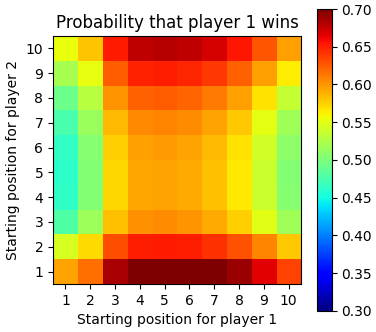

In [20]:
def day21d_part2(s, *, win_score=21, visualize=False):  # Most compact.
  lines = s.splitlines()
  pos0, pos1 = int(lines[0][27:]) - 1, int(lines[1][27:]) - 1
  die_sum_distribution = tuple(
      collections.Counter(sum(die) for die in itertools.product([1, 2, 3], repeat=3)).items()
  )

  @functools.lru_cache(maxsize=None)
  def compute(pos0, pos1, score0, score1):
    wins0 = wins1 = 0
    for total, count in die_sum_distribution:
      new_pos0 = (pos0 + total) % 10
      new_score0 = score0 + (new_pos0 + 1)
      if new_score0 >= win_score:
        wins0 += count
      else:
        d_wins1, d_wins0 = compute(pos1, new_pos0, score1, new_score0)
        wins0 += d_wins0 * count
        wins1 += d_wins1 * count
    return wins0, wins1

  if visualize:
    win0 = np.array(
        [
            [
                wins0 / (wins0 + wins1)
                for pos1 in range(10)
                for wins0, wins1 in [compute(pos0, pos1, 0, 0)]
            ]
            for pos0 in range(10)
        ]
    )
    hh.display_html(
        f'Start positions for max probability of player 1 win:'
        f' {np.argwhere(win0 == win0.max())[0] + 1} = {win0.max():.3f}'
    )
    hh.display_html(
        f'Start positions for min probability of player 1 win:'
        f' {np.argwhere(win0 == win0.min())[0] + 1} = {win0.min():.3f}'
    )
    hh.display_html(f'Player 1 win probability at [1 1]: {win0[0, 0]:.3f}')
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    pos = ax.imshow(
        win0, vmin=0.3, vmax=0.7, cmap='jet', origin='lower', extent=(0.5, 10.5, 0.5, 10.5)
    )
    ax.set(
        title='Probability that player 1 wins',
        xlabel='Starting position for player 1',
        ylabel='Starting position for player 2',
        xticks=np.arange(1, 11),
        yticks=np.arange(1, 11),
    )
    fig.colorbar(pos, ax=ax)
    # fig.tight_layout(pad=0)  # It does not properly handle the colorbar.
    image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
    plt.close(fig)
    return image

  return max(*compute(pos0, pos1, 0, 0))


check_eq(day21d_part2(s1), 444356092776315)
puzzle.verify(2, day21d_part2)  # ~50 ms.

# The conclusion is that starting first is a big advantage, but there are some
# start locations where player 2 still has an advantage.
media.show_image(day21d_part2(puzzle.input, visualize=True), border=True)

# If the winning score is increased from 21 to 100, there is still a 5% edge
# in starting first with the best position.
# media.show_image(day21d_part2(puzzle.input, win_score=100, visualize=True))

In [20]:
# Fastest, using numba.
@numba.njit
def day21_part2_func(pos, die_sum_distribution):
  wins = np.zeros((21, 21, 10, 10, 2), np.int64)
  for total_score in range(40, -1, -1):
    for score0 in range(min(20, total_score), max(total_score - 21, -1), -1):
      score1 = total_score - score0
      for pos0 in range(10):
        for pos1 in range(10):
          for total, count in die_sum_distribution:
            new_pos0 = (pos0 + total) % 10
            new_score0 = score0 + (new_pos0 + 1)
            if new_score0 >= 21:
              wins[score0, score1, pos0, pos1, 0] += count
            else:
              wins[score0, score1, pos0, pos1, 0] += (
                  count * wins[score1, new_score0, pos1, new_pos0, 1]
              )
              wins[score0, score1, pos0, pos1, 1] += (
                  count * wins[score1, new_score0, pos1, new_pos0, 0]
              )

  return wins[0, 0, pos[0], pos[1], :].max()


def day21_part2(s):
  lines = s.splitlines()
  pos = np.array([lines[0][27:], lines[1][27:]], int) - 1
  die_sum_distribution = np.array(
      list(collections.Counter(sum(die) for die in itertools.product([1, 2, 3], repeat=3)).items())
  )
  return day21_part2_func(pos, die_sum_distribution)


check_eq(day21_part2(s1), 444356092776315)
puzzle.verify(2, day21_part2)  # ~21 ms.

(Part 2: 0.001 s)


<a name="day22"></a>
## Day 22: CSG on cuboids

- Part 1: Considering only cubes in the region `x=-50..50,y=-50..50,z=-50..50`, how many cubes are on?

- Part 2: Considering all cubes, how many cubes are on?

---

This is a really interesting problem.

My first thought was to consider a divide-and-conquer approach on the 3D domain, perhaps using an octree data structure, as worked well on the [2018 day 23 puzzle](https://adventofcode.com/2018/day/23).
However, it is impractical here because it would result in too many refined octree cells.

**Approach 1**:
My first approach considers a "constructive solid geometry" (CSG) construction that adaptively partitions the input boxes into smaller boxes.  The goal is to maintain a **disjoint union of boxes** that contain all cubes that are currently "on".

The algorithm is as follows.
For each new box, we process all of the currently active boxes to subtract any part that overlaps the new box.
This subtraction is achieved by subdividing the overlapping box into up to 27 sub-boxes.  Each sub-box is either entirely inside or entirely outside the new box.  We discard it if it is inside.
Finally, we add the new box to the active list if its state is "on" (as oppposed to "off").

To speed up the computation, I explore subdividing each overlapping box into fewer sub-boxes, by considering one axis at a time in a heuristic order based on the box dimensions.

I also explored using a K-d tree to speed up the search for overlapping boxes; the resulting improvement is small for this input size and prevents subsequent `numba` acceleration.

**Approach 2**:
I was surprised to see the simple approach in [Neal Wu's video](https://www.youtube.com/watch?v=YKpViLcTp64).
The idea is to **sort the `start, stop` coordinates** of the input boxes (separately on each axis), and use the outer-product of these coordinates to partition the 3D space into a grid of small boxes.
For each input box, we identify the sub-grid of small boxes that it contains, and modify their state.

I adapt this approach in `numpy` (using the ever-useful `np.unique()` function) and achieve compact code, which automatically generalizes to inputs of arbitrary dimension.  However, the computation is slower than the CSG approach, taking about 2700 ms vs. 95 ms.

In [21]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2021/day/22), `puzzle.input` has 420 lines:

on x=-48..-2,y=-16..31,z=-3..41
on x=-12..39,y=-38..9,z=-28..21
on x=-16..33,y=-33..21,z=-40..8
on x=-14..30,y=-29..18,z=-18..29
on x=-33..14,y=-36..12,z=-21..28
on x=-34..20,y=-30..20,z=-13..33
on x=-43..11,y=1..48,z=-28..25
on x=-23..22,y=-12..32,z=-29..18
 ...
on x=33576..48724,y=-31260..-12186,z=-75566..-46019
off x=43325..66519,y=-60708..-36823,z=-54384..-32330
off x=72390..92217,y=-11255..19475,z=21818..35508
on x=27341..40606,y=29154..65657,z=52597..75340


The stored answers are: `{1: '524792', 2: '1213461324555691'}`

In [22]:
s1 = """\
on x=10..12,y=10..12,z=10..12
on x=11..13,y=11..13,z=11..13
off x=9..11,y=9..11,z=9..11
on x=10..10,y=10..10,z=10..10
"""

s2 = """\
on x=-20..26,y=-36..17,z=-47..7
on x=-20..33,y=-21..23,z=-26..28
on x=-22..28,y=-29..23,z=-38..16
on x=-46..7,y=-6..46,z=-50..-1
on x=-49..1,y=-3..46,z=-24..28
on x=2..47,y=-22..22,z=-23..27
on x=-27..23,y=-28..26,z=-21..29
on x=-39..5,y=-6..47,z=-3..44
on x=-30..21,y=-8..43,z=-13..34
on x=-22..26,y=-27..20,z=-29..19
off x=-48..-32,y=26..41,z=-47..-37
on x=-12..35,y=6..50,z=-50..-2
off x=-48..-32,y=-32..-16,z=-15..-5
on x=-18..26,y=-33..15,z=-7..46
off x=-40..-22,y=-38..-28,z=23..41
on x=-16..35,y=-41..10,z=-47..6
off x=-32..-23,y=11..30,z=-14..3
on x=-49..-5,y=-3..45,z=-29..18
off x=18..30,y=-20..-8,z=-3..13
on x=-41..9,y=-7..43,z=-33..15
on x=-54112..-39298,y=-85059..-49293,z=-27449..7877
on x=967..23432,y=45373..81175,z=27513..53682
"""

s3 = """\
on x=-5..47,y=-31..22,z=-19..33
on x=-44..5,y=-27..21,z=-14..35
on x=-49..-1,y=-11..42,z=-10..38
on x=-20..34,y=-40..6,z=-44..1
off x=26..39,y=40..50,z=-2..11
on x=-41..5,y=-41..6,z=-36..8
off x=-43..-33,y=-45..-28,z=7..25
on x=-33..15,y=-32..19,z=-34..11
off x=35..47,y=-46..-34,z=-11..5
on x=-14..36,y=-6..44,z=-16..29
on x=-57795..-6158,y=29564..72030,z=20435..90618
on x=36731..105352,y=-21140..28532,z=16094..90401
on x=30999..107136,y=-53464..15513,z=8553..71215
on x=13528..83982,y=-99403..-27377,z=-24141..23996
on x=-72682..-12347,y=18159..111354,z=7391..80950
on x=-1060..80757,y=-65301..-20884,z=-103788..-16709
on x=-83015..-9461,y=-72160..-8347,z=-81239..-26856
on x=-52752..22273,y=-49450..9096,z=54442..119054
on x=-29982..40483,y=-108474..-28371,z=-24328..38471
on x=-4958..62750,y=40422..118853,z=-7672..65583
on x=55694..108686,y=-43367..46958,z=-26781..48729
on x=-98497..-18186,y=-63569..3412,z=1232..88485
on x=-726..56291,y=-62629..13224,z=18033..85226
on x=-110886..-34664,y=-81338..-8658,z=8914..63723
on x=-55829..24974,y=-16897..54165,z=-121762..-28058
on x=-65152..-11147,y=22489..91432,z=-58782..1780
on x=-120100..-32970,y=-46592..27473,z=-11695..61039
on x=-18631..37533,y=-124565..-50804,z=-35667..28308
on x=-57817..18248,y=49321..117703,z=5745..55881
on x=14781..98692,y=-1341..70827,z=15753..70151
on x=-34419..55919,y=-19626..40991,z=39015..114138
on x=-60785..11593,y=-56135..2999,z=-95368..-26915
on x=-32178..58085,y=17647..101866,z=-91405..-8878
on x=-53655..12091,y=50097..105568,z=-75335..-4862
on x=-111166..-40997,y=-71714..2688,z=5609..50954
on x=-16602..70118,y=-98693..-44401,z=5197..76897
on x=16383..101554,y=4615..83635,z=-44907..18747
off x=-95822..-15171,y=-19987..48940,z=10804..104439
on x=-89813..-14614,y=16069..88491,z=-3297..45228
on x=41075..99376,y=-20427..49978,z=-52012..13762
on x=-21330..50085,y=-17944..62733,z=-112280..-30197
on x=-16478..35915,y=36008..118594,z=-7885..47086
off x=-98156..-27851,y=-49952..43171,z=-99005..-8456
off x=2032..69770,y=-71013..4824,z=7471..94418
on x=43670..120875,y=-42068..12382,z=-24787..38892
off x=37514..111226,y=-45862..25743,z=-16714..54663
off x=25699..97951,y=-30668..59918,z=-15349..69697
off x=-44271..17935,y=-9516..60759,z=49131..112598
on x=-61695..-5813,y=40978..94975,z=8655..80240
off x=-101086..-9439,y=-7088..67543,z=33935..83858
off x=18020..114017,y=-48931..32606,z=21474..89843
off x=-77139..10506,y=-89994..-18797,z=-80..59318
off x=8476..79288,y=-75520..11602,z=-96624..-24783
on x=-47488..-1262,y=24338..100707,z=16292..72967
off x=-84341..13987,y=2429..92914,z=-90671..-1318
off x=-37810..49457,y=-71013..-7894,z=-105357..-13188
off x=-27365..46395,y=31009..98017,z=15428..76570
off x=-70369..-16548,y=22648..78696,z=-1892..86821
on x=-53470..21291,y=-120233..-33476,z=-44150..38147
off x=-93533..-4276,y=-16170..68771,z=-104985..-24507
"""

In [23]:
def day22a_part1(s):  # Initial specialized solution for part 1.
  lines = s.splitlines()
  shape = 101, 101, 101
  grid = np.full(shape, 0, int)
  for line in lines:
    state, x1, x2, y1, y2, z1, z2 = parse.parse('{} x={:d}..{:d},y={:d}..{:d},z={:d}..{:d}', line)
    if not all(-50 <= c <= 50 for c in [x1, x2, y1, y2, z1, z2]):
      continue
    x1 += 50
    x2 += 50
    y1 += 50
    y2 += 50
    z1 += 50
    z2 += 50
    grid[x1 : x2 + 1, y1 : y2 + 1, z1 : z2 + 1] = 1 if state == 'on' else 0

  return np.count_nonzero(grid)


check_eq(day22a_part1(s1), 39)
check_eq(day22a_part1(s2), 590784)
check_eq(day22a_part1(s3), 474140)
puzzle.verify(1, day22a_part1)  # ~42 ms.

(Part 1: 0.016 s)


In [24]:
def day22b(s, *, part2=False):  # Using 3D grid over unique range coordinates.
  # Approach inspired from https://www.youtube.com/watch?v=YKpViLcTp64.
  lines = s.splitlines()
  states = [l[:3].strip() == 'on' for l in lines]
  boxes = np.array(
      [
          [list(map(int, range_[2:].split('..'))) for range_ in l[3:].strip().split(',')]
          for l in lines
      ]
  )
  if not part2:
    boxes = boxes[((boxes[..., 0] >= -50) & (boxes[..., 1] <= 50)).all(axis=1)]
  boxes[..., 1] += 1  # Convert [min, max] to [start, stop].
  coords, inverses = zip(
      *(np.unique(boxes[:, c], return_inverse=True) for c in range(boxes.shape[1]))
  )
  is_on = np.full([len(coord) - 1 for coord in coords], False)
  for state, *ranges in zip(states, *(a.reshape(-1, 2) for a in inverses)):
    is_on[tuple(slice(start, stop) for start, stop in ranges)] = state
  side_lengths = [np.diff(coord) for coord in coords]
  # return np.sum(is_on * functools.reduce(np.multiply.outer, side_lengths))
  return np.einsum('ijk,i,j,k', is_on, *side_lengths)  # Uses less memory.


check_eq(day22b(s1), 39)
check_eq(day22b(s2), 590784)
check_eq(day22b(s3), 474140)
puzzle.verify(1, day22b)  # ~8 ms.

day22b_part2 = functools.partial(day22b, part2=True)
check_eq(day22b_part2(s3), 2758514936282235)  # ~14 ms.
puzzle.verify(2, day22b_part2)  # ~2700 ms.

(Part 1: 0.001 s)
(Part 2: 1.886 s)


In [25]:
def day22c(s, *, part2=False):  # Using CSG of boxes.
  # Adapted simpler logic of https://github.com/shaeberling/euler/blob/master/kotlin/src/com/s13g/aoc/aoc2021/Day22.kt.
  lines = s.splitlines()
  state_cuboids = []
  for line in lines:
    state = line[:3].strip()
    cuboid = tuple(
        tuple(map(int, range_[2:].split('..'))) for range_ in line[3:].strip().split(',')
    )
    if all(-50 <= c <= 50 for range_ in cuboid for c in range_) or part2:
      state_cuboids.append((state == 'on', cuboid))

  def inside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] >= bx[0] and ay[0] >= by[0] and az[0] >= bz[0]) and (
        ax[1] <= bx[1] and ay[1] <= by[1] and az[1] <= bz[1]
    )

  def outside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] > bx[1] or ay[0] > by[1] or az[0] > bz[1]) or (
        ax[1] < bx[0] or ay[1] < by[0] or az[1] < bz[0]
    )

  def subdivide_a_subtracting_b(a, b):  # Slow because up to 27 subcells.
    coords = [sorted((a[c][0], a[c][1], b[c][0], b[c][1])) for c in range(3)]
    intervals = [
        [(c1, c2) for c1, c2 in ((x0, x1 - 1), (x1, x2), (x2 + 1, x3)) if c1 <= c2]
        for x0, x1, x2, x3 in coords
    ]
    for subcell in itertools.product(*intervals):
      if inside(subcell, a) and not inside(subcell, b):
        yield subcell

  cells: set[tuple[int, ...]] = set()  # Disjoint union of "on" cubes.

  # Subtract each cuboid from existing cells (potentially subdividing them).
  for state, cuboid in state_cuboids:
    cells_to_add, cells_to_delete = set(), set()
    for cell in cells:
      if outside(cell, cuboid):
        continue
      cells_to_delete.add(cell)
      if not inside(cell, cuboid):
        cells_to_add.update(subdivide_a_subtracting_b(cell, cuboid))
    if state:
      cells_to_add.add(cuboid)
    cells = (cells - cells_to_delete) | cells_to_add

  return sum((np.diff(cell).T[0] + 1).prod() for cell in cells)


check_eq(day22c(s1), 39)
check_eq(day22c(s2), 590784)
check_eq(day22c(s3), 474140)
puzzle.verify(1, day22c)  # ~25 ms.

day22c_part2 = functools.partial(day22c, part2=True)
check_eq(day22c_part2(s3), 2758514936282235)
puzzle.verify(2, day22c_part2)  # ~1350 ms.

(Part 1: 0.010 s)
(Part 2: 0.389 s)


In [26]:
def day22d(s, *, part2=False):  # Faster by reducing CSG fragment count.
  lines = s.splitlines()
  state_cuboids = []
  for line in lines:
    state = line[:3].strip()
    cuboid = tuple(
        tuple(map(int, range_[2:].split('..'))) for range_ in line[3:].strip().split(',')
    )
    if all(-50 <= c <= 50 for range_ in cuboid for c in range_) or part2:
      state_cuboids.append((state == 'on', cuboid))

  def inside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] >= bx[0] and ay[0] >= by[0] and az[0] >= bz[0]) and (
        ax[1] <= bx[1] and ay[1] <= by[1] and az[1] <= bz[1]
    )

  def outside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] > bx[1] or ay[0] > by[1] or az[0] > bz[1]) or (
        ax[1] < bx[0] or ay[1] < by[0] or az[1] < bz[0]
    )

  def replace(tuple_, index, value):
    return tuple_[:index] + (value,) + tuple_[index + 1 :]

  def subdivide_a_subtracting_b(a, b):  # Faster; smaller number of subcells.
    boxes = [a]
    finalized: list[tuple[int, ...]] = []
    # dims = np.argsort([c1 - c2 for c1, c2 in a])  # Split big dims first.
    dims = sorted(range(3), key=lambda dim: a[dim][0] - a[dim][1])
    for dim in dims:
      new_boxes = []
      for box in boxes:
        (a1, a2), (b1, b2) = box[dim], b[dim]
        # assert not inside(box, b) and not outside(box, b)
        if a1 >= b1 and a2 <= b2:
          new_boxes.append(box)  # No subdivision along this dimension.
          continue
        if a1 < b1 and a2 > b2:
          finalized.extend((replace(box, dim, (a1, b1 - 1)), replace(box, dim, (b2 + 1, a2))))
          box2 = replace(box, dim, (b1, b2))
        elif a1 >= b1 and a2 > b2:
          box2 = replace(box, dim, (a1, b2))
          finalized.append(replace(box, dim, (b2 + 1, a2)))
        else:  # a1 < b1 and a2 <= b2:
          finalized.append(replace(box, dim, (a1, b1 - 1)))
          box2 = replace(box, dim, (b1, a2))
        if outside(box2, b):
          finalized.append(box2)
        elif not inside(box2, b):
          new_boxes.append(box2)
      boxes = new_boxes
    return finalized

  # Disjoint union of "on" cubes.
  cells: set[tuple[tuple[int, int, int], tuple[int, int, int]]] = set()

  # Subtract each cuboid from existing cells (potentially subdividing them).
  for state, cuboid in state_cuboids:
    cells_to_add, cells_to_delete = set(), set()
    for cell in cells:
      if outside(cell, cuboid):
        continue
      cells_to_delete.add(cell)
      if not inside(cell, cuboid):
        cells_to_add.update(subdivide_a_subtracting_b(cell, cuboid))
    if state:
      cells_to_add.add(cuboid)
    cells = (cells - cells_to_delete) | cells_to_add

  return sum((np.diff(cell).T[0] + 1).prod() for cell in cells)


check_eq(day22d(s1), 39)
check_eq(day22d(s2), 590784)
check_eq(day22d(s3), 474140)
puzzle.verify(1, day22d)  # ~9 ms.

day22d_part2 = functools.partial(day22d, part2=True)
check_eq(day22d_part2(s3), 2758514936282235)
puzzle.verify(2, day22d_part2)  # ~380 ms.

(Part 1: 0.003 s)
(Part 2: 0.126 s)


In [27]:
class Kdtree(Generic[_T]):
  """Spatial structure that splits space using hyperplanes in successive dims.

  In this K-D tree implementation, the original bounding volume is the unit
  hypercube, and the hyperplane always splits the current dimension at the
  midpoint of the current range.  Each element is represented using a
  bounding box.  When an element is entered into the tree, it is pushed down
  the tree until the box straddles the two child nodes.  Large elements may be
  pushed down both children if the allow_duplication threshold is set.
  Adapted from
  https://github.com/hhoppe/Mesh-processing-library/blob/master/libHh/Kdtree.h
  """

  @dataclasses.dataclass
  class Entry(Generic[_T2]):
    bb0: tuple[float, ...]
    bb1: tuple[float, ...]
    data: _T2 | None

  @dataclasses.dataclass
  class Node:
    axis: int  # Hyperplane axis, satisfying 0 <= axis < ndim.
    value: float  # Hyperplane coordinate (in [0.0, 1.0]).
    entries: list[int] = dataclasses.field(default_factory=list)
    l: int = -1  # Node index for subtree with low values.
    h: int = -1  # Node index for subtree with high values.

  def __init__(self, ndim: int, max_level: int = 8):
    """Creates K-d tree over unit hypercube with `ndim` dimensions."""
    assert ndim > 0 and max_level > 0
    self.ndim = ndim
    self.max_level = max_level
    self.entries: list[Kdtree.Entry[_T]] = []
    self.nodes: list[Kdtree.Node] = []

  def add(self, bb0: tuple[float, ...], bb1: tuple[float, ...], data: _T) -> None:
    """Stores the box-bounded element."""
    assert all(0.0 <= b0 <= b1 <= 1.0 for b0, b1 in zip(bb0, bb1))
    entry_index = len(self.entries)
    self.entries.append(self.Entry[_T](bb0, bb1, data))
    node_index = 0
    values = [0.5] * self.ndim
    level = 0
    inc = 0.5
    axis = 0
    while True:
      value = values[axis]
      if node_index == len(self.nodes):
        self.nodes.append(self.Node(axis, value))
      if axis == 0:
        level += 1
        if level == self.max_level:
          break
        inc *= 0.5
      want_l = bb0[axis] <= value
      want_h = bb1[axis] >= value
      if want_l and want_h:
        break
      if want_l:
        if self.nodes[node_index].l < 0:
          self.nodes[node_index].l = len(self.nodes)
        node_index = self.nodes[node_index].l
        values[axis] -= inc
      else:
        if self.nodes[node_index].h < 0:
          self.nodes[node_index].h = len(self.nodes)
        node_index = self.nodes[node_index].h
        values[axis] += inc
      axis = axis + 1 if axis < self.ndim - 1 else 0

    self.nodes[node_index].entries.append(entry_index)

  def remove(self, bb0: tuple[float, ...], bb1: tuple[float, ...], data: _T) -> None:
    """Removes the previously added element."""
    assert all(0.0 <= b0 <= b1 <= 1.0 for b0, b1 in zip(bb0, bb1))
    # entry = self.Entry[_T](bb0, bb1, data)
    entry_index = None
    node_index = 0
    level = 0
    while True:
      node = self.nodes[node_index]
      axis = node.axis
      if axis == 0:
        level += 1
        if level == self.max_level:
          break
      value = node.value
      want_l = bb0[axis] <= value
      want_h = bb1[axis] >= value
      if want_l and want_h:
        break
      if want_l:
        node_index = node.l
      else:
        node_index = node.h

    node = self.nodes[node_index]
    if entry_index is None:
      for entry_index2 in node.entries:
        # if self.entries[entry_index2] == entry:
        # Problem is that default __eq__ involves slow <string>:2(__eq__).
        entry2 = self.entries[entry_index2]
        if entry2.bb0 == bb0 and entry2.bb1 == bb1 and entry2.data == data:
          entry_index = entry_index2
          self.entries[entry_index] = self.Entry[_T]((-1.0,) * self.ndim, (-1.0,) * self.ndim, None)
          break
    assert entry_index is not None
    node.entries.remove(entry_index)

  def search(
      self, bb0: tuple[float, ...], bb1: tuple[float, ...]
  ) -> Iterator[tuple[tuple[float, ...], tuple[float, ...], _T]]:
    """Yields elements that overlap the bounding-box search range."""
    assert all(0.0 <= b0 <= b1 <= 1.0 for b0, b1 in zip(bb0, bb1))

    def recurse(node_index: int) -> Iterator[tuple[tuple[float, ...], tuple[float, ...], _T]]:
      while True:
        node = self.nodes[node_index]
        for entry_index in node.entries:
          entry = self.entries[entry_index]
          for e0, e1, b0, b1 in zip(entry.bb0, entry.bb1, bb0, bb1):
            if e0 > b1 or e1 < b0:
              break
          else:
            yield entry.bb0, entry.bb1, typing.cast(_T, entry.data)
        axis = node.axis
        value = node.value
        want_l = node.l >= 0 and bb0[axis] <= value
        want_h = node.h >= 0 and bb1[axis] >= value
        if want_l and want_h:
          yield from recurse(node.l)  # Single recursion.
          node_index = node.h
        elif want_l:
          node_index = node.l
        elif want_h:
          node_index = node.h
        else:
          break

    if self.nodes:
      yield from recurse(0)


def test_kdtree():
  kdtree = Kdtree[str](ndim=1)
  kdtree.add((0.1,), (0.2,), 'elem1')
  kdtree.add((0.7,), (0.8,), 'elem2')
  kdtree.add((0.4,), (0.6,), 'elem3')
  check_eq(list(kdtree.search((0.05,), (0.15,))), [((0.1,), (0.2,), 'elem1')])
  check_eq({r[2] for r in kdtree.search((0.65,), (0.75,))}, {'elem2'})
  check_eq({r[2] for r in kdtree.search((0.55,), (0.72,))}, {'elem2', 'elem3'})
  check_eq({r[2] for r in kdtree.search((0.15,), (0.95,))}, {'elem1', 'elem2', 'elem3'})
  kdtree.remove((0.7,), (0.8,), 'elem2')
  check_eq({r[2] for r in kdtree.search((0.65,), (0.75,))}, set())
  check_eq({r[2] for r in kdtree.search((0.55,), (0.72,))}, {'elem3'})
  check_eq({r[2] for r in kdtree.search((0.15,), (0.95,))}, {'elem1', 'elem3'})

  kdtree = Kdtree[str](ndim=2)
  kdtree.add((0.1, 0.15), (0.2, 0.25), 'elem1')
  kdtree.add((0.7, 0.3), (0.75, 0.35), 'elem2')
  kdtree.add((0.2, 0.8), (0.25, 0.85), 'elem3')
  check_eq(list(kdtree.search((0.05, 0.1), (0.15, 0.2))), [((0.1, 0.15), (0.2, 0.25), 'elem1')])
  check_eq({r[2] for r in kdtree.search((0.65, 0.25), (0.7, 0.3))}, {'elem2'})
  check_eq({r[2] for r in kdtree.search((0.15, 0.15), (0.2, 0.8))}, {'elem1', 'elem3'})
  check_eq({r[2] for r in kdtree.search((0.1, 0.1), (0.9, 0.9))}, {'elem1', 'elem2', 'elem3'})


test_kdtree()

In [28]:
def day22e(s, *, part2=False):  # Using Kdtree.
  lines = s.splitlines()
  state_cuboids = []
  for line in lines:
    state = line[:3].strip()
    cuboid = tuple(
        tuple(map(int, range_[2:].split('..'))) for range_ in line[3:].strip().split(',')
    )
    if all(-50 <= c <= 50 for range_ in cuboid for c in range_) or part2:
      state_cuboids.append((state == 'on', cuboid))
  diam, diam2 = 300_000.0, 300_000.5

  def inside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] >= bx[0] and ay[0] >= by[0] and az[0] >= bz[0]) and (
        ax[1] <= bx[1] and ay[1] <= by[1] and az[1] <= bz[1]
    )

  def outside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] > bx[1] or ay[0] > by[1] or az[0] > bz[1]) or (
        ax[1] < bx[0] or ay[1] < by[0] or az[1] < bz[0]
    )

  def replace(tuple_, index, value):
    return tuple_[:index] + (value,) + tuple_[index + 1 :]

  def to_bbox(a):
    ax, ay, az = a
    return (
        (ax[0] / diam + 0.5, ay[0] / diam + 0.5, az[0] / diam + 0.5),
        (ax[1] / diam + 0.5, ay[1] / diam + 0.5, az[1] / diam + 0.5),
    )

  def from_bbox(bb0, bb1):
    return (
        (int((bb0[0] - 0.5) * diam2), int((bb1[0] - 0.5) * diam2)),
        (int((bb0[1] - 0.5) * diam2), int((bb1[1] - 0.5) * diam2)),
        (int((bb0[2] - 0.5) * diam2), int((bb1[2] - 0.5) * diam2)),
    )

  def subdivide_a_subtracting_b(a, b):  # Faster; smaller number of subcells.
    boxes = [a]
    finalized: list[tuple[tuple[int, int, int], tuple[int, int, int]]] = []
    # dims = np.argsort([c1 - c2 for c1, c2 in a])  # Split big dims first.
    dims = sorted(range(3), key=lambda dim: a[dim][0] - a[dim][1])
    for dim in dims:
      new_boxes = []
      for box in boxes:
        (a1, a2), (b1, b2) = box[dim], b[dim]
        # assert not inside(box, b) and not outside(box, b)
        if a1 >= b1 and a2 <= b2:
          new_boxes.append(box)  # No subdivision along this dimension.
          continue
        if a1 < b1 and a2 > b2:
          finalized.extend((replace(box, dim, (a1, b1 - 1)), replace(box, dim, (b2 + 1, a2))))
          box2 = replace(box, dim, (b1, b2))
        elif a1 >= b1 and a2 > b2:
          box2 = replace(box, dim, (a1, b2))
          finalized.append(replace(box, dim, (b2 + 1, a2)))
        else:  # a1 < b1 and a2 <= b2:
          finalized.append(replace(box, dim, (a1, b1 - 1)))
          box2 = replace(box, dim, (b1, a2))
        if outside(box2, b):
          finalized.append(box2)
        elif not inside(box2, b):
          new_boxes.append(box2)
      boxes = new_boxes
    return finalized

  # Entries are disjoint union of "on" cubes.
  kdtree = Kdtree[int](ndim=3)

  for state, cuboid in state_cuboids:
    cells_to_add, cells_to_delete = set(), set()
    for bb0, bb1, _ in kdtree.search(*to_bbox(cuboid)):
      cell = from_bbox(bb0, bb1)
      if outside(cell, cuboid):
        continue
      cells_to_delete.add(cell)
      if not inside(cell, cuboid):
        cells_to_add.update(subdivide_a_subtracting_b(cell, cuboid))
    if state:
      cells_to_add.add(cuboid)
    for cell in cells_to_delete:
      kdtree.remove(*to_bbox(cell), None)  # type: ignore[call-arg]
    for cell in cells_to_add:
      kdtree.add(*to_bbox(cell), None)  # type: ignore[call-arg]

  cells = [from_bbox(entry.bb0, entry.bb1) for entry in kdtree.entries if entry.bb0[0] >= 0.0]
  return (np.diff(list(cells)) + 1)[..., 0].prod(axis=-1).sum()


check_eq(day22e(s1), 39)
check_eq(day22e(s2), 590784)
check_eq(day22e(s3), 474140)
puzzle.verify(1, day22e)  # ~14 ms.

day22e_part2 = functools.partial(day22e, part2=True)
check_eq(day22e_part2(s3), 2758514936282235)
puzzle.verify(2, day22e_part2)  # ~330 ms vs. previous ~380 ms.
# It looks like the overhead of maintaining the Kdtree is too great.

(Part 1: 0.008 s)
(Part 2: 0.164 s)


In [29]:
# Mangled numba version of day22d; fastest.
@numba.njit
def day22_func(states, cuboids):
  def inside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] >= bx[0] and ay[0] >= by[0] and az[0] >= bz[0]) and (
        ax[1] <= bx[1] and ay[1] <= by[1] and az[1] <= bz[1]
    )

  def outside(a, b):
    (ax, ay, az), (bx, by, bz) = a, b
    return (ax[0] > bx[1] or ay[0] > by[1] or az[0] > bz[1]) or (
        ax[1] < bx[0] or ay[1] < by[0] or az[1] < bz[0]
    )

  def replace(tuple_, index, value):
    if using_numba:
      setitem = numba.cpython.unsafe.tuple.tuple_setitem
      return setitem(tuple_, index, value)  # pylint: disable=no-value-for-parameter
    return tuple_[:index] + (value,) + tuple_[index + 1 :]

  def to_tuple(array):
    if using_numba:
      to_fixed = numba.np.unsafe.ndarray.to_fixed_tuple  # pylint: disable=no-member
      return to_fixed(array[0], 2), to_fixed(array[1], 2), to_fixed(array[2], 2)
    return tuple(array[0]), tuple(array[1]), tuple(array[2])

  def subdivide_a_subtracting_b(a, b):  # Faster; smaller number of subcells.
    boxes = [a]
    finalized: list[tuple[tuple[int, int, int], tuple[int, int, int]]] = []
    dims = np.argsort(np.array([a[0][0] - a[0][1], a[1][0] - a[1][1], a[2][0] - a[2][1]]))
    for dim in dims:
      new_boxes = []
      for box in boxes:
        (a1, a2), (b1, b2) = box[dim], b[dim]
        # assert not inside(box, b) and not outside(box, b)
        if a1 >= b1 and a2 <= b2:
          new_boxes.append(box)  # No subdivision along this dimension.
          continue
        if a1 < b1 and a2 > b2:
          finalized.extend((replace(box, dim, (a1, b1 - 1)), replace(box, dim, (b2 + 1, a2))))
          box2 = replace(box, dim, (b1, b2))
        elif a1 >= b1 and a2 > b2:
          box2 = replace(box, dim, (a1, b2))
          finalized.append(replace(box, dim, (b2 + 1, a2)))
        else:  # a1 < b1 and a2 <= b2:
          finalized.append(replace(box, dim, (a1, b1 - 1)))
          box2 = replace(box, dim, (b1, a2))
        if outside(box2, b):
          finalized.append(box2)
        elif not inside(box2, b):
          new_boxes.append(box2)
      boxes = new_boxes
    return finalized

  # Disjoint union of "on" cubes.
  # pylint: disable-next=consider-using-set-comprehension
  cells = set([to_tuple(cuboids[0]) for _ in range(0)])  # Typed empty set.

  for state, cuboid_array in zip(states, cuboids):
    cuboid = to_tuple(cuboid_array)
    cells_to_add, cells_to_delete = [], []
    for cell in cells:
      if outside(cell, cuboid):
        continue
      cells_to_delete.append(cell)
      if not inside(cell, cuboid):
        cells_to_add.extend(subdivide_a_subtracting_b(cell, cuboid))

    if state:
      cells_to_add.append(cuboid)
    cells = cells.difference(set(cells_to_delete)).union(set(cells_to_add))

  total = 0
  for cell in cells:
    volume = 1
    for c in range(3):
      volume *= cell[c][1] - cell[c][0] + 1
    total += volume
  return total


def day22(s, *, part2=False):
  lines = s.splitlines()
  states, cuboids = [], []
  for line in lines:
    state = line[:3].strip()
    cuboid = tuple(
        tuple(map(int, range_[2:].split('..'))) for range_ in line[3:].strip().split(',')
    )
    if all(-50 <= c <= 50 for range_ in cuboid for c in range_) or part2:
      states.append(state == 'on')
      cuboids.append(cuboid)

  return day22_func(np.array(states), np.array(cuboids))


check_eq(day22(s1), 39)  # ~4 s for numba compilation.
check_eq(day22(s2), 590784)
check_eq(day22(s3), 474140)
puzzle.verify(1, day22)  # ~30 ms.

day22_part2 = functools.partial(day22, part2=True)
check_eq(day22_part2(s3), 2758514936282235)
puzzle.verify(2, day22_part2)  # ~80 ms (often slower).

(Part 1: 0.002 s)
(Part 2: 0.018 s)


<a name="day23"></a>
## Day 23: Shuffle between rooms

- Part 1: What is the least energy required to organize the amphipods?

- Part 2: After inserting two more lines to make rooms twice as large, what is the least energy?

---

My approach is to represent the *state* as a **tuple of characters**, with one character for each of the legal positions (i.e., 7 elements for the hallway and 2 or 4 elements for each of the 4 rooms).

I explored two approaches:

1. **Exhaustive** exploration of state moves (using **depth-first search**) to compute the minimum cost from the current state to the end state, with `functools.lru_cache` to cache the obtained cost values.  This solution takes about 5 seconds.

2. **Dijkstra/A\*** search to explore solution in a breadth-first traversal.  This is more complex to implement, but has the benefit that the search stops as soon as the advancing front reaches the end state, hopefully visiting a smaller subset of reachable states.  This solution is also more compatible with `numba`, and finds a solution in ~400 ms.

It turns out that A\* does not provide much benefit, at least for my puzzle input.  The reason is that the "heavy" `D` pieces (ending in the rightmost room) move last in the optimal move sequence, wheras A\* encourages moving these pieces first.

In [30]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2021/day/23), `puzzle.input` has 5 lines:

#############
#...........#
###B#B#D#D###
  #C#C#A#A#
  #########


The stored answers are: `{1: '10411', 2: '46721'}`

In [31]:
s1 = """\
#############
#...........#
###B#C#B#D###
  #A#D#C#A#
  #########
"""

In [32]:
def day23a(s, *, part2=False):  # Compact.
  lines = s.splitlines()
  letters = [[line[3], line[5], line[7], line[9]] for line in lines[2:4]]
  if part2:
    letters[1:1] = [list('DCBA'), list('DBAC')]  # Insert two middle rows.
  nrows = len(letters)
  # State consists of the 7 eligible hallway locations and the room locations.
  start_state = tuple(['.'] * 7 + list(more_itertools.flatten(letters)))
  end_state = tuple(['.'] * 7 + list('ABCD') * nrows)
  cost_for_id = {'A': 1, 'B': 10, 'C': 100, 'D': 1000}

  @functools.lru_cache(maxsize=None)
  def compute_cost(state):
    if state == end_state:
      return 0

    def eligible_moves(state):
      # Move from the hallway position `i0` to a room `j`.
      for i0 in range(7):
        id = state[i0]
        if id == '.':
          continue
        j = ord(id) - ord('A')
        row = max((i for i in range(nrows) if state[7 + i * 4 + j] == '.'), default=None)
        if row is None or not all(state[7 + i * 4 + j] == id for i in range(row + 1, nrows)):
          continue
        i1 = 7 + row * 4 + j
        move_right = i0 <= j + 1
        if all(state[k] == '.' for k in (range(i0 + 1, 2 + j) if move_right else range(2 + j, i0))):
          cost = (
              (j - i0 + 2) * 2 - (i0 == 0) + row
              if move_right
              else (i0 - j - 1) * 2 - (i0 == 6) + row
          ) * cost_for_id[id]
          yield i0, i1, cost

      # Move from a room `j` to the hallway position `i1`.
      for j in range(4):
        row = min((i for i in range(nrows) if state[7 + i * 4 + j] != '.'), default=None)
        if row is None:
          continue
        i0 = 7 + row * 4 + j
        id = state[i0]
        if id == chr(ord('A') + j) and not any(
            state[7 + i * 4 + j] != id for i in range(row + 1, nrows)
        ):
          continue
        for i1 in range(2 + j, 7):  # Move right in hallway.
          if all(state[k] == '.' for k in range(2 + j, i1 + 1)):
            yield i0, i1, ((i1 - j - 1) * 2 - (i1 == 6) + row) * cost_for_id[id]
        for i1 in range(0, 2 + j):  # Move left in hallway
          if all(state[k] == '.' for k in range(i1, 2 + j)):
            yield i0, i1, ((j - i1 + 2) * 2 - (i1 == 0) + row) * cost_for_id[id]

    def apply_move(state, i0, i1):
      id = state[i0]  # id in 'ABCD'
      state2 = list(state)
      state2[i0] = '.'
      state2[i1] = id  # (previously '.')
      return tuple(state2)

    return min(
        (
            move_cost + compute_cost(apply_move(state, i0, i1))
            for i0, i1, move_cost in eligible_moves(state)
        ),
        default=10**8,
    )

  return compute_cost(start_state)


check_eq(day23a(s1), 12521)  # ~700 ms  (~330 s without lru_cache())
# puzzle.verify(1, day23a)  # ~3.2 s  (>4600 s without lru_cache())

day23a_part2 = functools.partial(day23a, part2=True)
# check_eq(day23a_part2(s1), 44169)  # ~5.1 s.
# puzzle.verify(2, day23a_part2)  # ~4.8 s.

""

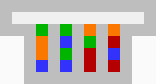

In [33]:
def day23b(s, *, part2=False, visualize=False):  # With visualization.
  lines = s.splitlines()
  letters = [[line[3], line[5], line[7], line[9]] for line in lines[2:4]]
  if part2:
    letters[1:1] = [list('DCBA'), list('DBAC')]  # Insert two middle rows.
  nrows = len(letters)
  # State consists of the 7 eligible hallway locations and the room locations.
  start_state = tuple(['.'] * 7 + list(more_itertools.flatten(letters)))
  end_state = tuple(['.'] * 7 + list('ABCD') * nrows)
  cost_for_id = {'A': 1, 'B': 10, 'C': 100, 'D': 1000}

  def as_grid(state):
    t = state
    a = ['#############', f'#{t[0]}{t[1]}.{t[2]}.{t[3]}.{t[4]}.{t[5]}{t[6]}#']
    for i in range(nrows):
      s = '  ' if i > 0 else '##'
      a.append(s + ''.join(f'#{t[7 + 4 * i + j]}' for j in range(4)) + f'#{s}')
    a.append('  #########  ')
    return np.array([list(line) for line in a])

  def eligible_moves(state):  # Yields (i0, i1, move_cost)
    # Move from the hallway position `i0` to a room `j`.
    for i0 in range(7):
      id = state[i0]
      if id == '.':
        continue
      j = ord(id) - ord('A')
      row = max((i for i in range(nrows) if state[7 + i * 4 + j] == '.'), default=None)
      if row is None or not all(state[7 + i * 4 + j] == id for i in range(row + 1, nrows)):
        continue
      i1 = 7 + row * 4 + j
      move_right = i0 <= j + 1
      if all(state[k] == '.' for k in (range(i0 + 1, 2 + j) if move_right else range(2 + j, i0))):
        move_cost = (
            (j - i0 + 2) * 2 - (i0 == 0) + row if move_right else (i0 - j - 1) * 2 - (i0 == 6) + row
        ) * cost_for_id[id]
        yield i0, i1, move_cost

    # Move from a room `j` to the hallway position `i1`.
    for j in range(4):
      row = min((i for i in range(nrows) if state[7 + i * 4 + j] != '.'), default=None)
      if row is None:
        continue
      i0 = 7 + row * 4 + j
      id = state[i0]
      if id == chr(ord('A') + j) and not any(
          state[7 + i * 4 + j] != id for i in range(row + 1, nrows)
      ):
        continue
      for i1 in range(2 + j, 7):  # Move right in hallway.
        if all(state[k] == '.' for k in range(2 + j, i1 + 1)):
          yield i0, i1, ((i1 - j - 1) * 2 - (i1 == 6) + row) * cost_for_id[id]
      for i1 in range(0, 2 + j):  # Move left in hallway
        if all(state[k] == '.' for k in range(i1, 2 + j)):
          yield i0, i1, ((j - i1 + 2) * 2 - (i1 == 0) + row) * cost_for_id[id]

  def apply_move(state, i0, i1):
    id = state[i0]
    # assert id in 'ABCD' and state[i1] == '.' and 0 < distance <= 8 + nrows
    # assert i1 < 7 or id == 'ABCD'[(i1 - 7) % 4]
    state2 = list(state)
    state2[i0] = '.'
    state2[i1] = id
    return tuple(state2)

  @functools.lru_cache(maxsize=None)
  def explore(state):  # Returns (cost, i0, i1) for best move.
    if state == end_state:
      return 0, 0, 0
    best = 10**8, 0, 0  # cost, i0, i1
    for i0, i1, move_cost in eligible_moves(state):
      state2 = apply_move(state, i0, i1)
      candidate_cost = move_cost + explore(state2)[0]
      if candidate_cost < best[0]:
        best = candidate_cost, i0, i1

    return best

  best = explore(start_state)

  if visualize:

    def make_image(grid, size=12):
      cmap = {
          ' ': (250,) * 3,
          '.': (240,) * 3,
          '#': (190,) * 3,
          'A': (180, 0, 0),
          'B': (0, 180, 0),
          'C': (50, 50, 250),
          'D': (250, 120, 0),
      }
      a = np.array([cmap[e] for e in grid.flat], np.uint8)
      return a.reshape(*grid.shape, 3).repeat(size, axis=0).repeat(size, axis=1)

    def get_pos(i0):
      return (
          (1, 1 + i0 * 2 - (i0 > 0) - (i0 == 6))
          if i0 < 7
          else (2 + (i0 - 7) // 4, 3 + (i0 - 7) % 4 * 2)
      )

    images = []
    state = start_state
    grid = as_grid(state)
    images.append(make_image(grid))
    while True:
      # print('\n'.join(''.join(line) for line in as_grid(state)))
      cost, i0, i1 = explore(state)
      if not cost:
        break
      y0, x0 = get_pos(i0)
      y1, x1 = get_pos(i1)
      while (y0, x0) != (y1, x1):
        grid[y0, x0] = '.'
        if y0 == 1 and x0 != x1:
          x0 += np.sign(x1 - x0)
        else:
          y0 += np.sign(y1 - y0)
        grid[y0, x0] = state[i0]
        images.append(make_image(grid))
      state = apply_move(state, i0, i1)

    images = [images[0]] * 16 + images + [images[-1]] * 8
    media.show_video(images, codec='gif', fps=10)

  return best[0]


check_eq(day23b(s1), 12521)  # ~700 ms
# puzzle.verify(1, day23b)  # ~3.3 s  (>4600 s without lru_cache())

day23b_part2 = functools.partial(day23b, part2=True)
# check_eq(day23b_part2(s1), 44169)  # ~5.1 s.
# puzzle.verify(2, day23b_part2)  # ~5.0 s.

_ = day23b_part2(puzzle.input, visualize=True)  # ~5.0 s.

In [34]:
def day23c(s, *, part2=False):  # Dijkstra or A* search.
  lines = s.splitlines()
  letters = [[line[3], line[5], line[7], line[9]] for line in lines[2:4]]
  if part2:
    letters[1:1] = [list('DCBA'), list('DBAC')]  # Insert two middle rows.
  nrows = len(letters)
  # State consists of the 7 eligible hallway locations and the room locations.
  start_state = tuple(['.'] * 7 + list(more_itertools.flatten(letters)))
  end_state = tuple(['.'] * 7 + list('ABCD') * nrows)
  cost_for_id = {'A': 1, 'B': 10, 'C': 100, 'D': 1000}

  def eligible_moves(state):  # Yields (i0, i1, move_cost)
    # Move from the hallway position `i0` to a room `j`.
    for i0 in range(7):
      id = state[i0]
      if id == '.':
        continue
      j = ord(id) - ord('A')
      row = max((i for i in range(nrows) if state[7 + i * 4 + j] == '.'), default=None)
      if row is None or not all(state[7 + i * 4 + j] == id for i in range(row + 1, nrows)):
        continue
      i1 = 7 + row * 4 + j
      move_right = i0 <= j + 1
      if all(state[k] == '.' for k in (range(i0 + 1, 2 + j) if move_right else range(2 + j, i0))):
        move_cost = (
            (j - i0 + 2) * 2 - (i0 == 0) + row if move_right else (i0 - j - 1) * 2 - (i0 == 6) + row
        ) * cost_for_id[id]
        yield i0, i1, move_cost

    # Move from a room `j` to the hallway position `i1`.
    for j in range(4):
      row = min((i for i in range(nrows) if state[7 + i * 4 + j] != '.'), default=None)
      if row is None:
        continue
      i0 = 7 + row * 4 + j
      id = state[i0]
      if id == chr(ord('A') + j) and not any(
          state[7 + i * 4 + j] != id for i in range(row + 1, nrows)
      ):
        continue
      for i1 in range(2 + j, 7):  # Move right in hallway.
        if all(state[k] == '.' for k in range(2 + j, i1 + 1)):
          yield i0, i1, ((i1 - j - 1) * 2 - (i1 == 6) + row) * cost_for_id[id]
      for i1 in range(0, 2 + j):  # Move left in hallway
        if all(state[k] == '.' for k in range(i1, 2 + j)):
          yield i0, i1, ((j - i1 + 2) * 2 - (i1 == 0) + row) * cost_for_id[id]

  def apply_move(state, i0, i1):
    id = state[i0]
    # assert id in 'ABCD' and state[i1] == '.' and 0 < distance <= 8 + nrows
    # assert i1 < 7 or id == 'ABCD'[(i1 - 7) % 4]
    state2 = list(state)
    state2[i0] = '.'
    state2[i1] = id
    return tuple(state2)

  def lower_bound_cost(state):
    cost = 0
    for i0 in range(7):
      id = state[i0]
      if id != '.':
        j = ord(id) - ord('A')
        move_right = i0 <= j + 1
        cost += (
            (j - i0 + 2) * 2 - (i0 == 0) if move_right else (i0 - j - 1) * 2 - (i0 == 6)
        ) * cost_for_id[id]
    for row in range(nrows):
      for j in range(4):
        i0 = 7 + row * 4 + j
        id = state[i0]
        if id != '.':
          j2 = ord(id) - ord('A')
          if j2 != j:
            cost += (row + 2 + abs(j - j2) * 2) * cost_for_id[id]
    return cost

  check_eq(lower_bound_cost(end_state), 0)
  use_a_star = True  # Else ordinary Dijkstra search.
  distances = collections.defaultdict(lambda: 10**8)
  distances[start_state] = 0
  pq = [(0, start_state)]
  while pq:
    _, state = heapq.heappop(pq)
    distance = distances[state]
    if state == end_state:
      return distance
    for i0, i1, move_cost in eligible_moves(state):
      candidate_d = distance + move_cost
      state2 = apply_move(state, i0, i1)
      if candidate_d < distances[state2]:
        distances[state2] = candidate_d
        # https://en.wikipedia.org/wiki/A*_search_algorithm
        f = candidate_d + lower_bound_cost(state2) if use_a_star else candidate_d
        heapq.heappush(pq, (f, state2))


check_eq(day23c(s1), 12521)  # ~0.18 s with A* (~0.7 s with Dijkstra).
puzzle.verify(1, day23c)  # ~0.8s with A*  (~2.8 s with Dijkstra).

day23c_part2 = functools.partial(day23c, part2=True)
# check_eq(day23c_part2(s1), 44169)  # ~4.9 s with A*  (~11 s with Dijkstra).
# puzzle.verify(2, day23c_part2)  # ~6.0 s with A*  (~5.2 s with Dijkstra).

(Part 1: 0.259 s)


In [35]:
# Dijkstra/A*, but mangled to support numba.
@numba.njit
def day23_func(nrows, start_state, end_state, state_size):
  # State consists of the 7 eligible hallway locations and the room locations.
  cost_for_id = {0: 1, 1: 10, 2: 100, 3: 1000}

  def apply_move(state, i0, i1):
    id = state[i0]
    # assert 0 <= id < 4 and state[i1] < 0
    # assert i1 < 7 or id == (i1 - 7) % 4
    if using_numba:
      # https://numba.discourse.group/t/how-to-use-a-sequence-as-dict-key/431/11
      # https://github.com/numba/numba/blob/master/numba/tests/test_unsafe_intrinsics.py
      if 1:  # Fast.
        setitem = numba.cpython.unsafe.tuple.tuple_setitem
        return setitem(setitem(state, i0, -1), i1, id)  # pylint: disable=no-value-for-parameter
      # Slower.
      state2 = np.array(state)
      state2[i0] = -1
      state2[i1] = id
      to_fixed = numba.np.unsafe.ndarray.to_fixed_tuple  # pylint: disable=no-member
      return to_fixed(state2, state_size)
    state2 = list(state)
    state2[i0] = -1
    state2[i1] = id
    return tuple(state2)

  def lower_bound_cost(state):
    cost = 0
    for i0 in range(7):
      id = state[i0]
      if id >= 0:
        move_right = i0 <= id + 1
        cost += (
            (id - i0 + 2) * 2 - (i0 == 0) if move_right else (i0 - id - 1) * 2 - (i0 == 6)
        ) * cost_for_id[id]
    for row in range(nrows):
      for j in range(4):
        i0 = 7 + row * 4 + j
        id = state[i0]
        if id >= 0:
          if id != j:
            cost += (row + 2 + abs(j - id) * 2) * cost_for_id[id]
    return cost

  assert lower_bound_cost(end_state) == 0
  use_a_star = True  # A* search rather than ordinary Dijkstra algorithm.
  distances = {start_state: 0}
  pq = [(0, start_state)]
  while pq:
    _, state = heapq.heappop(pq)
    distance = distances[state]
    if state == end_state:
      return distance

    def consider(i0, i1, move_cost):
      candidate_d = distance + move_cost
      state2 = apply_move(state, i0, i1)
      if state2 not in distances or candidate_d < distances[state2]:
        distances[state2] = candidate_d
        # https://en.wikipedia.org/wiki/A*_search_algorithm
        f = candidate_d + lower_bound_cost(state2) if use_a_star else candidate_d
        heapq.heappush(pq, (f, state2))

    # Move from the hallway position `i0` to a room `j`.
    for i0 in range(7):
      id = state[i0]
      if id < 0:
        continue
      for row in range(nrows - 1, -1, -1):
        if state[7 + row * 4 + id] < 0:
          break
      else:
        continue
      # ("any(state[7 + i * 4 + id] != id for i in range(row + 1, nrows))" disallowed in numba.)
      bad = False
      for i in range(row + 1, nrows):
        if state[7 + i * 4 + id] != id:
          bad = True
          break
      if bad:
        continue
      i1 = 7 + row * 4 + id
      move_right = i0 <= id + 1
      for k in range(i0 + 1, 2 + id) if move_right else range(2 + id, i0):
        if state[k] >= 0:
          break
      else:
        move_cost = (
            (id - i0 + 2) * 2 - (i0 == 0) + row
            if move_right
            else (i0 - id - 1) * 2 - (i0 == 6) + row
        ) * cost_for_id[id]
        consider(i0, i1, move_cost)

    # Move from a room `j` to the hallway position `i1`.
    for j in range(4):
      for row in range(nrows):
        if state[7 + row * 4 + j] >= 0:
          break
      else:
        continue
      i0 = 7 + row * 4 + j
      id = state[i0]
      if id == j:
        for i in range(row + 1, nrows):
          if state[7 + i * 4 + j] != id:
            break
        else:
          continue
      for i1 in range(2 + j, 7):  # Move right in hallway.
        for k in range(2 + j, i1 + 1):
          if state[k] >= 0:
            break
        else:
          move_cost = ((i1 - j - 1) * 2 - (i1 == 6) + row) * cost_for_id[id]
          consider(i0, i1, move_cost)
      for i1 in range(0, 2 + j):  # Move left in hallway
        for k in range(i1, 2 + j):
          if state[k] >= 0:
            break
        else:
          move_cost = ((j - i1 + 2) * 2 - (i1 == 0) + row) * cost_for_id[id]
          consider(i0, i1, move_cost)


def day23(s, *, part2=False):
  lines = s.splitlines()
  letters = [[line[3], line[5], line[7], line[9]] for line in lines[2:4]]
  if part2:
    letters[1:1] = [list('DCBA'), list('DBAC')]  # Insert two middle rows.
  nrows = len(letters)
  start_state = tuple([-1] * 7 + [ord(ch) - ord('A') for ch in more_itertools.flatten(letters)])
  end_state = tuple([-1] * 7 + [0, 1, 2, 3] * nrows)
  state_size = len(start_state)
  return day23_func(nrows, start_state, end_state, state_size)


# ~6 s for numba compilation.
check_eq(day23(s1), 12521)  # ~38 ms with A* (~75 ms with Dijkstra).
puzzle.verify(1, day23)  # ~85 ms with A*  (~270 ms with Dijkstra).

day23_part2 = functools.partial(day23, part2=True)
# ~6 s for numba compilation.
check_eq(day23_part2(s1), 44169)  # ~330 ms with A*  (~400 ms with Dijkstra).
puzzle.verify(2, day23_part2)  # ~380 ms with A*  (~390 ms with Dijkstra).

(Part 1: 0.025 s)
(Part 2: 0.165 s)


For my particular `puzzle.input`, in Part 2 the A* search algorithm does not provide much benefit because the expensive `'D'` objects cannot be moved until near the end of the move sequence.

In [36]:
# Note: defining state as str rather than tuple has no effect on timings.

# Note: using slicing rather than temp list in apply_move() has no effect:
# state2 = (state[:i0] + ('.',) + state[i0+1:i1] + (id,) + state[i1+1:] if i0 < i1 else
#           state[:i1] + (id,) + state[i1+1:i0] + ('.',) + state[i0+1:])
# state2 = tuple_replace(tuple_replace(state, i0, '.'), i1, id)
# state2 = (state[:i0] + '.' + state[i0+1:i1] + id + state[i1+1:] if i0 < i1 else
#           state[:i1] + id + state[i1+1:i0] + '.' + state[i0+1:])

<a name="day24"></a>
## Day 24: Simulate number validator

- Part 1: What is the largest model number accepted by MONAD?

- Part 2: What is the smallest model number accepted by MONAD?

---

After carefully writing code for a machine emulator,
I ended up solving this problem almost completely **by hand**.
(I did use the emulator to verify that my manually obtained answers were admissible before submitting them.)

The key observations are:

- The input code has **14 blocks**, each with 18 code instructions.  One of those is an input instruction to read one of the 14 digits.

- The 14 code blocks are very similar, and can be **parameterized by 3 literal values** (in instructions 4, 5, and 15).

- After much simplification, the 18 instructions are seen to implement a simple **state machine with a stack** (i.e., a context-free grammar).

- The machine encodes a set of **linear equality constraints** between pairs of digits in the input, e.g. `digit[i1] = digit[i2] + diff`.

- Any digit that is unconstrained can be trivially assigned `9` or `1`, for the puzzle Part 1 or Part 2, respectively.

- For a pair of constrained digits, we similarly assign either `9` or `1` to the upper or lower digit in the equality constraint, and then determine the value of the other digit.

Alternative solutions:

- I can see that one could search over possible digits by running the code emulator, and bounding the intermediate values of the generated `z` register values (perhaps also based on the number of remaining digits, as in A* search).

In [37]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2021/day/24), `puzzle.input` has 252 lines:

inp w
mul x 0
add x z
mod x 26
div z 1
add x 13
eql x w
eql x 0
 ...
add y w
add y 3
mul y x
add z y


The stored answers are: `{1: '93499629698999', 2: '11164118121471'}`

In [38]:
def day24a(s, *, part2=False, verbose=0):  # Careful, with emulator verification.
  lines = s.splitlines()

  def simulate(input):
    regs = [0] * 4
    for line in lines:
      if verbose >= 2:
        highlight = '  ****' if 'inp' in line else ''
        print(f'{str(regs):34} {line}{highlight}')
      args = line.split()
      op = args[0]
      if op == 'inp':
        reg = ord(args[1]) - ord('w')
        assert 0 <= reg < 4
        regs[reg] = int(input[0])
        assert 1 <= regs[reg] <= 9
        input = input[1:]
      else:
        reg1 = ord(args[1]) - ord('w')
        value = regs[ord(args[2]) - ord('w')] if args[2] in 'wxyz' else int(args[2])
        if op == 'add':
          regs[reg1] += value
        elif op == 'mul':
          regs[reg1] *= value
        elif op == 'div':
          assert value != 0
          regs[reg1] = int(float(regs[reg1] / value))  # Round towards zero.
        elif op == 'mod':
          assert regs[reg1] >= 0 and value > 0
          regs[reg1] %= value
        elif op == 'eql':
          regs[reg1] = int(regs[reg1] == value)
        else:
          assert False, op

    valid = regs[3] == 0
    if verbose >= 1:
      print(f'{str(regs):34} {valid=}')
    return valid

  assert len(lines) == 14 * 18 == 252
  params = {4: 'div z ', 5: 'add x ', 15: 'add y '}
  assert all(lines[i].startswith(s) for m, s in params.items() for i in range(m, 253, 18))
  a, b, c = [[int(lines[i].split()[-1]) for i in range(m, 253, 18)] for m in params]

  solution: list[int | None] = [None] * 14
  stack = []
  for i in range(14):
    if a[i] == 1:
      stack.append((i, c[i]))
    elif a[i] == 26:
      j, old_c = stack.pop()
      diff = old_c + b[i]
      # The constraint is that solution[i] - solution[j] == diff.
      assert -8 <= diff <= 8 and solution[i] is None and solution[j] is None
      if part2:
        solution[i] = 1 + diff if diff >= 0 else 1
        solution[j] = 1 if diff >= 0 else 1 - diff
      else:
        solution[i] = 9 if diff >= 0 else 9 + diff
        solution[j] = 9 - diff if diff >= 0 else 9
    else:
      assert False
  assert not stack
  solution = [e if e is not None else 1 if part2 else 9 for e in solution]

  input = ''.join(map(str, solution))
  check_eq(simulate(input), True)
  return input


puzzle.verify(1, day24a)  # ~0 ms.
day24a_part2 = functools.partial(day24a, part2=True)
puzzle.verify(2, day24a_part2)  # ~1 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [39]:
def day24(s, *, part2=False):  # Compact.
  lines = s.splitlines()
  a, b, c = [[int(lines[i].split()[-1]) for i in range(m, 253, 18)] for m in (4, 5, 15)]
  solution = [1 if part2 else 9] * 14
  stack = []
  for i in range(14):
    if a[i] == 1:
      stack.append((i, c[i]))
    else:
      j, old_c = stack.pop()
      diff = old_c + b[i]
      if part2:
        solution[i] = 1 + diff if diff >= 0 else 1
        solution[j] = 1 if diff >= 0 else 1 - diff
      else:
        solution[i] = 9 if diff >= 0 else 9 + diff
        solution[j] = 9 - diff if diff >= 0 else 9

  return ''.join(map(str, solution))


puzzle.verify(1, day24)  # ~0 ms.
day24_part2 = functools.partial(day24, part2=True)
puzzle.verify(2, day24_part2)  # ~0 ms.

(Part 1: 0.000 s)
(Part 2: 0.000 s)


In [40]:
def day24_test1():  # Notice the repeated 18-line blocks; find the block differences:
  lines = puzzle.input.splitlines()
  for m in range(18):
    print(f'{m} mod 18:')
    set_ = set(line for i, line in enumerate(lines) if i % 18 == m)
    print('   ' + '\n   '.join(sorted(set_)))


if 0:
  day24_test1()

In [41]:
def day24_test2():  # Extract the parameters of the 14 code blocks.
  lines = puzzle.input.splitlines()
  params = {4: 'div z ', 5: 'add x ', 15: 'add y '}
  a, b, c = [[int(lines[i].split()[-1]) for i in range(m, 253, 18)] for m in params]
  print(f'a = {a}')
  print(list(zip(range(14), a, b, c)))


if 0:
  day24_test2()

In [42]:
# Block of 18 lines repeated 14 times:
# inp w     w = input
# mul x 0
# add x z
# mod x 26  x = z % 26
# div z 1   z /= a   where a = 1 or 26
# add x 13  x += b   where b = -14, -13, -9, ..., 11, 12, 13, 15
# eql x w
# eql x 0   x = x != w
# mul y 0
# add y 25
# mul y x
# add y 1   y = x * 25 + 1
# mul z y   z *= y
# mul y 0
# add y w   y = w
# add y 14  y += c  where c = 3, 4, 5, 6, 7, 8, 10, 13, 13, 13, 14, 16
# mul y x   y *= x
# add z y   z += y

In [43]:
# Progressively simplify the code:

# w = input  (1..9)
# x = w != ((z % 26) + b)
# z = int(z / a) * (x * 25 + 1)  +  (w + c) * x

# where a = 1 or 26    (%18 == 4)
# where b = -14, -13, -9, ..., 11, 12, 13, 15  (%18==5)
# where c = 3, 4, 5, 6, 7, 8, 10, 13, 13, 13, 14, 16  (%18==15)

In [44]:
# w = input  (1..9)
# if w != ((z % 26) + b):
#   z = int(z / a) * 26 + w + c
# else:
#   z = int(z / a)

In [45]:
# w = input  (1..9)
# if w != digits[0] + b
#   if a == 26:
#     digits[0] = w + c
#   else:  # a == 1
#     digits.push(w + c)
# else:
#   if a == 26:
#     digits.pop()

In [46]:
# w = input  (1..9)
# match = w == digits[-1] + b
# if a == 26:
#   if match:
#     digits.pop()
#   else:
#     digits[-1] = w + c
# else:  # a == 1
#   if not match:
#     digits.append(w + c)

# valid = all(digit == 0 for digit in digits)
# valid = not digits  # Actually, at least for this input.

In [47]:
# Run the code on my puzzle input.

# match = w0 == (0) + 13  # False
# append(w0 + 14)
# [w0 + 14]

# match = w1 == (w0 + 14) + 12  # False
# append(w1 + 8)
# [w0 + 14, w1 + 8]

# match = w2 == (w1 + 8) + 11  # False
# append(w2 + 5)
# [w0 + 14, w1 + 8, w2 + 5]

# match = w3 == (w2 + 5) + 0  # True   if w3 == w2 + 5
# pop()    # (if not match, replace w1 + 8 by w3 + 4)
# [w0 + 14, w1 + 8]

# match = w4 == (w1 + 8) + 15  # False
# append(w4 + 10)
# [w0 + 14, w1 + 8, w4 + 10]

# match = w5 == (w4 + 10) - 13  # True if w5 == w4 - 3
# pop()
# [w0 + 14, w1 + 8]

# match = w6 == (w1 + 8) + 10  # False
# append(w6 + 16)
# [w0 + 14, w1 + 8, w6 + 16]

# match = w7 == (w6 + 16) - 9  # True if w7 == w6 + 7
# pop()
# [w0 + 14, w1 + 8]

# match = w8 == (w1 + 8) + 11  # False
# append(w8 + 6)
# [w0 + 14, w1 + 8, w8 + 6]

# match = w9 == (w8 + 6) + 13  # False
# append(w9 + 13)
# [w0 + 14, w1 + 8, w8 + 6, w9 + 13]

# match = w10 == (w9 + 13) - 14  # True if w10 == w9 - 1
# pop()
# [w0 + 14, w1 + 8, w8 + 6]

# match = w11 == (w8 + 6) - 3  # True if w11 == w8 + 3
# pop()
# [w0 + 14, w1 + 8]

# match = w12 == (w1 + 8) - 2  # True if w12 == w1 + 6
# pop()
# [w0 + 14]

# match = w13 == (w0 + 14) - 14  # True if w13 == w0
# pop()
# []

# Answers:
# index: 01234567890123
# max:   93499629698999
# min:   11164118121471

<a name="day25"></a>
## Day 25: Slide objects right and down

- Part 1: What is the first step on which no sea cucumbers move?

- Part 2: There is no part 2 for this last day of the Advent.

---

See the related work on the [Biham–Middleton–Levine traffic model](https://en.wikipedia.org/wiki/Biham%E2%80%93Middleton%E2%80%93Levine_traffic_model).
It's amazing that there is a whole area of research on this topic.

I explored two approaches:

1. Using a **2D `numpy` grid**, with `np.roll` operations to gather neighbors.  This makes for highly compact code.

2. Additionally maintaining two lists of **candidate active nodes**, which have a possibility (but not guarantee) of being able to advance in the next step.  These lists provide a significant speedup in the latter part of the simulation when a smaller fraction of nodes are advancing.

In [48]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2021/day/25), `puzzle.input` has 137 lines:

v>..v.v>.>..>.......>v>v>v.vvv>..v...vv.>>......v..>...v....>>v...v..v.v...>v..> ... .>vvv..>v...>.vv>vv.v>>.....v>v.v.>
>v.>.v.v.....>v>>v..v...>.>..>.>.vvvv..>vv.>.>v>.....v>>v>v.....>.v.>...>....v>. ... .>v.v.v..v.vv>vvvv>..v.>.v...v.>>.>
v.>...>....vv.v>.>.v.v...v.v>...>.vv..>>v>>>..>>.v..vv>.>..>.vv.>vv.v....vvv>.vv ... v.v.v...>.v..v.>..>..v.v...v.v>.>>.
.>..>>.>.....vv..vvv...>>>v.>v..v.>.v..>.v..vv..>....>........v.v>v..v>..v>>v>v> ... >..>......>v>>>>.v...>..>.....v.v.v
>v>>..>.v........>....>v>.v.....v.v.v...v>..vv.v.>..>....>..v>.v....>>>v>v.v...v ... .>v>....>>..>.v>...v.vv.>>v..v>>v.v
..>>v>....>..v>v..v.v..>.....v.>vv....v>....v.v>.>v>....v>.>..>>.vv.>>>..v.v>v.. ... ..v...vv>>.>>....vvv....vv>>v..>.vv
..>..>.v>>...>.>>v...>>.v>vv.>>.>v>.v....v>vv.v>>v.vvv......vvv>...vvv>>v..>.vv. ... .v.vv>.....>.vv>..>>..v>>....>>vvv>
..>.>>v.>>..v.>vv.>.....>.....v..>>.>......>>..v>...v....v..v.v.v..v..>..v...>>> ... >.vv>.vv>.v.vvvvv>vv>..>..>>.v>v..v
 ...
....>v>.vv..v.v>..v..vv>.>.

The stored answers are: `{1: '419', 2: ''}`

In [49]:
s1 = """\
v...>>.vv>
.vv>>.vv..
>>.>v>...v
>>v>>.>.v.
v>v.vv.v..
>.>>..v...
.vv..>.>v.
v.v..>>v.v
....v..v.>
"""

In [50]:
def day25a(s):  # Compact and reasonably fast.
  grid = np.array([list(line) for line in s.splitlines()])
  for step in itertools.count(1):
    moved = False
    for ch, dyx in zip(['>', 'v'], np.array([[0, 1], [1, 0]])):
      next = np.roll(grid, -dyx, axis=(0, 1))
      can_move = (grid == ch) & (next == '.')
      moved |= bool(can_move.any())
      grid[can_move] = '.'
      grid[np.roll(can_move, dyx, axis=(0, 1))] = ch
    if not moved:
      return step


check_eq(day25a(s1), 58)
puzzle.verify(1, day25a)  # ~550 ms.  (419 steps)

(Part 1: 0.206 s)


In [51]:
def day25b(s):  # Same speed when using indices rather than boolean mask.
  grid = np.array([list(line) for line in s.splitlines()])
  for step in itertools.count(1):
    moved = False
    for ch, dyx in zip(['>', 'v'], np.array([[0, 1], [1, 0]])):
      next = np.roll(grid, -dyx, axis=(0, 1))
      can_move = (grid == ch) & (next == '.')
      can_move_indices = np.nonzero(can_move)
      grid[can_move_indices] = '.'
      moved |= len(can_move_indices[0]) > 0
      y, x = can_move_indices
      if ch == '>':
        x = (x + 1) % grid.shape[1]
      else:
        y = (y + 1) % grid.shape[0]
      grid[y, x] = ch
    if not moved:
      return step


check_eq(day25b(s1), 58)
puzzle.verify(1, day25b)  # ~560 ms.

(Part 1: 0.215 s)


In [52]:
def day25c(s, *, verbose=False, visualize=False):  # With visualization.
  grid = np.array([list(line) for line in s.splitlines()])
  images = []

  for step in itertools.count(1):
    moved = False
    for ch, dyx in zip(['>', 'v'], np.array([[0, 1], [1, 0]])):
      next = np.roll(grid, -dyx, axis=(0, 1))
      can_move = (grid == ch) & (next == '.')
      moved |= bool(can_move.any())
      grid[can_move] = '.'
      grid[np.roll(can_move, dyx, axis=(0, 1))] = ch
      if verbose:
        print('\n' + '\n'.join(''.join(line) for line in grid))

    if visualize:
      cmap = {'.': (240,) * 3, '>': (180, 0, 0), 'v': (0, 180, 0)}
      a = np.array([cmap[e] for e in grid.flat], np.uint8)
      image = a.reshape(*grid.shape, 3).repeat(2, axis=0).repeat(2, axis=1)
      images.append(image)

    if not moved:
      if visualize:
        images = [images[0]] * 50 + images + [images[-1]] * 50
        media.show_video(images, codec='gif', fps=50)  # ~2 MB embedded GIF.
      return step


if SHOW_BIG_MEDIA:
  _ = day25c(puzzle.input, visualize=True)  # Slow; ~14 s.

In [53]:
# Fastest: active sets and numba.
@numba.njit
def day25_func(grid):
  height, width = grid.shape
  candidate_right = [
      (y, x)
      for y in range(height)
      for x in range(width)
      if grid[y, x] == '>' and grid[y, (x + 1) % width] == '.'
  ]
  candidate_down = [
      (y, x)
      for y in range(height)
      for x in range(width)
      if grid[y, x] == 'v' and grid[(y + 1) % height, x] == '.'
  ]

  for step in range(1, 10**8):
    moved = False

    new_candidate_right = []
    for y, x in candidate_right:
      x2 = (x + 1) % width
      if grid[y, x2] == '.':
        moved = True
        grid[y, x] = '.'
        grid[y, x2] = '>'
        if grid[y, (x + 2) % width] == '.':
          new_candidate_right.append((y, x2))
        if grid[(y - 1) % height, x] == 'v':
          candidate_down.append(((y - 1) % height, x))
        elif grid[y, (x - 1) % width] == '>':
          new_candidate_right.append((y, (x - 1) % width))
    candidate_right = new_candidate_right

    new_candidate_down = []
    for y, x in candidate_down:
      y2 = (y + 1) % height
      if grid[y2, x] == '.':
        moved = True
        grid[y, x] = '.'
        grid[y2, x] = 'v'
        if grid[(y + 2) % height, x] == '.':
          new_candidate_down.append((y2, x))
        if grid[y, (x - 1) % width] == '>':
          candidate_right.append((y, (x - 1) % width))
        elif grid[(y - 1) % height, x] == 'v':
          new_candidate_down.append(((y - 1) % height, x))
    candidate_down = new_candidate_down

    if not moved:
      return step


def day25(s):
  grid = np.array([list(line) for line in s.splitlines()])
  return day25_func(grid)


check_eq(day25(s1), 58)
puzzle.verify(1, day25)  # ~180 ms.  (~1100 ms without numba)

(Part 1: 0.058 s)


In [54]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [55]:
advent.show_times()

day_21   part_1: 0.000   part_2: 0.001
day_22   part_1: 0.002   part_2: 0.018
day_23   part_1: 0.025   part_2: 0.165
day_24   part_1: 0.000   part_2: 0.000
day_25   part_1: 0.058   part_2: 0.000
Total time:  0.269 s


In [56]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [57]:
if 1:  # Look for unwanted pollution of namespace.
  print(
      textwrap.fill(
          ' '.join(
              name
              for name, value in globals().items()
              if not (name.startswith(('_', 'day')) or name in _ORIGINAL_GLOBALS)
          )
      )
  )

puzzle s1 s2 s3 Kdtree test_kdtree


In [58]:
if 0:  # Save puzzle inputs and answers to a compressed archive for downloading.
  # Create a new tar.gz file.
  hh.run(
      f"""cd /mnt/c/hh/tmp && cp -rp ~/.config/aocd/'{PROFILE.replace("_", " ")}' '{PROFILE}' && tar -czf '{PROFILE}.tar.gz' '{PROFILE}'"""
  )

In [59]:
if 0:  # Look for misspelled words.
  hh.run(
      rf"""cat advent_of_code_{YEAR}.py | perl -pe "s@https?:/.*?[)> ]@@g; s/'/ /g; s/\\\\n//g;" | spell | sort -u || true"""
  )

In [60]:
if 0:  # Lint.
  hh.run('echo flake8; flake8')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pylint; pylint -j8 . || true')
  print('All ran.')

In [61]:
hh.show_notebook_cell_top_times()

# Total time: 18.39 s
# In[ 35] # Dijkstra/A*, but mangled to support numba.\n@numba.        5.981 s
# In[ 29] # Mangled numba version of day22d; fastest.\n@numba.         3.442 s
# In[ 33] def day23b(s, *, part2=False, visualize=False):  # With      2.038 s
# In[ 24] def day22b(s, *, part2=False):  # Using 3D grid over         1.897 s
# In[ 53] # Fastest: active sets and numba.\n@numba.njit\ndef day25_   0.967 s
# In[ 17] def day21b_part2(s):  # Avoiding functools.lru_cache().\n    0.791 s
# In[ 20] # Fastest, using numba.\n@numba.njit\ndef day21_part2_func(  0.737 s
# In[ 25] def day22c(s, *, part2=False):  # Using CSG of boxes.\n  #   0.436 s
# In[ 34] def day23c(s, *, part2=False):  # Dijkstra or A* search.\n   0.331 s
# In[ 32] def day23a(s, *, part2=False):  # Compact.\n  lines = s.     0.277 s
# In[ 51] def day25b(s):  # Same speed when using indices rather       0.220 s
# In[ 50] def day25a(s):  # Compact and reasonably fast.\n  grid =     0.217 s
# In[ 28] def day22e(s, *, par

# End

In [62]:
if 0:  # Original non-numpy versions.

  def day19_encode_3d_old(point):
    """Packs three 21-bit signed integers into a 64-bit int."""
    return point[0] * 2**42 + point[1] * 2**21 + point[2]

  def day19_decode_3d_old(value):
    """Extracts three 21-bit signed integers from a 64-bit int."""
    x = (value + 2**41) // 2**42
    value -= x * 2**42
    y = (value + 2**20) // 2**21
    z = value - y * 2**21
    return x, y, z

In [63]:
if 0:  # Experiments with encoding three small ints into a large int.
  if 0:

    def encode(point):
      return point[0] * 4_294_967_291 + point[1] * 65_521 + point[2]

    def decode(value):  # Fails.
      x, mod = divmod(value, 4_294_967_291)
      y, z = divmod(mod, 65_521)
      return x, y, z

  else:

    def encode(point):  # 64-bit encoding of three 21-bit signed integers.
      return point[0] * 2**42 + point[1] * 2**21 + point[2]

    def decode(value):
      x = (value + 2**41) // 2**42
      value -= x * 2**42
      y = (value + 2**20) // 2**21
      value -= y * 2**21
      return x, y, value

  def test():
    for point in itertools.product(
        [-30_000, -257, -256, -255, -10, -1, 0, 1, 10, 255, 256, 257, 30_000], repeat=3
    ):
      e = encode(point)
      point2 = decode(e)
      check_eq(point, point2)

  test()

In [64]:
# Restrict the path search in Day 15 to a matrix band.
# def process1(s, part2=False, max_band=80):
#   import scipy.linalg
#   in_matrix_band = scipy.linalg.toeplitz(
#       np.arange(stride) <= max_band).ravel()
#   if candidate_d < distances[index2]:
#     if in_matrix_band[index2]:
#       distances[index2] = candidate_d
#       heappush(pq, (candidate_d, index2))

In [65]:
if 0:
  ZIP_URL = f'https://github.com/hhoppe/advent_of_code_{YEAR}/raw/main/data/{PROFILE}.zip'
  hh.run(
      f'if [ ! -d data/{PROFILE} ]; then (mkdir -p data && cd data &&'
      f' wget -q {ZIP_URL} && unzip -q {PROFILE}); fi'
  )

  # Create a new zip file, quietly (-q) and ignoring relative paths (-j).
  hh.run(f"""!zip -q -j - ~/.config/aocd/'{PROFILE.replace("_", " ")}'/*.txt >/content/data.zip""")

[[Open the notebook in mybinder.org]](https://mybinder.org/v2/gh/hhoppe/advent_of_code/main?filepath=2021/advent_of_code_2021.ipynb)

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->